# Active Learning for caltech256 using Cleanlab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/active_learning_multiannotator/active_learning.ipynb)

This notebook demonstrates a practical approach to active learning for training classification models with cleanlab. In active learning, we aim to construct a labeled dataset by collecting the fewest labels that still allow us to train an accurate classifier model. Here we assume data labeling is done in **batches**, and between these data labeling rounds, we retrain our classifier to decide what examples (i.e. datapoints) to label next round. We consider labeling a batch of examples per round and are limited to a single annotation per example.

cleanlab provides an active learning score quantifying how desirable it is to collect an additional label for every possible unlabeled example

This notebook demonstrates how to compute these easily for use in sequential active learning, showing how a classification model iteratively improves after labeling more examples for multiple rounds.
This notebook implements the following steps:

1. Establish some already labeled data. Use this data to train a classifier model and then obtain out-of-sample predicted probabilities for each labeled and unlabeled example.
2. Compute active learning scores for every example, which estimate our current confidence in knowing its true label.
3. Collect additional labels for the unlabeled examples with the lowest active learning scores. These are the most potentially informative examples whose true label we are least certain of. 
4. Repeat the steps above to collect as many labels as your budget permits.

The accuracy of the model trained on the resulting dataset will generally match that of the same model trained on a much larger set of randomly collected labels. I.e. this is the most cost-effective way to train an accurate classifier!

In this example we use the caltch256 dataset combined with autogluon's new MultiModalPredictor architecture.

## Import dependencies and get data

In [1]:
import time
import numpy as np
import pandas as pd
from autogluon.multimodal import MultiModalPredictor
from autogluon.vision import ImageDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator, get_active_learning_scores
from utils.model_training_autogluon import cross_val_predict_autogluon_classification_dataset

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load the following datafiles:

- `dataset` is a DataFrame that contains labels and image paths for each example

We will then randomly split the dataset into train and test splits. Test data will just be used to measure the accuracy in our model after each active learning round. The train data will further be split into a labeled and unlabeled part. For the df_labeled we will use the labels to train the model while the df_unlabeled will simulate active learning by allowing us to artifically insert mode labeled data in between rounds.

We will choose to start with num_labeled_per_class = 8

In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ActiveLearning/Caltech256/256_ObjectCategories.zip' && unzip -o -q 256_ObjectCategories.zip

File ‘256_ObjectCategories.zip’ already there; not retrieving.



In [3]:
dataset = ImageDataset.from_folder('./256_ObjectCategories/')
dataset = dataset.replace(257, 256) # no class class in dataset is labeled as 257, we need to reindex

In [4]:
# get train-test split
X, y = np.arange(len(dataset) * 2).reshape((len(dataset), 2)), range(len(dataset))
_, _, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

df_train = dataset.iloc[y_train]
df_test = dataset.iloc[y_test]
df_test = df_test.reset_index(drop=True)

In [5]:
def get_labeled(dataset,  num_labeled_per_class=15):
    """Splits provided dataset into two datasets. With df_labeled containing num_labeled_per_class labeles for 
    each class and df_unlabeled containing the rest of the rows in dataset"""
    
    df_labeled = dataset.groupby("label").sample(n=num_labeled_per_class, random_state=123)
    labeled_index = list(df_labeled.index)
    unlabeled_index = [i for i in range(len(dataset)) if i not in labeled_index]
    df_unlabeled = dataset.iloc[unlabeled_index]
    df_unlabeled = df_unlabeled.reset_index(drop=True)
    df_labeled = df_labeled.reset_index(drop=True)    
    return labeled_index, df_labeled, unlabeled_index, df_unlabeled

labeled_index, df_labeled, unlabeled_index, df_unlabeled = get_labeled(dataset, num_labeled_per_class=8)

## Train model to obtain predicted probabilites

First, we train our model on a set of labels obtained by `get_labeled` to get the out-of-sample predicted class probabilities for both the labeled and unlabeled data. 

The train function will return two sets of predicted probabilites, `pred_probs_labeled` are the predicted probabilites for examples that have existing annotator labels (they correspond directly with the rows in `df_labeled`), whereas `pred_probs_unlabeled` are the predicted probabilites for examples that do not have any annotator labels (they correspond directly with the rows in `df_unlabeled`). These predicted probabilities will later be used to compute the active learning score.

If working with your own dataset, you should consider modifying this `cross_val_predict_autogluon_classification_dataset` function so that it is better fitted for training your specific dataset.

In [6]:
pred_probs_labeled, pred_probs_unlabeled, labels_labeled, images = cross_val_predict_autogluon_classification_dataset(
                                                                                    dataset,
                                                                                    out_folder=None,
                                                                                    cv_n_folds=3,
                                                                                    df_predict=df_unlabeled,
                                                                                    hypterparameters={},
                                                                                    time_limit=180,)

Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_031600/"


----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_R

Epoch 0:  41%|████████████████████████                                   | 1148/2808 [02:01<02:55,  9.47it/s, loss=4.5, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  43%|█████████████████████████▎                                 | 1207/2808 [02:03<02:44,  9.74it/s, loss=4.5, v_num=]


Epoch 0:  45%|██████████████████████████▋                                | 1269/2808 [02:06<02:33, 10.04it/s, loss=4.5, v_num=]


Epoch 0:  47%|███████████████████████████▉                               | 1331/2808 [02:09<02:23, 10.31it/s, loss=4.5, v_num=]


Epoch 0:  50%|█████████████████████████████▎                             | 1393/2808 [02:11<02:13, 10.59it/s, loss=4.5, v_num=]


Epoch 0:  50%|█████████████████████████████▌                             | 1404/2808 [02:12<02:12, 10.63it/s, loss=4.5, v_num=]
                                                                                                                               

Epoch 0, global step 71: 'val_accuracy' reached 0.25184 (best 0.25184), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_031600/epoch=0-step=71.ckpt' as top 3


Epoch 0:  65%|█████████████████████████████████████▍                    | 1812/2808 [02:59<01:38, 10.07it/s, loss=2.55, v_num=]

Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Epoch 0:  65%|█████████████████████████████████████▍                    | 1813/2808 [03:00<01:38, 10.07it/s, loss=2.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  67%|██████████████████████████████████████▋                   | 1872/2808 [03:02<01:31, 10.24it/s, loss=2.57, v_num=]


Epoch 0:  69%|███████████████████████████████████████▉                  | 1934/2808 [03:05<01:23, 10.42it/s, loss=2.57, v_num=]


Epoch 0:  71%|█████████████████████████████████████████▏                | 1996/2808 [03:08<01:16, 10.59it/s, loss=2.57, v_num=]


Epoch 0:  73%|██████████████████████████████████████████▌               | 2058/2808 [03:11<01:09, 10.77it/s, loss=2.57, v_num=]


Epoch 0:  74%|██████████████████████████████████████████▋               | 2069/2808 [03:11<01:08, 10.80it/s, loss=2.57, v_num=]
                                                                                                                               

Epoch 0, global step 97: 'val_accuracy' reached 0.66095 (best 0.66095), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_031600/epoch=0-step=97.ckpt' as top 3


Epoch 0:  74%|██████████████████████████████████████████▋               | 2069/2808 [03:23<01:12, 10.16it/s, loss=2.57, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.55it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_031600 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:27<00:00, 10.22it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_032208/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  41%|███████████████████████▋                                  | 1148/2808 [02:02<02:57,  9.34it/s, loss=4.33, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  43%|████████████████████████▉                                 | 1207/2808 [02:05<02:46,  9.60it/s, loss=4.33, v_num=]


Epoch 0:  45%|██████████████████████████▏                               | 1269/2808 [02:08<02:35,  9.90it/s, loss=4.33, v_num=]


Epoch 0:  47%|███████████████████████████▍                              | 1331/2808 [02:10<02:25, 10.18it/s, loss=4.33, v_num=]


Epoch 0:  50%|████████████████████████████▊                             | 1393/2808 [02:13<02:15, 10.45it/s, loss=4.33, v_num=]


Epoch 0:  50%|█████████████████████████████                             | 1404/2808 [02:13<02:13, 10.50it/s, loss=4.33, v_num=]
                                                                                                                               

Epoch 0, global step 71: 'val_accuracy' reached 0.26066 (best 0.26066), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032208/epoch=0-step=71.ckpt' as top 3


Epoch 0:  63%|████████████████████████████████████▋                     | 1776/2808 [02:59<01:44,  9.87it/s, loss=2.55, v_num=]

Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Epoch 0:  63%|████████████████████████████████████▋                     | 1777/2808 [03:00<01:44,  9.87it/s, loss=2.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  65%|█████████████████████████████████████▉                    | 1836/2808 [03:02<01:36, 10.04it/s, loss=2.58, v_num=]


Epoch 0:  68%|███████████████████████████████████████▏                  | 1898/2808 [03:05<01:28, 10.24it/s, loss=2.58, v_num=]


Epoch 0:  70%|████████████████████████████████████████▍                 | 1960/2808 [03:07<01:21, 10.43it/s, loss=2.58, v_num=]


Epoch 0:  72%|█████████████████████████████████████████▊                | 2022/2808 [03:10<01:14, 10.61it/s, loss=2.58, v_num=]


Epoch 0:  72%|█████████████████████████████████████████▉                | 2033/2808 [03:11<01:12, 10.64it/s, loss=2.58, v_num=]
                                                                                                                               

Epoch 0, global step 95: 'val_accuracy' reached 0.67124 (best 0.67124), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032208/epoch=0-step=95.ckpt' as top 3


Epoch 0:  72%|█████████████████████████████████████████▉                | 2033/2808 [03:27<01:18,  9.82it/s, loss=2.58, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.84it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032208 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:27<00:00, 10.17it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_032813/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  41%|███████████████████████▋                                  | 1148/2808 [02:03<02:58,  9.31it/s, loss=4.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  43%|████████████████████████▉                                 | 1207/2808 [02:06<02:47,  9.58it/s, loss=4.45, v_num=]


Epoch 0:  45%|██████████████████████████▏                               | 1269/2808 [02:08<02:35,  9.87it/s, loss=4.45, v_num=]


Epoch 0:  47%|███████████████████████████▍                              | 1331/2808 [02:11<02:25, 10.15it/s, loss=4.45, v_num=]


Epoch 0:  50%|████████████████████████████▊                             | 1393/2808 [02:13<02:15, 10.41it/s, loss=4.45, v_num=]


Epoch 0:  50%|█████████████████████████████                             | 1404/2808 [02:14<02:14, 10.46it/s, loss=4.45, v_num=]
                                                                                                                               

Epoch 0, global step 71: 'val_accuracy' reached 0.25478 (best 0.25478), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032813/epoch=0-step=71.ckpt' as top 3


Epoch 0:  63%|█████████████████████████████████████▏                     | 1771/2808 [02:59<01:45,  9.84it/s, loss=2.7, v_num=]

Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Epoch 0:  63%|█████████████████████████████████████▏                     | 1772/2808 [03:00<01:45,  9.84it/s, loss=2.7, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  65%|██████████████████████████████████████▍                    | 1831/2808 [03:02<01:37, 10.01it/s, loss=2.7, v_num=]


Epoch 0:  67%|███████████████████████████████████████▊                   | 1893/2808 [03:05<01:29, 10.20it/s, loss=2.7, v_num=]


Epoch 0:  70%|█████████████████████████████████████████                  | 1955/2808 [03:08<01:22, 10.38it/s, loss=2.7, v_num=]


Epoch 0:  72%|██████████████████████████████████████████▍                | 2017/2808 [03:11<01:14, 10.56it/s, loss=2.7, v_num=]


Epoch 0:  72%|██████████████████████████████████████████▌                | 2028/2808 [03:11<01:13, 10.59it/s, loss=2.7, v_num=]
                                                                                                                               

Epoch 0, global step 94: 'val_accuracy' reached 0.59922 (best 0.59922), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032813/epoch=0-step=94.ckpt' as top 3


Epoch 0:  72%|██████████████████████████████████████████▌                | 2028/2808 [03:25<01:19,  9.87it/s, loss=2.7, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00, 10.00it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_032813 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:28<00:00, 10.14it/s]


## Obtain active learning scores

Next, we will get the active learning scores for each datapoint (both labeled and unlabeled) by using a combination of the annotators' agremeent and model confidence. These scores represent how confident we are about an example's true label based on the currently obtained annotations; examples with the lowest scores are those for which additional labels should be collected (i.e. likely the most informative). These scores are estimated via an **Active CROWDLAB** algorithm developed by the Cleanlab team, and may sometimes prioritize an already-labeled example over an unlabeled example if the annotations for the labeled example are deemed unreliable (Active CROWDLAB appropriately estimates the value of collecting new annotations for unlabeled data vs already-labeled data). 

Since we only have a single label for each datapoint, we only consider scores for previously unlabeled examples.

In [7]:
# compute active learning scores
active_learning_scores, active_learning_scores_unlabeled = get_active_learning_scores(
    labels_labeled, pred_probs_labeled, pred_probs_unlabeled
)

In [8]:
# sample of active learning scores
active_learning_scores[:5]

array([0.18687556, 0.11889025, 0.12888119, 0.02671687, 0.09190006])

## Get index to relabel

Lastly, we can ranks the examples by their active learning scores, and obtain the index of the examples with the lowest scores; these are the least confident examples which we will want to collect more labels for.

The code cell below shows how to obtain their respective indices to collect more labels.

In [9]:
def get_idx_to_label(active_learning_scores_unlabeled, batch_size_to_label):
    """Function to get indices of examples with the lowest active learning score to collect more labels for."""
    return np.argsort(active_learning_scores_unlabeled)[:batch_size_to_label]

In [10]:
batch_size_to_label = 100 # you can pick how many examples to collect more labels for at each round

# get next idx to label based on batch_size_to_label and magnitude of each example's active learning score
next_idx_to_label = get_idx_to_label(active_learning_scores_unlabeled, batch_size_to_label=batch_size_to_label)
next_idx_to_label[:5]

array([11250, 11235, 11240, 11226, 11229])

## Improving model accuracy over 15 rounds of active learning (collecting new labels) 

The code below shows a full demonstration of how we can repeatedly use the functions demonstrated above for multiple rounds in order to select which examples to collect new labels for, ask annotators to provide these new labels (via a noisy simulation in this example), and use the newly collected labels to train an improved classification model.

This demonstration runs this active learning loop for 15 rounds, choosing 100 examples to collect more labels for each round. Each round, we use labeled examples to train a classifier (here we used autogluon's `MultiModalPredictor` classifier) and obtain out-of-sample predicted probabilites, which are then used to compute the active learning scores for every example. We then synthetically collect new labels (this process is meant to simulate getting a new annotator to annotated a selection of examples) and repeat the active learning loop. 

[Optional step] We also measure the model performance on a test set each round to demonstrate the improvement of the model.

In [11]:
def setup_next_iter_data(df_labeled, df_unlabeled, relabel_idx_unlabeled):
    """Updates inputs after additional labels have been collected in a single active learning round,
    this ensures that the inputs will be well formatted for the next round of active learning."""

    df_labeled = pd.concat([df_labeled,df_unlabeled.iloc[relabel_idx_unlabeled]], ignore_index=True)
    df_unlabeled = df_unlabeled.drop(relabel_idx_unlabeled)
    df_unlabeled = df_unlabeled.reset_index(drop=True)
    df_labeled = df_labeled.reset_index(drop=True)  
    return df_labeled, df_unlabeled

In [12]:
num_rounds = 15
batch_size_to_label = 100
hypterparameters = {}

In [13]:
model_accuacy_arr = np.full(num_rounds, np.nan)

for i in range(num_rounds):
    # train model to get out-of-sample predicted probabilites
    out_folder = None
    
    print('fitting xval model')
    pred_probs_labeled, pred_probs_unlabeled, labels_labeled, images = cross_val_predict_autogluon_classification_dataset(df_labeled,
                                                                                    out_folder=out_folder,
                                                                                    cv_n_folds=3,
                                                                                    df_predict=df_unlabeled,
                                                                                    hypterparameters=hypterparameters,)
    # train a model on the full set of labeled data to evaluate model accuracy for the current round,
    # this is an optional step for demonstration purposes, in practical applications 
    # you may not have ground truth labels
    print('fitting full model')
    predictor = MultiModalPredictor(label="label", path=None, problem_type="classification",warn_if_exist=False)
    # train model on train indices in this split
    predictor.fit(
        train_data=df_labeled,
        hyperparameters=hypterparameters,
    )
    # predicted probabilities for test split
    pred_labels = predictor.predict(data=df_test)
    true_labels_test = np.array(df_test['label'].tolist())
    model_accuacy_arr[i] = np.mean(pred_labels == true_labels_test)
    
    print('test round: ', i, 'accuracy: ', np.mean(pred_labels == true_labels_test))
        
    print('computing active learning scores')
    # compute active learning scores
    active_learning_scores, active_learning_scores_unlabeled = get_active_learning_scores(
        labels_labeled, pred_probs_labeled, pred_probs_unlabeled
    )
    
    print('getting idx to relabel')
    # get the indices of examples to collect more labels for
    relabel_idx_unlabeled = get_idx_to_label(
        active_learning_scores_unlabeled=active_learning_scores_unlabeled,
        batch_size_to_label=batch_size_to_label,
    )
    
    print('setting up next iter')
    # format the data for the next round of active learning, ie. moving some unlabeled 
    # examples to the labeled pool because we are collecting labels for them
    df_labeled, df_unlabeled = setup_next_iter_data(df_labeled, df_unlabeled, relabel_idx_unlabeled)
    

Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_051802/"


fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 68/207 [00:07<00:15,  9.14it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 103/207 [00:09<00:09, 11.23it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00730 (best 0.00730), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_051802/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 171/207 [00:22<00:04,  7.56it/s, loss=5.52, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 206/207 [00:24<00:00,  8.46it/s, loss=5.52, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.02190 (best 0.02190), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_051802/epoch=0-step=8.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:37. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 207/207 [00:37<00:00,  5.49it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/35 [00:00<?, ?it/s]
Epoch 0: : 208it [00:38,  5.47it/s, loss=5.51, v_num=]                                                                         
Epoch 0: : 209it [00:38,  5.49it/s, loss=5.51, v_num=]                                          | 2/35 [00:00<00:01, 21.74it/s]
Epoch 0: : 210it [00:38,  5.51it/s, loss=5.51, v_num=]                                          | 3/35 [00:00<00:01, 22.48it/s]
Epoch 0: : 211it [00:38,  5.53it/s, loss=5.51, v_num=]                                          | 4/35 [00:00<00:01, 22.84it/s]
Epoch 0: : 212it [00:38,  5.55it/s, loss=5.51, v_num=]                                          | 5/35 [00:00<00:01, 23.08it/s]
Epoch 0: : 213it [00:38,  5.57it/s, loss=5.51, v_num=]                   

Epoch 0, global step 9: 'val_accuracy' reached 0.03285 (best 0.03285), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_051802/epoch=0-step=9.ckpt' as top 3


Epoch 0: : 242it [00:58,  4.14it/s, loss=5.51, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.90it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_051802 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:27<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_052058/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 68/207 [00:07<00:15,  8.93it/s, loss=5.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 103/207 [00:09<00:09, 10.85it/s, loss=5.58, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052058/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 171/207 [00:24<00:05,  7.00it/s, loss=5.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 206/207 [00:26<00:00,  7.84it/s, loss=5.53, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.01091 (best 0.01091), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052058/epoch=0-step=8.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:40. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 207/207 [00:40<00:00,  5.08it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/35 [00:00<?, ?it/s]
Epoch 0: : 208it [00:41,  5.05it/s, loss=5.54, v_num=]                                                                         
Epoch 0: : 209it [00:41,  5.07it/s, loss=5.54, v_num=]                                          | 2/35 [00:00<00:01, 21.89it/s]
Epoch 0: : 210it [00:41,  5.09it/s, loss=5.54, v_num=]                                          | 3/35 [00:00<00:01, 21.75it/s]
Epoch 0: : 211it [00:41,  5.11it/s, loss=5.54, v_num=]                                          | 4/35 [00:00<00:01, 22.32it/s]
Epoch 0: : 212it [00:41,  5.13it/s, loss=5.54, v_num=]                                          | 5/35 [00:00<00:01, 22.70it/s]
Epoch 0: : 213it [00:41,  5.15it/s, loss=5.54, v_num=]                   

Epoch 0, global step 9: 'val_accuracy' reached 0.01455 (best 0.01455), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052058/epoch=0-step=9.ckpt' as top 3


Epoch 0: : 242it [01:02,  3.86it/s, loss=5.54, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.45it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052058 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:28<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_052400/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 68/207 [00:07<00:15,  9.00it/s, loss=5.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 103/207 [00:09<00:09, 11.03it/s, loss=5.55, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00364 (best 0.00364), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052400/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 171/207 [00:23<00:04,  7.41it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 206/207 [00:24<00:00,  8.29it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.01091 (best 0.01091), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052400/epoch=0-step=8.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:40. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 207/207 [00:40<00:00,  5.07it/s, loss=5.55, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/35 [00:00<?, ?it/s]
Epoch 0: : 208it [00:41,  5.05it/s, loss=5.55, v_num=]                                                                         
Epoch 0: : 209it [00:41,  5.06it/s, loss=5.55, v_num=]                                          | 2/35 [00:00<00:01, 21.62it/s]
Epoch 0: : 210it [00:41,  5.08it/s, loss=5.55, v_num=]                                          | 3/35 [00:00<00:01, 21.62it/s]
Epoch 0: : 211it [00:41,  5.10it/s, loss=5.55, v_num=]                                          | 4/35 [00:00<00:01, 22.23it/s]
Epoch 0: : 212it [00:41,  5.12it/s, loss=5.55, v_num=]                                          | 5/35 [00:00<00:01, 22.58it/s]
Epoch 0: : 213it [00:41,  5.14it/s, loss=5.55, v_num=]                   

Epoch 0, global step 9: 'val_accuracy' reached 0.00727 (best 0.01091), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052400/epoch=0-step=9.ckpt' as top 3


Epoch 0: : 242it [00:59,  4.09it/s, loss=5.55, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.69it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052400 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 893/893 [01:28<00:00, 10.10it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_052659/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 103/310 [00:11<00:22,  9.16it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 155/310 [00:13<00:13, 11.27it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00485 (best 0.00485), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▉          | 258/310 [00:31<00:06,  8.10it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 310/310 [00:34<00:00,  9.02it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 13: 'val_accuracy' reached 0.03398 (best 0.03398), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=0-step=13.ckpt' as top 3


Epoch 1:  33%|███████████████████▉                                        | 103/310 [00:11<00:23,  8.78it/s, loss=4.98, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████████████████████████                              | 155/310 [00:14<00:14, 10.75it/s, loss=4.98, v_num=]
                                                                                                                               

Epoch 1, global step 19: 'val_accuracy' reached 0.12379 (best 0.12379), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=1-step=19.ckpt' as top 3


Epoch 1:  83%|█████████████████████████████████████████████████▉          | 258/310 [00:46<00:09,  5.51it/s, loss=4.38, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████| 310/310 [00:49<00:00,  6.27it/s, loss=4.38, v_num=]
                                                                                                                               

Epoch 1, global step 26: 'val_accuracy' reached 0.28155 (best 0.28155), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=1-step=26.ckpt' as top 3


Epoch 2:  33%|███████████████████▉                                        | 103/310 [00:11<00:22,  9.14it/s, loss=3.22, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████████████████████████                              | 155/310 [00:13<00:13, 11.22it/s, loss=3.22, v_num=]
                                                                                                                               

Epoch 2, global step 32: 'val_accuracy' reached 0.42961 (best 0.42961), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=2-step=32.ckpt' as top 3


Epoch 2:  83%|█████████████████████████████████████████████████▉          | 258/310 [00:40<00:08,  6.32it/s, loss=2.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████| 310/310 [00:43<00:00,  7.16it/s, loss=2.54, v_num=]
                                                                                                                               

Epoch 2, global step 39: 'val_accuracy' reached 0.58495 (best 0.58495), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=2-step=39.ckpt' as top 3


Epoch 3:  33%|███████████████████▉                                        | 103/310 [00:11<00:22,  9.14it/s, loss=1.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████████████████████████                              | 155/310 [00:13<00:13, 11.21it/s, loss=1.53, v_num=]
                                                                                                                               

Epoch 3, global step 45: 'val_accuracy' reached 0.68447 (best 0.68447), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=3-step=45.ckpt' as top 3


Epoch 3:  83%|█████████████████████████████████████████████████▉          | 258/310 [00:42<00:08,  6.09it/s, loss=1.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████| 310/310 [00:44<00:00,  6.91it/s, loss=1.42, v_num=]
                                                                                                                               

Epoch 3, global step 52: 'val_accuracy' reached 0.72573 (best 0.72573), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=3-step=52.ckpt' as top 3


Epoch 4:  33%|███████████████████▌                                       | 103/310 [00:11<00:22,  9.05it/s, loss=0.622, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████████████████████████▌                             | 155/310 [00:13<00:13, 11.11it/s, loss=0.622, v_num=]
                                                                                                                               

Epoch 4, global step 58: 'val_accuracy' reached 0.76456 (best 0.76456), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=4-step=58.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████          | 258/310 [00:45<00:09,  5.68it/s, loss=0.544, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████| 310/310 [00:47<00:00,  6.47it/s, loss=0.544, v_num=]
                                                                                                                               

Epoch 4, global step 65: 'val_accuracy' reached 0.78641 (best 0.78641), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=4-step=65.ckpt' as top 3


Epoch 5:  33%|███████████████████▌                                       | 103/310 [00:11<00:22,  9.16it/s, loss=0.408, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████████████████████████▌                             | 155/310 [00:13<00:13, 11.24it/s, loss=0.408, v_num=]
                                                                                                                               

Epoch 5, global step 71: 'val_accuracy' reached 0.80097 (best 0.80097), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=5-step=71.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████          | 258/310 [00:42<00:08,  6.12it/s, loss=0.453, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████| 310/310 [00:44<00:00,  6.94it/s, loss=0.453, v_num=]
                                                                                                                               

Epoch 5, global step 78: 'val_accuracy' reached 0.79612 (best 0.80097), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=5-step=78.ckpt' as top 3


Epoch 6:  33%|███████████████████▌                                       | 103/310 [00:11<00:23,  8.96it/s, loss=0.281, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████████████████████████████▌                             | 155/310 [00:14<00:14, 11.03it/s, loss=0.281, v_num=]
                                                                                                                               

Epoch 6, global step 84: 'val_accuracy' reached 0.81068 (best 0.81068), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=6-step=84.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████          | 258/310 [00:45<00:09,  5.64it/s, loss=0.242, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████| 310/310 [00:48<00:00,  6.43it/s, loss=0.242, v_num=]
                                                                                                                               

Epoch 6, global step 91: 'val_accuracy' reached 0.81796 (best 0.81796), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=6-step=91.ckpt' as top 3


Epoch 7:  33%|███████████████████▌                                       | 103/310 [00:11<00:22,  9.09it/s, loss=0.209, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████████████████████████████▌                             | 155/310 [00:13<00:13, 11.16it/s, loss=0.209, v_num=]
                                                                                                                               

Epoch 7, global step 97: 'val_accuracy' reached 0.82039 (best 0.82039), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=7-step=97.ckpt' as top 3


Epoch 7:  83%|█████████████████████████████████████████████████          | 258/310 [00:41<00:08,  6.29it/s, loss=0.176, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████| 310/310 [00:43<00:00,  7.12it/s, loss=0.176, v_num=]
                                                                                                                               

Epoch 7, global step 104: 'val_accuracy' reached 0.81796 (best 0.82039), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=7-step=104.ckpt' as top 3


Epoch 8:  33%|███████████████████▌                                       | 103/310 [00:11<00:22,  9.01it/s, loss=0.204, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████████████████████████████▌                             | 155/310 [00:14<00:14, 11.07it/s, loss=0.204, v_num=]
                                                                                                                               

Epoch 8, global step 110: 'val_accuracy' was not in top 3


Epoch 8:  83%|█████████████████████████████████████████████████          | 258/310 [00:42<00:08,  6.08it/s, loss=0.214, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████| 310/310 [00:44<00:00,  6.89it/s, loss=0.214, v_num=]
                                                                                                                               

Epoch 8, global step 117: 'val_accuracy' reached 0.82039 (best 0.82039), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659/epoch=8-step=117.ckpt' as top 3


Epoch 9:  33%|███████████████████▌                                       | 103/310 [00:11<00:22,  9.04it/s, loss=0.199, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  50%|█████████████████████████████▌                             | 155/310 [00:13<00:13, 11.12it/s, loss=0.199, v_num=]
                                                                                                                               

Epoch 9, global step 123: 'val_accuracy' was not in top 3


Epoch 9:  83%|█████████████████████████████████████████████████          | 258/310 [00:38<00:07,  6.64it/s, loss=0.222, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████| 310/310 [00:41<00:00,  7.49it/s, loss=0.222, v_num=]
                                                                                                                               

Epoch 9, global step 130: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 310/310 [00:52<00:00,  5.88it/s, loss=0.222, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 310/310 [00:52<00:00,  5.88it/s, loss=0.222, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.09it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_052659 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00,  9.98it/s]
test round:  0 accuracy:  0.8505098505098505
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_053808/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 72/216 [00:07<00:15,  9.07it/s, loss=5.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 108/216 [00:09<00:09, 11.05it/s, loss=5.62, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00347 (best 0.00347), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_053808/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 180/216 [00:23<00:04,  7.64it/s, loss=5.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 216/216 [00:25<00:00,  8.50it/s, loss=5.55, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02083 (best 0.02083), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_053808/epoch=0-step=9.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/216 [00:00<?, ?it/s, loss=5.55, v_num=]

Time limit reached. Elapsed time is 0:00:39. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                             | 1/216 [00:00<01:43,  2.09it/s, loss=5.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 37/216 [00:02<00:11, 14.95it/s, loss=5.53, v_num=]
                                                                                                                               

Epoch 1, global step 9: 'val_accuracy' reached 0.02083 (best 0.02083), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_053808/epoch=1-step=9.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 37/216 [00:20<01:40,  1.77it/s, loss=5.53, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.66it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_053808 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 890/890 [01:27<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_054109/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 72/216 [00:07<00:15,  9.00it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 108/216 [00:09<00:09, 10.94it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00694 (best 0.00694), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054109/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 180/216 [00:24<00:04,  7.27it/s, loss=5.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.10it/s, loss=5.53, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.01389 (best 0.01389), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054109/epoch=0-step=9.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/216 [00:00<?, ?it/s, loss=5.53, v_num=]

Time limit reached. Elapsed time is 0:00:42. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                             | 1/216 [00:00<01:53,  1.90it/s, loss=5.52, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 37/216 [00:02<00:12, 14.52it/s, loss=5.52, v_num=]
                                                                                                                               

Epoch 1, global step 9: 'val_accuracy' reached 0.01389 (best 0.01389), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054109/epoch=1-step=9.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 37/216 [00:21<01:44,  1.71it/s, loss=5.52, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.21it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054109 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 890/890 [01:27<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_054414/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 72/216 [00:08<00:16,  8.92it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 108/216 [00:09<00:09, 10.86it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054414/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 180/216 [00:23<00:04,  7.51it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 216/216 [00:25<00:00,  8.34it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02431 (best 0.02431), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054414/epoch=0-step=9.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/216 [00:00<?, ?it/s, loss=5.51, v_num=]

Time limit reached. Elapsed time is 0:00:41. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                              | 1/216 [00:00<01:50,  1.94it/s, loss=5.5, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▌                                                   | 37/216 [00:02<00:12, 14.46it/s, loss=5.5, v_num=]
                                                                                                                               

Epoch 1, global step 9: 'val_accuracy' reached 0.02431 (best 0.02431), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054414/epoch=1-step=9.ckpt' as top 3


Epoch 1:  17%|██████████▌                                                   | 37/216 [00:21<01:45,  1.70it/s, loss=5.5, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.30it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054414 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 890/890 [01:28<00:00, 10.00it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_054720/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 108/324 [00:11<00:23,  9.14it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 162/324 [00:14<00:14, 11.24it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00694 (best 0.00694), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 270/324 [00:33<00:06,  8.09it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 324/324 [00:35<00:00,  9.01it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 14: 'val_accuracy' reached 0.04630 (best 0.04630), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=0-step=14.ckpt' as top 3


Epoch 1:  33%|████████████████████                                        | 108/324 [00:11<00:23,  9.04it/s, loss=4.97, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████████████████████████                              | 162/324 [00:14<00:14, 10.98it/s, loss=4.97, v_num=]
                                                                                                                               

Epoch 1, global step 20: 'val_accuracy' reached 0.12731 (best 0.12731), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=1-step=20.ckpt' as top 3


Epoch 1:  83%|██████████████████████████████████████████████████▊          | 270/324 [00:40<00:08,  6.61it/s, loss=4.4, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████| 324/324 [00:43<00:00,  7.45it/s, loss=4.4, v_num=]
                                                                                                                               

Epoch 1, global step 28: 'val_accuracy' reached 0.32870 (best 0.32870), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=1-step=28.ckpt' as top 3


Epoch 2:  33%|█████████████████████                                          | 108/324 [00:12<00:24,  8.91it/s, loss=3, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████████████████████████████▌                               | 162/324 [00:14<00:14, 10.94it/s, loss=3, v_num=]
                                                                                                                               

Epoch 2, global step 34: 'val_accuracy' reached 0.41898 (best 0.41898), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=2-step=34.ckpt' as top 3


Epoch 2:  83%|██████████████████████████████████████████████████          | 270/324 [00:46<00:09,  5.86it/s, loss=2.81, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████| 324/324 [00:48<00:00,  6.63it/s, loss=2.81, v_num=]
                                                                                                                               

Epoch 2, global step 42: 'val_accuracy' reached 0.56944 (best 0.56944), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=2-step=42.ckpt' as top 3


Epoch 3:  33%|████████████████████                                        | 108/324 [00:12<00:24,  8.92it/s, loss=1.67, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████████████████████████                              | 162/324 [00:14<00:14, 10.84it/s, loss=1.67, v_num=]
                                                                                                                               

Epoch 3, global step 48: 'val_accuracy' reached 0.66898 (best 0.66898), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=3-step=48.ckpt' as top 3


Epoch 3:  83%|██████████████████████████████████████████████████          | 270/324 [00:44<00:08,  6.08it/s, loss=1.35, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████| 324/324 [00:47<00:00,  6.89it/s, loss=1.35, v_num=]
                                                                                                                               

Epoch 3, global step 56: 'val_accuracy' reached 0.73843 (best 0.73843), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=3-step=56.ckpt' as top 3


Epoch 4:  33%|███████████████████▋                                       | 108/324 [00:11<00:23,  9.01it/s, loss=0.698, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████████████████████████▌                             | 162/324 [00:14<00:14, 11.01it/s, loss=0.698, v_num=]
                                                                                                                               

Epoch 4, global step 62: 'val_accuracy' reached 0.78935 (best 0.78935), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=4-step=62.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:40<00:08,  6.61it/s, loss=0.685, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████| 324/324 [00:43<00:00,  7.45it/s, loss=0.685, v_num=]
                                                                                                                               

Epoch 4, global step 70: 'val_accuracy' reached 0.83333 (best 0.83333), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=4-step=70.ckpt' as top 3


Epoch 5:  33%|███████████████████▋                                       | 108/324 [00:11<00:23,  9.01it/s, loss=0.531, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████████████████████████▌                             | 162/324 [00:14<00:14, 11.04it/s, loss=0.531, v_num=]
                                                                                                                               

Epoch 5, global step 76: 'val_accuracy' reached 0.85185 (best 0.85185), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=5-step=76.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:44<00:08,  6.05it/s, loss=0.329, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████| 324/324 [00:47<00:00,  6.87it/s, loss=0.329, v_num=]
                                                                                                                               

Epoch 5, global step 84: 'val_accuracy' reached 0.84954 (best 0.85185), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=5-step=84.ckpt' as top 3


Epoch 6:  33%|███████████████████▋                                       | 108/324 [00:11<00:23,  9.12it/s, loss=0.339, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████████████████████████████▌                             | 162/324 [00:14<00:14, 11.19it/s, loss=0.339, v_num=]
                                                                                                                               

Epoch 6, global step 90: 'val_accuracy' reached 0.86806 (best 0.86806), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=6-step=90.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:45<00:09,  5.98it/s, loss=0.351, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████| 324/324 [00:47<00:00,  6.79it/s, loss=0.351, v_num=]
                                                                                                                               

Epoch 6, global step 98: 'val_accuracy' reached 0.87963 (best 0.87963), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=6-step=98.ckpt' as top 3


Epoch 7:  33%|███████████████████▋                                       | 108/324 [00:12<00:24,  8.84it/s, loss=0.339, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████████████████████████████▌                             | 162/324 [00:14<00:14, 10.90it/s, loss=0.339, v_num=]
                                                                                                                               

Epoch 7, global step 104: 'val_accuracy' reached 0.87731 (best 0.87963), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=7-step=104.ckpt' as top 3


Epoch 7:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:46<00:09,  5.84it/s, loss=0.237, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████| 324/324 [00:48<00:00,  6.63it/s, loss=0.237, v_num=]
                                                                                                                               

Epoch 7, global step 112: 'val_accuracy' reached 0.87269 (best 0.87963), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720/epoch=7-step=112.ckpt' as top 3


Epoch 8:  33%|███████████████████▋                                       | 108/324 [00:11<00:23,  9.18it/s, loss=0.205, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████████████████████████████▌                             | 162/324 [00:14<00:14, 11.24it/s, loss=0.205, v_num=]
                                                                                                                               

Epoch 8, global step 118: 'val_accuracy' was not in top 3


Epoch 8:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:40<00:08,  6.65it/s, loss=0.127, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████| 324/324 [00:43<00:00,  7.51it/s, loss=0.127, v_num=]
                                                                                                                               

Epoch 8, global step 126: 'val_accuracy' was not in top 3


Epoch 9:  33%|████████████████████                                        | 108/324 [00:11<00:23,  9.27it/s, loss=0.21, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  50%|██████████████████████████████                              | 162/324 [00:14<00:14, 11.30it/s, loss=0.21, v_num=]
                                                                                                                               

Epoch 9, global step 132: 'val_accuracy' was not in top 3


Epoch 9:  83%|█████████████████████████████████████████████████▏         | 270/324 [00:36<00:07,  7.31it/s, loss=0.221, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████| 324/324 [00:39<00:00,  8.20it/s, loss=0.221, v_num=]
                                                                                                                               

Epoch 9, global step 140: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 324/324 [00:50<00:00,  6.38it/s, loss=0.221, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 324/324 [00:50<00:00,  6.38it/s, loss=0.221, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.04it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_054720 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.02it/s]
test round:  1 accuracy:  0.851004851004851
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_055837/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 75/227 [00:08<00:16,  9.08it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 113/227 [00:10<00:10, 11.10it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00664 (best 0.00664), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_055837/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 188/227 [00:24<00:05,  7.69it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 226/227 [00:26<00:00,  8.56it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02990 (best 0.02990), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_055837/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:39. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 227/227 [00:39<00:00,  5.71it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/38 [00:00<?, ?it/s]
Epoch 0: : 228it [00:40,  5.68it/s, loss=5.51, v_num=]                                                                         
Epoch 0: : 229it [00:40,  5.70it/s, loss=5.51, v_num=]                                          | 2/38 [00:00<00:01, 20.96it/s]
Epoch 0: : 230it [00:40,  5.72it/s, loss=5.51, v_num=]                                          | 3/38 [00:00<00:01, 21.89it/s]
Epoch 0: : 231it [00:40,  5.74it/s, loss=5.51, v_num=]                                          | 4/38 [00:00<00:01, 22.40it/s]
Epoch 0: : 232it [00:40,  5.75it/s, loss=5.51, v_num=]                                          | 5/38 [00:00<00:01, 22.70it/s]
Epoch 0: : 233it [00:40,  5.77it/s, loss=5.51, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.03987 (best 0.03987), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_055837/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 265it [00:59,  4.45it/s, loss=5.51, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_055837 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 886/886 [01:27<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_060137/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 75/227 [00:08<00:16,  8.97it/s, loss=5.61, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 113/227 [00:10<00:10, 11.00it/s, loss=5.61, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00997 (best 0.00997), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060137/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 188/227 [00:24<00:05,  7.62it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 226/227 [00:26<00:00,  8.48it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02326 (best 0.02326), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060137/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:41. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 227/227 [00:41<00:00,  5.52it/s, loss=5.52, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/38 [00:00<?, ?it/s]
Epoch 0: : 228it [00:41,  5.48it/s, loss=5.52, v_num=]                                                                         
Epoch 0: : 229it [00:41,  5.50it/s, loss=5.52, v_num=]                                          | 2/38 [00:00<00:01, 20.18it/s]
Epoch 0: : 230it [00:41,  5.52it/s, loss=5.52, v_num=]                                          | 3/38 [00:00<00:01, 20.65it/s]
Epoch 0: : 231it [00:41,  5.54it/s, loss=5.52, v_num=]                                          | 4/38 [00:00<00:01, 21.52it/s]
Epoch 0: : 232it [00:41,  5.56it/s, loss=5.52, v_num=]                                          | 5/38 [00:00<00:01, 21.78it/s]
Epoch 0: : 233it [00:41,  5.58it/s, loss=5.52, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.03322 (best 0.03322), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060137/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 265it [01:02,  4.22it/s, loss=5.52, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.31it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060137 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 886/886 [01:28<00:00, 10.05it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_060442/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 75/227 [00:08<00:17,  8.74it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 113/227 [00:10<00:10, 10.73it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00332 (best 0.00332), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060442/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 188/227 [00:24<00:05,  7.53it/s, loss=5.52, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 226/227 [00:26<00:00,  8.37it/s, loss=5.52, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02326 (best 0.02326), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060442/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:41. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 227/227 [00:41<00:00,  5.48it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/38 [00:00<?, ?it/s]
Epoch 0: : 228it [00:41,  5.44it/s, loss=5.51, v_num=]                                                                         
Epoch 0: : 229it [00:41,  5.46it/s, loss=5.51, v_num=]                                          | 2/38 [00:00<00:01, 20.51it/s]
Epoch 0: : 230it [00:41,  5.48it/s, loss=5.51, v_num=]                                          | 3/38 [00:00<00:01, 20.97it/s]
Epoch 0: : 231it [00:42,  5.50it/s, loss=5.51, v_num=]                                          | 4/38 [00:00<00:01, 21.73it/s]
Epoch 0: : 232it [00:42,  5.51it/s, loss=5.51, v_num=]                                          | 5/38 [00:00<00:01, 21.98it/s]
Epoch 0: : 233it [00:42,  5.53it/s, loss=5.51, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.02990 (best 0.02990), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060442/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 265it [01:03,  4.20it/s, loss=5.51, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.28it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060442 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 886/886 [01:27<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_060746/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 113/340 [00:12<00:25,  9.05it/s, loss=5.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 170/340 [00:15<00:15, 11.18it/s, loss=5.58, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00664 (best 0.00664), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=0-step=7.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▉          | 283/340 [00:33<00:06,  8.50it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 340/340 [00:36<00:00,  9.43it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 15: 'val_accuracy' reached 0.08407 (best 0.08407), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=0-step=15.ckpt' as top 3


Epoch 1:  33%|███████████████████▉                                        | 113/340 [00:12<00:25,  9.03it/s, loss=4.86, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████████████████████████                              | 170/340 [00:15<00:15, 11.08it/s, loss=4.86, v_num=]
                                                                                                                               

Epoch 1, global step 22: 'val_accuracy' reached 0.24115 (best 0.24115), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=1-step=22.ckpt' as top 3


Epoch 1:  83%|█████████████████████████████████████████████████▉          | 283/340 [00:44<00:09,  6.30it/s, loss=4.23, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████| 340/340 [00:47<00:00,  7.14it/s, loss=4.23, v_num=]
                                                                                                                               

Epoch 1, global step 30: 'val_accuracy' reached 0.43584 (best 0.43584), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=1-step=30.ckpt' as top 3


Epoch 2:  33%|███████████████████▉                                        | 113/340 [00:12<00:25,  9.01it/s, loss=2.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████████████████████████                              | 170/340 [00:15<00:15, 11.06it/s, loss=2.62, v_num=]
                                                                                                                               

Epoch 2, global step 37: 'val_accuracy' reached 0.58628 (best 0.58628), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=2-step=37.ckpt' as top 3


Epoch 2:  83%|█████████████████████████████████████████████████▉          | 283/340 [00:46<00:09,  6.03it/s, loss=2.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████| 340/340 [00:49<00:00,  6.83it/s, loss=2.48, v_num=]
                                                                                                                               

Epoch 2, global step 45: 'val_accuracy' reached 0.68142 (best 0.68142), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=2-step=45.ckpt' as top 3


Epoch 3:  33%|███████████████████▉                                        | 113/340 [00:12<00:24,  9.24it/s, loss=1.29, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████████████████████████                              | 170/340 [00:15<00:15, 11.30it/s, loss=1.29, v_num=]
                                                                                                                               

Epoch 3, global step 52: 'val_accuracy' reached 0.74115 (best 0.74115), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=3-step=52.ckpt' as top 3


Epoch 3:  83%|█████████████████████████████████████████████████▉          | 283/340 [00:46<00:09,  6.11it/s, loss=1.16, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████| 340/340 [00:49<00:00,  6.93it/s, loss=1.16, v_num=]
                                                                                                                               

Epoch 3, global step 60: 'val_accuracy' reached 0.81195 (best 0.81195), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=3-step=60.ckpt' as top 3


Epoch 4:  33%|███████████████████▌                                       | 113/340 [00:12<00:25,  8.91it/s, loss=0.599, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 10.97it/s, loss=0.599, v_num=]
                                                                                                                               

Epoch 4, global step 67: 'val_accuracy' reached 0.83186 (best 0.83186), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=4-step=67.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████▉          | 283/340 [00:43<00:08,  6.57it/s, loss=0.52, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████████████████████████████████████████████████████████| 340/340 [00:45<00:00,  7.40it/s, loss=0.52, v_num=]
                                                                                                                               

Epoch 4, global step 75: 'val_accuracy' reached 0.84292 (best 0.84292), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=4-step=75.ckpt' as top 3


Epoch 5:  33%|███████████████████▌                                       | 113/340 [00:12<00:25,  8.83it/s, loss=0.267, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 10.80it/s, loss=0.267, v_num=]
                                                                                                                               

Epoch 5, global step 82: 'val_accuracy' reached 0.84513 (best 0.84513), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=5-step=82.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████          | 283/340 [00:43<00:08,  6.53it/s, loss=0.403, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████| 340/340 [00:46<00:00,  7.38it/s, loss=0.403, v_num=]
                                                                                                                               

Epoch 5, global step 90: 'val_accuracy' reached 0.85841 (best 0.85841), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=5-step=90.ckpt' as top 3


Epoch 6:  33%|███████████████████▌                                       | 113/340 [00:12<00:24,  9.17it/s, loss=0.186, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 11.24it/s, loss=0.186, v_num=]
                                                                                                                               

Epoch 6, global step 97: 'val_accuracy' reached 0.85619 (best 0.85841), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=6-step=97.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████          | 283/340 [00:43<00:08,  6.52it/s, loss=0.162, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████| 340/340 [00:46<00:00,  7.37it/s, loss=0.162, v_num=]
                                                                                                                               

Epoch 6, global step 105: 'val_accuracy' reached 0.86726 (best 0.86726), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=6-step=105.ckpt' as top 3


Epoch 7:  33%|███████████████████▌                                       | 113/340 [00:12<00:25,  8.94it/s, loss=0.255, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 11.00it/s, loss=0.255, v_num=]
                                                                                                                               

Epoch 7, global step 112: 'val_accuracy' reached 0.86947 (best 0.86947), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=7-step=112.ckpt' as top 3


Epoch 7:  83%|█████████████████████████████████████████████████          | 283/340 [00:44<00:08,  6.33it/s, loss=0.174, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████| 340/340 [00:47<00:00,  7.17it/s, loss=0.174, v_num=]
                                                                                                                               

Epoch 7, global step 120: 'val_accuracy' reached 0.86947 (best 0.86947), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=7-step=120.ckpt' as top 3


Epoch 8:  33%|███████████████████▌                                       | 113/340 [00:12<00:25,  9.03it/s, loss=0.126, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 11.09it/s, loss=0.126, v_num=]
                                                                                                                               

Epoch 8, global step 127: 'val_accuracy' reached 0.86947 (best 0.86947), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746/epoch=8-step=127.ckpt' as top 3


Epoch 8:  83%|█████████████████████████████████████████████████          | 283/340 [00:45<00:09,  6.26it/s, loss=0.135, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████| 340/340 [00:47<00:00,  7.09it/s, loss=0.135, v_num=]
                                                                                                                               

Epoch 8, global step 135: 'val_accuracy' was not in top 3


Epoch 9:  33%|███████████████████▌                                       | 113/340 [00:12<00:25,  8.95it/s, loss=0.138, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  50%|█████████████████████████████▌                             | 170/340 [00:15<00:15, 11.01it/s, loss=0.138, v_num=]
                                                                                                                               

Epoch 9, global step 142: 'val_accuracy' was not in top 3


Epoch 9:  83%|█████████████████████████████████████████████████          | 283/340 [00:40<00:08,  6.99it/s, loss=0.154, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████| 340/340 [00:43<00:00,  7.84it/s, loss=0.154, v_num=]
                                                                                                                               

Epoch 9, global step 150: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 340/340 [00:54<00:00,  6.21it/s, loss=0.154, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 340/340 [00:54<00:00,  6.21it/s, loss=0.154, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.37it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_060746 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.02it/s]
test round:  2 accuracy:  0.8563508563508564
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_061920/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 78/237 [00:08<00:17,  8.92it/s, loss=5.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 118/237 [00:10<00:10, 10.93it/s, loss=5.62, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00637 (best 0.00637), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_061920/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 196/237 [00:24<00:05,  7.86it/s, loss=5.46, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 236/237 [00:27<00:00,  8.74it/s, loss=5.46, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.03185 (best 0.03185), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_061920/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:40. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 237/237 [00:40<00:00,  5.80it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/40 [00:00<?, ?it/s]
Epoch 0: : 238it [00:41,  5.75it/s, loss=5.45, v_num=]                                                                         
Epoch 0: : 239it [00:41,  5.77it/s, loss=5.45, v_num=]                                          | 2/40 [00:00<00:01, 20.95it/s]
Epoch 0: : 240it [00:41,  5.79it/s, loss=5.45, v_num=]                                          | 3/40 [00:00<00:01, 21.82it/s]
Epoch 0: : 241it [00:41,  5.80it/s, loss=5.45, v_num=]                                          | 4/40 [00:00<00:01, 22.36it/s]
Epoch 0: : 242it [00:41,  5.82it/s, loss=5.45, v_num=]                                          | 5/40 [00:00<00:01, 22.62it/s]
Epoch 0: : 243it [00:41,  5.84it/s, loss=5.45, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.04459 (best 0.04459), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_061920/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 277it [01:02,  4.45it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.14it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_061920 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 883/883 [01:27<00:00, 10.04it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_062223/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 78/237 [00:08<00:17,  9.08it/s, loss=5.61, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▊                              | 118/237 [00:10<00:10, 11.12it/s, loss=5.61, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00317 (best 0.00317), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062223/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 196/237 [00:24<00:05,  7.92it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 236/237 [00:26<00:00,  8.81it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.02222 (best 0.02222), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062223/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:39. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 237/237 [00:39<00:00,  6.02it/s, loss=5.49, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/40 [00:00<?, ?it/s]
Epoch 0: : 238it [00:39,  5.97it/s, loss=5.49, v_num=]                                                                         
Epoch 0: : 239it [00:39,  5.99it/s, loss=5.49, v_num=]                                          | 2/40 [00:00<00:01, 21.87it/s]
Epoch 0: : 240it [00:39,  6.01it/s, loss=5.49, v_num=]                                          | 3/40 [00:00<00:01, 22.55it/s]
Epoch 0: : 241it [00:39,  6.03it/s, loss=5.49, v_num=]                                          | 4/40 [00:00<00:01, 22.91it/s]
Epoch 0: : 242it [00:40,  6.05it/s, loss=5.49, v_num=]                                          | 5/40 [00:00<00:01, 23.15it/s]
Epoch 0: : 243it [00:40,  6.07it/s, loss=5.49, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.04444 (best 0.04444), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062223/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 277it [00:56,  4.93it/s, loss=5.49, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062223 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 883/883 [01:27<00:00, 10.06it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_062520/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▍                                         | 78/237 [00:08<00:17,  9.09it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▎                              | 118/237 [00:10<00:10, 11.06it/s, loss=5.6, v_num=]
                                                                                                                               

Epoch 0, global step 4: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062520/epoch=0-step=4.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▌          | 196/237 [00:25<00:05,  7.70it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▋| 236/237 [00:27<00:00,  8.55it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.01905 (best 0.01905), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062520/epoch=0-step=9.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:41. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 237/237 [00:41<00:00,  5.72it/s, loss=5.53, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/40 [00:00<?, ?it/s]
Epoch 0: : 238it [00:41,  5.68it/s, loss=5.53, v_num=]                                                                         
Epoch 0: : 239it [00:41,  5.70it/s, loss=5.53, v_num=]                                          | 2/40 [00:00<00:01, 20.80it/s]
Epoch 0: : 240it [00:41,  5.72it/s, loss=5.53, v_num=]                                          | 3/40 [00:00<00:01, 21.72it/s]
Epoch 0: : 241it [00:41,  5.74it/s, loss=5.53, v_num=]                                          | 4/40 [00:00<00:01, 22.24it/s]
Epoch 0: : 242it [00:42,  5.76it/s, loss=5.53, v_num=]                                          | 5/40 [00:00<00:01, 22.59it/s]
Epoch 0: : 243it [00:42,  5.77it/s, loss=5.53, v_num=]                   

Epoch 0, global step 10: 'val_accuracy' reached 0.03175 (best 0.03175), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062520/epoch=0-step=10.ckpt' as top 3


Epoch 0: : 277it [01:02,  4.45it/s, loss=5.53, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.17it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062520 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 883/883 [01:26<00:00, 10.17it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_062822/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 118/354 [00:12<00:25,  9.37it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▌                              | 177/354 [00:15<00:15, 11.48it/s, loss=5.6, v_num=]


Epoch 0, global step 7: 'val_accuracy' reached 0.00424 (best 0.00424), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=0-step=7.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 295/354 [00:34<00:06,  8.53it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 354/354 [00:37<00:00,  9.46it/s, loss=5.43, v_num=]


Epoch 0, global step 15: 'val_accuracy' reached 0.09958 (best 0.09958), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=0-step=15.ckpt' as top 3


Epoch 1:  33%|████████████████████                                        | 118/354 [00:12<00:25,  9.21it/s, loss=4.86, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████████████████████████                              | 177/354 [00:15<00:15, 11.27it/s, loss=4.86, v_num=]


Epoch 1, global step 22: 'val_accuracy' reached 0.24364 (best 0.24364), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=1-step=22.ckpt' as top 3


Epoch 1:  83%|██████████████████████████████████████████████████          | 295/354 [00:44<00:08,  6.56it/s, loss=4.17, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████| 354/354 [00:47<00:00,  7.41it/s, loss=4.17, v_num=]


Epoch 1, global step 30: 'val_accuracy' reached 0.37924 (best 0.37924), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=1-step=30.ckpt' as top 3


Epoch 2:  33%|████████████████████                                        | 118/354 [00:12<00:25,  9.39it/s, loss=3.06, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████████████████████████                              | 177/354 [00:15<00:15, 11.45it/s, loss=3.06, v_num=]


Epoch 2, global step 37: 'val_accuracy' reached 0.46610 (best 0.46610), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=2-step=37.ckpt' as top 3


Epoch 2:  83%|██████████████████████████████████████████████████          | 295/354 [00:44<00:08,  6.70it/s, loss=2.28, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████| 354/354 [00:46<00:00,  7.55it/s, loss=2.28, v_num=]


Epoch 2, global step 45: 'val_accuracy' reached 0.67373 (best 0.67373), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=2-step=45.ckpt' as top 3


Epoch 3:  33%|████████████████████                                        | 118/354 [00:12<00:25,  9.35it/s, loss=1.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████████████████████████                              | 177/354 [00:15<00:15, 11.42it/s, loss=1.53, v_num=]


Epoch 3, global step 52: 'val_accuracy' reached 0.73941 (best 0.73941), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=3-step=52.ckpt' as top 3


Epoch 3:  83%|████████████████████████████████████████████████████▌          | 295/354 [00:43<00:08,  6.79it/s, loss=1, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████| 354/354 [00:46<00:00,  7.65it/s, loss=1, v_num=]


Epoch 3, global step 60: 'val_accuracy' reached 0.79449 (best 0.79449), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=3-step=60.ckpt' as top 3


Epoch 4:  33%|███████████████████▋                                       | 118/354 [00:12<00:25,  9.26it/s, loss=0.674, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████████████████████████▌                             | 177/354 [00:15<00:15, 11.32it/s, loss=0.674, v_num=]


Epoch 4, global step 67: 'val_accuracy' reached 0.82415 (best 0.82415), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=4-step=67.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:43<00:08,  6.74it/s, loss=0.573, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████| 354/354 [00:46<00:00,  7.60it/s, loss=0.573, v_num=]


Epoch 4, global step 75: 'val_accuracy' reached 0.85805 (best 0.85805), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=4-step=75.ckpt' as top 3


Epoch 5:  33%|███████████████████▋                                       | 118/354 [00:12<00:25,  9.31it/s, loss=0.374, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████████████████████████▌                             | 177/354 [00:15<00:15, 11.37it/s, loss=0.374, v_num=]


Epoch 5, global step 82: 'val_accuracy' reached 0.86441 (best 0.86441), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=5-step=82.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:43<00:08,  6.81it/s, loss=0.319, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████| 354/354 [00:46<00:00,  7.66it/s, loss=0.319, v_num=]


Epoch 5, global step 90: 'val_accuracy' reached 0.87500 (best 0.87500), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=5-step=90.ckpt' as top 3


Epoch 6:  33%|████████████████████                                        | 118/354 [00:12<00:25,  9.31it/s, loss=0.17, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████████████████████████                              | 177/354 [00:15<00:15, 11.37it/s, loss=0.17, v_num=]


Epoch 6, global step 97: 'val_accuracy' reached 0.87712 (best 0.87712), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=6-step=97.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:42<00:08,  6.93it/s, loss=0.152, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████| 354/354 [00:45<00:00,  7.80it/s, loss=0.152, v_num=]


Epoch 6, global step 105: 'val_accuracy' reached 0.87500 (best 0.87712), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=6-step=105.ckpt' as top 3


Epoch 7:  33%|████████████████████                                        | 118/354 [00:12<00:25,  9.14it/s, loss=0.22, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|██████████████████████████████                              | 177/354 [00:15<00:15, 11.20it/s, loss=0.22, v_num=]


Epoch 7, global step 112: 'val_accuracy' reached 0.87924 (best 0.87924), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=7-step=112.ckpt' as top 3


Epoch 7:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:48<00:09,  6.11it/s, loss=0.164, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████| 354/354 [00:51<00:00,  6.93it/s, loss=0.164, v_num=]


Epoch 7, global step 120: 'val_accuracy' reached 0.88136 (best 0.88136), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=7-step=120.ckpt' as top 3


Epoch 8:  33%|███████████████████▋                                       | 118/354 [00:12<00:25,  9.27it/s, loss=0.101, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████████████████████████████▌                             | 177/354 [00:15<00:15, 11.33it/s, loss=0.101, v_num=]


Epoch 8, global step 127: 'val_accuracy' reached 0.88136 (best 0.88136), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=8-step=127.ckpt' as top 3


Epoch 8:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:47<00:09,  6.24it/s, loss=0.186, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████| 354/354 [00:50<00:00,  7.06it/s, loss=0.186, v_num=]


Epoch 8, global step 135: 'val_accuracy' reached 0.88136 (best 0.88136), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=8-step=135.ckpt' as top 3


Epoch 9:  33%|███████████████████▋                                       | 118/354 [00:12<00:25,  9.12it/s, loss=0.194, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  50%|█████████████████████████████▌                             | 177/354 [00:15<00:15, 11.17it/s, loss=0.194, v_num=]


Epoch 9, global step 142: 'val_accuracy' reached 0.88347 (best 0.88347), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=9-step=142.ckpt' as top 3


Epoch 9:  83%|█████████████████████████████████████████████████▏         | 295/354 [00:46<00:09,  6.37it/s, loss=0.199, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████| 354/354 [00:49<00:00,  7.20it/s, loss=0.199, v_num=]


Epoch 9, global step 150: 'val_accuracy' reached 0.88347 (best 0.88347), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822/epoch=9-step=150.ckpt' as top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 354/354 [01:04<00:00,  5.51it/s, loss=0.199, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 354/354 [01:04<00:00,  5.51it/s, loss=0.199, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.31it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_062822 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00,  9.92it/s]
test round:  3 accuracy:  0.8623898623898624
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_064010/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 82/246 [00:08<00:17,  9.12it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 123/246 [00:11<00:11, 11.12it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00610 (best 0.00610), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064010/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 205/246 [00:25<00:05,  7.98it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 246/246 [00:27<00:00,  8.81it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.08232 (best 0.08232), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064010/epoch=0-step=11.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/246 [00:00<?, ?it/s, loss=5.45, v_num=]

Time limit reached. Elapsed time is 0:00:43. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                             | 1/246 [00:00<01:56,  2.10it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 42/246 [00:02<00:13, 15.43it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 1, global step 11: 'val_accuracy' reached 0.08232 (best 0.08232), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064010/epoch=1-step=11.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 42/246 [00:15<01:14,  2.72it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.05it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064010 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 880/880 [01:27<00:00, 10.10it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_064311/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 82/246 [00:09<00:18,  8.77it/s, loss=5.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 123/246 [00:11<00:11, 10.69it/s, loss=5.62, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00305 (best 0.00305), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064311/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 205/246 [00:27<00:05,  7.52it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 246/246 [00:29<00:00,  8.36it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.07622 (best 0.07622), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064311/epoch=0-step=11.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/246 [00:00<?, ?it/s, loss=5.48, v_num=]

Time limit reached. Elapsed time is 0:00:42. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                             | 1/246 [00:00<01:57,  2.09it/s, loss=5.47, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 42/246 [00:02<00:13, 15.66it/s, loss=5.47, v_num=]
                                                                                                                               

Epoch 1, global step 11: 'val_accuracy' reached 0.07622 (best 0.07622), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064311/epoch=1-step=11.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 42/246 [00:19<01:35,  2.15it/s, loss=5.47, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.03it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064311 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 880/880 [01:26<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_064615/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 82/246 [00:09<00:18,  8.89it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 123/246 [00:11<00:11, 10.72it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064615/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 205/246 [00:27<00:05,  7.45it/s, loss=5.46, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 246/246 [00:29<00:00,  8.31it/s, loss=5.46, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.06098 (best 0.06098), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064615/epoch=0-step=11.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/246 [00:00<?, ?it/s, loss=5.46, v_num=]

Time limit reached. Elapsed time is 0:00:44. Signaling Trainer to stop.


Epoch 1:   0%|▎                                                             | 1/246 [00:00<02:17,  1.78it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 42/246 [00:02<00:13, 15.00it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 1, global step 11: 'val_accuracy' reached 0.06098 (best 0.06098), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064615/epoch=1-step=11.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 42/246 [00:17<01:27,  2.34it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.66it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064615 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 880/880 [01:26<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_064919/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 123/370 [00:13<00:27,  9.09it/s, loss=5.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▌                              | 182/370 [00:16<00:17, 11.00it/s, loss=5.62, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 185/370 [00:16<00:16, 11.09it/s, loss=5.62, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00203 (best 0.00203), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=0-step=7.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▉          | 308/370 [00:36<00:07,  8.42it/s, loss=5.33, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▌| 367/370 [00:39<00:00,  9.26it/s, loss=5.33, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 370/370 [00:39<00:00,  9.30it/s, loss=5.33, v_num=]
                                                                                                                               

Epoch 0, global step 16: 'val_accuracy' reached 0.13211 (best 0.13211), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=0-step=16.ckpt' as top 3


Epoch 1:  33%|███████████████████▉                                        | 123/370 [00:13<00:28,  8.80it/s, loss=4.66, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▌                              | 182/370 [00:17<00:17, 10.63it/s, loss=4.66, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 185/370 [00:17<00:17, 10.73it/s, loss=4.66, v_num=]
                                                                                                                               

Epoch 1, global step 23: 'val_accuracy' reached 0.26423 (best 0.26423), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=1-step=23.ckpt' as top 3


Epoch 1:  83%|█████████████████████████████████████████████████▉          | 308/370 [00:48<00:09,  6.40it/s, loss=4.17, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 367/370 [00:50<00:00,  7.20it/s, loss=4.17, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 370/370 [00:51<00:00,  7.24it/s, loss=4.17, v_num=]
                                                                                                                               

Epoch 1, global step 32: 'val_accuracy' reached 0.42683 (best 0.42683), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=1-step=32.ckpt' as top 3


Epoch 2:  33%|███████████████████▉                                        | 123/370 [00:13<00:27,  9.12it/s, loss=2.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▌                              | 182/370 [00:16<00:16, 11.08it/s, loss=2.58, v_num=]


Epoch 2:  50%|██████████████████████████████                              | 185/370 [00:16<00:16, 11.17it/s, loss=2.58, v_num=]
                                                                                                                               

Epoch 2, global step 39: 'val_accuracy' reached 0.55894 (best 0.55894), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=2-step=39.ckpt' as top 3


Epoch 2:  83%|█████████████████████████████████████████████████▉          | 308/370 [00:46<00:09,  6.59it/s, loss=1.93, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▌| 367/370 [00:49<00:00,  7.38it/s, loss=1.93, v_num=]


Epoch 2: 100%|████████████████████████████████████████████████████████████| 370/370 [00:49<00:00,  7.42it/s, loss=1.93, v_num=]
                                                                                                                               

Epoch 2, global step 48: 'val_accuracy' reached 0.68089 (best 0.68089), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=2-step=48.ckpt' as top 3


Epoch 3:  33%|███████████████████▉                                        | 123/370 [00:13<00:27,  8.94it/s, loss=1.13, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|█████████████████████████████▌                              | 182/370 [00:16<00:17, 10.80it/s, loss=1.13, v_num=]


Epoch 3:  50%|██████████████████████████████                              | 185/370 [00:16<00:16, 10.89it/s, loss=1.13, v_num=]
                                                                                                                               

Epoch 3, global step 55: 'val_accuracy' reached 0.76626 (best 0.76626), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=3-step=55.ckpt' as top 3


Epoch 3:  83%|█████████████████████████████████████████████████▉          | 308/370 [00:44<00:08,  6.99it/s, loss=0.88, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|███████████████████████████████████████████████████████████▌| 367/370 [00:47<00:00,  7.80it/s, loss=0.88, v_num=]


Epoch 3: 100%|████████████████████████████████████████████████████████████| 370/370 [00:47<00:00,  7.84it/s, loss=0.88, v_num=]
                                                                                                                               

Epoch 3, global step 64: 'val_accuracy' reached 0.84146 (best 0.84146), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=3-step=64.ckpt' as top 3


Epoch 4:  33%|███████████████████▌                                       | 123/370 [00:13<00:27,  9.11it/s, loss=0.463, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|█████████████████████████████                              | 182/370 [00:16<00:16, 11.08it/s, loss=0.463, v_num=]


Epoch 4:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.18it/s, loss=0.463, v_num=]
                                                                                                                               

Epoch 4, global step 71: 'val_accuracy' reached 0.84959 (best 0.84959), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=4-step=71.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████          | 308/370 [00:48<00:09,  6.40it/s, loss=0.459, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▌| 367/370 [00:50<00:00,  7.20it/s, loss=0.459, v_num=]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 370/370 [00:51<00:00,  7.24it/s, loss=0.459, v_num=]
                                                                                                                               

Epoch 4, global step 80: 'val_accuracy' reached 0.86992 (best 0.86992), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=4-step=80.ckpt' as top 3


Epoch 5:  33%|███████████████████▌                                       | 123/370 [00:13<00:26,  9.15it/s, loss=0.281, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|█████████████████████████████                              | 182/370 [00:16<00:16, 11.11it/s, loss=0.281, v_num=]


Epoch 5:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.21it/s, loss=0.281, v_num=]
                                                                                                                               

Epoch 5, global step 87: 'val_accuracy' reached 0.86789 (best 0.86992), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=5-step=87.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████          | 308/370 [00:46<00:09,  6.64it/s, loss=0.168, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▌| 367/370 [00:49<00:00,  7.44it/s, loss=0.168, v_num=]


Epoch 5: 100%|███████████████████████████████████████████████████████████| 370/370 [00:49<00:00,  7.49it/s, loss=0.168, v_num=]
                                                                                                                               

Epoch 5, global step 96: 'val_accuracy' reached 0.87195 (best 0.87195), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=5-step=96.ckpt' as top 3


Epoch 6:  33%|███████████████████▌                                       | 123/370 [00:13<00:27,  9.07it/s, loss=0.132, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|█████████████████████████████                              | 182/370 [00:16<00:17, 11.01it/s, loss=0.132, v_num=]


Epoch 6:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.11it/s, loss=0.132, v_num=]
                                                                                                                               

Epoch 6, global step 103: 'val_accuracy' reached 0.87602 (best 0.87602), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=6-step=103.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████          | 308/370 [00:44<00:09,  6.86it/s, loss=0.155, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|██████████████████████████████████████████████████████████▌| 367/370 [00:47<00:00,  7.68it/s, loss=0.155, v_num=]


Epoch 6: 100%|███████████████████████████████████████████████████████████| 370/370 [00:47<00:00,  7.72it/s, loss=0.155, v_num=]
                                                                                                                               

Epoch 6, global step 112: 'val_accuracy' reached 0.87195 (best 0.87602), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=6-step=112.ckpt' as top 3


Epoch 7:  33%|███████████████████▌                                       | 123/370 [00:13<00:27,  9.08it/s, loss=0.207, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|█████████████████████████████                              | 182/370 [00:16<00:17, 11.03it/s, loss=0.207, v_num=]


Epoch 7:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.13it/s, loss=0.207, v_num=]
                                                                                                                               

Epoch 7, global step 119: 'val_accuracy' was not in top 3


Epoch 7:  83%|█████████████████████████████████████████████████          | 308/370 [00:48<00:09,  6.40it/s, loss=0.167, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▌| 367/370 [00:50<00:00,  7.20it/s, loss=0.167, v_num=]


Epoch 7: 100%|███████████████████████████████████████████████████████████| 370/370 [00:51<00:00,  7.24it/s, loss=0.167, v_num=]
                                                                                                                               

Epoch 7, global step 128: 'val_accuracy' reached 0.87805 (best 0.87805), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=7-step=128.ckpt' as top 3


Epoch 8:  33%|███████████████████▌                                       | 123/370 [00:13<00:27,  9.11it/s, loss=0.103, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|█████████████████████████████                              | 182/370 [00:16<00:16, 11.07it/s, loss=0.103, v_num=]


Epoch 8:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.17it/s, loss=0.103, v_num=]
                                                                                                                               

Epoch 8, global step 135: 'val_accuracy' reached 0.87602 (best 0.87805), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919/epoch=8-step=135.ckpt' as top 3


Epoch 8:  83%|█████████████████████████████████████████████████          | 308/370 [00:45<00:09,  6.73it/s, loss=0.195, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▌| 367/370 [00:48<00:00,  7.55it/s, loss=0.195, v_num=]


Epoch 8: 100%|███████████████████████████████████████████████████████████| 370/370 [00:48<00:00,  7.59it/s, loss=0.195, v_num=]
                                                                                                                               

Epoch 8, global step 144: 'val_accuracy' was not in top 3


Epoch 9:  33%|███████████████████▌                                       | 123/370 [00:13<00:26,  9.25it/s, loss=0.151, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|█████████████████████████████                              | 182/370 [00:16<00:16, 11.12it/s, loss=0.151, v_num=]


Epoch 9:  50%|█████████████████████████████▌                             | 185/370 [00:16<00:16, 11.21it/s, loss=0.151, v_num=]
                                                                                                                               

Epoch 9, global step 151: 'val_accuracy' was not in top 3


Epoch 9:  83%|█████████████████████████████████████████████████▉          | 308/370 [00:40<00:08,  7.54it/s, loss=0.13, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|███████████████████████████████████████████████████████████▌| 367/370 [00:43<00:00,  8.39it/s, loss=0.13, v_num=]


Epoch 9: 100%|████████████████████████████████████████████████████████████| 370/370 [00:43<00:00,  8.43it/s, loss=0.13, v_num=]
                                                                                                                               

Epoch 9, global step 160: 'val_accuracy' was not in top 3


Epoch 9: 100%|████████████████████████████████████████████████████████████| 370/370 [00:55<00:00,  6.71it/s, loss=0.13, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████| 370/370 [00:55<00:00,  6.71it/s, loss=0.13, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.43it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_064919 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00,  9.99it/s]
test round:  4 accuracy:  0.8613998613998614
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_070102/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▌                                         | 85/257 [00:09<00:18,  9.09it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▍                              | 128/257 [00:11<00:11, 11.10it/s, loss=5.6, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00293 (best 0.00293), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070102/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 213/257 [00:26<00:05,  7.92it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 256/257 [00:29<00:00,  8.81it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.05865 (best 0.05865), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070102/epoch=0-step=10.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:44. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 257/257 [00:44<00:00,  5.74it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/43 [00:00<?, ?it/s]
Epoch 0: : 258it [00:45,  5.69it/s, loss=5.48, v_num=]                                                                         
Epoch 0: : 259it [00:45,  5.71it/s, loss=5.48, v_num=]                                          | 2/43 [00:00<00:01, 21.01it/s]
Epoch 0: : 260it [00:45,  5.73it/s, loss=5.48, v_num=]                                          | 3/43 [00:00<00:01, 21.86it/s]
Epoch 0: : 261it [00:45,  5.74it/s, loss=5.48, v_num=]                                          | 4/43 [00:00<00:01, 22.27it/s]
Epoch 0: : 262it [00:45,  5.76it/s, loss=5.48, v_num=]                                          | 5/43 [00:00<00:01, 22.54it/s]
Epoch 0: : 263it [00:45,  5.78it/s, loss=5.48, v_num=]                   

Epoch 0, global step 11: 'val_accuracy' reached 0.09091 (best 0.09091), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070102/epoch=0-step=11.ckpt' as top 3


Epoch 0: : 300it [01:00,  4.97it/s, loss=5.48, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.34it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070102 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 877/877 [01:27<00:00, 10.02it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_070405/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▌                                         | 85/257 [00:09<00:18,  9.25it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▍                              | 128/257 [00:11<00:11, 11.26it/s, loss=5.6, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00293 (best 0.00293), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070405/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 213/257 [00:26<00:05,  8.01it/s, loss=5.47, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 256/257 [00:28<00:00,  8.89it/s, loss=5.47, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.04106 (best 0.04106), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070405/epoch=0-step=10.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:42. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 257/257 [00:42<00:00,  6.09it/s, loss=5.47, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/43 [00:00<?, ?it/s]
Epoch 0: : 258it [00:42,  6.04it/s, loss=5.47, v_num=]                                                                         
Epoch 0: : 259it [00:42,  6.06it/s, loss=5.47, v_num=]                                          | 2/43 [00:00<00:02, 20.07it/s]
Epoch 0: : 260it [00:42,  6.08it/s, loss=5.47, v_num=]                                          | 3/43 [00:00<00:01, 20.95it/s]
Epoch 0: : 261it [00:42,  6.10it/s, loss=5.47, v_num=]                                          | 4/43 [00:00<00:01, 21.14it/s]
Epoch 0: : 262it [00:42,  6.11it/s, loss=5.47, v_num=]                                          | 5/43 [00:00<00:01, 21.74it/s]
Epoch 0: : 263it [00:42,  6.13it/s, loss=5.47, v_num=]                   

Epoch 0, global step 11: 'val_accuracy' reached 0.06745 (best 0.06745), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070405/epoch=0-step=11.ckpt' as top 3


Epoch 0: : 300it [01:01,  4.86it/s, loss=5.47, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.18it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070405 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 877/877 [01:26<00:00, 10.19it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_070707/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 85/257 [00:09<00:18,  9.21it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 128/257 [00:11<00:11, 11.09it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00293 (best 0.00293), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070707/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████▌          | 213/257 [00:27<00:05,  7.88it/s, loss=5.5, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████▊| 256/257 [00:29<00:00,  8.74it/s, loss=5.5, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.01760 (best 0.01760), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070707/epoch=0-step=10.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:42. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 257/257 [00:42<00:00,  6.04it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/43 [00:00<?, ?it/s]
Epoch 0: : 258it [00:43,  5.99it/s, loss=5.51, v_num=]                                                                         
Epoch 0: : 259it [00:43,  6.00it/s, loss=5.51, v_num=]                                          | 2/43 [00:00<00:02, 19.82it/s]
Epoch 0: : 260it [00:43,  6.02it/s, loss=5.51, v_num=]                                          | 3/43 [00:00<00:01, 21.09it/s]
Epoch 0: : 261it [00:43,  6.04it/s, loss=5.51, v_num=]                                          | 4/43 [00:00<00:01, 21.83it/s]
Epoch 0: : 262it [00:43,  6.05it/s, loss=5.51, v_num=]                                          | 5/43 [00:00<00:01, 22.27it/s]
Epoch 0: : 263it [00:43,  6.07it/s, loss=5.51, v_num=]                   

Epoch 0, global step 11: 'val_accuracy' reached 0.03519 (best 0.03519), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070707/epoch=0-step=11.ckpt' as top 3


Epoch 0: : 300it [01:01,  4.87it/s, loss=5.51, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.88it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_070707 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 877/877 [01:26<00:00, 10.14it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_071010/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 128/383 [00:13<00:27,  9.30it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▎                              | 187/383 [00:16<00:17, 11.25it/s, loss=5.57, v_num=]


Epoch 0:  50%|█████████████████████████████▉                              | 191/383 [00:16<00:16, 11.38it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.00400 (best 0.00400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=0-step=8.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▉          | 319/383 [00:36<00:07,  8.67it/s, loss=5.41, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▏| 378/383 [00:39<00:00,  9.53it/s, loss=5.41, v_num=]


Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 382/383 [00:39<00:00,  9.59it/s, loss=5.41, v_num=]
                                                                                                                               

Epoch 0, global step 16: 'val_accuracy' reached 0.12000 (best 0.12000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=0-step=16.ckpt' as top 3


Epoch 1:  33%|████████████████████                                        | 128/383 [00:13<00:27,  9.14it/s, loss=4.76, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▎                              | 187/383 [00:16<00:17, 11.03it/s, loss=4.76, v_num=]


Epoch 1:  50%|█████████████████████████████▉                              | 191/383 [00:17<00:17, 11.16it/s, loss=4.76, v_num=]
                                                                                                                               

Epoch 1, global step 25: 'val_accuracy' reached 0.30600 (best 0.30600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=1-step=25.ckpt' as top 3


Epoch 1:  83%|█████████████████████████████████████████████████▉          | 319/383 [00:48<00:09,  6.55it/s, loss=3.82, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▏| 378/383 [00:51<00:00,  7.32it/s, loss=3.82, v_num=]


Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 382/383 [00:51<00:00,  7.37it/s, loss=3.82, v_num=]
                                                                                                                               

Epoch 1, global step 33: 'val_accuracy' reached 0.45000 (best 0.45000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=1-step=33.ckpt' as top 3


Epoch 2:  33%|████████████████████                                        | 128/383 [00:14<00:28,  9.08it/s, loss=2.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▎                              | 187/383 [00:17<00:17, 10.96it/s, loss=2.45, v_num=]


Epoch 2:  50%|█████████████████████████████▉                              | 191/383 [00:17<00:17, 11.09it/s, loss=2.45, v_num=]
                                                                                                                               

Epoch 2, global step 42: 'val_accuracy' reached 0.62400 (best 0.62400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=2-step=42.ckpt' as top 3


Epoch 2:  83%|█████████████████████████████████████████████████▉          | 319/383 [00:51<00:10,  6.25it/s, loss=1.61, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▏| 378/383 [00:53<00:00,  7.01it/s, loss=1.61, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 382/383 [00:54<00:00,  7.06it/s, loss=1.61, v_num=]
                                                                                                                               

Epoch 2, global step 50: 'val_accuracy' reached 0.73400 (best 0.73400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=2-step=50.ckpt' as top 3


Epoch 3:  33%|███████████████████▋                                       | 128/383 [00:14<00:28,  8.92it/s, loss=0.877, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▊                              | 187/383 [00:17<00:18, 10.76it/s, loss=0.877, v_num=]


Epoch 3:  50%|█████████████████████████████▍                             | 191/383 [00:17<00:17, 10.89it/s, loss=0.877, v_num=]
                                                                                                                               

Epoch 3, global step 59: 'val_accuracy' reached 0.80600 (best 0.80600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=3-step=59.ckpt' as top 3


Epoch 3:  83%|█████████████████████████████████████████████████▉          | 319/383 [00:48<00:09,  6.64it/s, loss=0.68, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|███████████████████████████████████████████████████████████▏| 378/383 [00:51<00:00,  7.40it/s, loss=0.68, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 382/383 [00:51<00:00,  7.46it/s, loss=0.68, v_num=]
                                                                                                                               

Epoch 3, global step 67: 'val_accuracy' reached 0.84800 (best 0.84800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=3-step=67.ckpt' as top 3


Epoch 4:  33%|███████████████████▋                                       | 128/383 [00:14<00:28,  9.08it/s, loss=0.287, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▊                              | 187/383 [00:17<00:17, 10.96it/s, loss=0.287, v_num=]


Epoch 4:  50%|█████████████████████████████▍                             | 191/383 [00:17<00:17, 11.08it/s, loss=0.287, v_num=]
                                                                                                                               

Epoch 4, global step 76: 'val_accuracy' reached 0.87400 (best 0.87400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=4-step=76.ckpt' as top 3


Epoch 4:  83%|█████████████████████████████████████████████████▏         | 319/383 [00:48<00:09,  6.55it/s, loss=0.294, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▏| 378/383 [00:51<00:00,  7.31it/s, loss=0.294, v_num=]


Epoch 4: 100%|██████████████████████████████████████████████████████████▊| 382/383 [00:51<00:00,  7.36it/s, loss=0.294, v_num=]
                                                                                                                               

Epoch 4, global step 84: 'val_accuracy' reached 0.87200 (best 0.87400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=4-step=84.ckpt' as top 3


Epoch 5:  33%|███████████████████▋                                       | 128/383 [00:14<00:29,  8.79it/s, loss=0.224, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▊                              | 187/383 [00:17<00:18, 10.58it/s, loss=0.224, v_num=]


Epoch 5:  50%|█████████████████████████████▍                             | 191/383 [00:17<00:17, 10.70it/s, loss=0.224, v_num=]
                                                                                                                               

Epoch 5, global step 93: 'val_accuracy' reached 0.87600 (best 0.87600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=5-step=93.ckpt' as top 3


Epoch 5:  83%|█████████████████████████████████████████████████▏         | 319/383 [00:49<00:09,  6.47it/s, loss=0.157, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▏| 378/383 [00:52<00:00,  7.22it/s, loss=0.157, v_num=]


Epoch 5: 100%|██████████████████████████████████████████████████████████▊| 382/383 [00:52<00:00,  7.27it/s, loss=0.157, v_num=]
                                                                                                                               

Epoch 5, global step 101: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=5-step=101.ckpt' as top 3


Epoch 6:  33%|███████████████████▋                                       | 128/383 [00:14<00:28,  9.02it/s, loss=0.108, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▊                              | 187/383 [00:17<00:17, 10.91it/s, loss=0.108, v_num=]


Epoch 6:  50%|█████████████████████████████▍                             | 191/383 [00:17<00:17, 11.04it/s, loss=0.108, v_num=]
                                                                                                                               

Epoch 6, global step 110: 'val_accuracy' reached 0.88800 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=6-step=110.ckpt' as top 3


Epoch 6:  83%|█████████████████████████████████████████████████▏         | 319/383 [00:44<00:08,  7.19it/s, loss=0.189, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|██████████████████████████████████████████████████████████▏| 378/383 [00:47<00:00,  8.00it/s, loss=0.189, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████▊| 382/383 [00:47<00:00,  8.06it/s, loss=0.189, v_num=]
                                                                                                                               

Epoch 6, global step 118: 'val_accuracy' reached 0.89400 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=6-step=118.ckpt' as top 3


Epoch 7:  33%|███████████████████▍                                      | 128/383 [00:14<00:28,  8.85it/s, loss=0.0806, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▎                             | 187/383 [00:17<00:18, 10.73it/s, loss=0.0806, v_num=]


Epoch 7:  50%|████████████████████████████▉                             | 191/383 [00:17<00:17, 10.86it/s, loss=0.0806, v_num=]
                                                                                                                               

Epoch 7, global step 127: 'val_accuracy' reached 0.89400 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=7-step=127.ckpt' as top 3


Epoch 7:  83%|████████████████████████████████████████████████▎         | 319/383 [00:48<00:09,  6.63it/s, loss=0.0936, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████████████████████████████████████████████████████▏| 378/383 [00:51<00:00,  7.39it/s, loss=0.0936, v_num=]


Epoch 7: 100%|█████████████████████████████████████████████████████████▊| 382/383 [00:51<00:00,  7.44it/s, loss=0.0936, v_num=]
                                                                                                                               

Epoch 7, global step 135: 'val_accuracy' reached 0.89200 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010/epoch=7-step=135.ckpt' as top 3


Epoch 8:  33%|███████████████████▍                                      | 128/383 [00:14<00:28,  9.01it/s, loss=0.0939, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▎                             | 187/383 [00:17<00:18, 10.88it/s, loss=0.0939, v_num=]


Epoch 8:  50%|████████████████████████████▉                             | 191/383 [00:17<00:17, 11.01it/s, loss=0.0939, v_num=]
                                                                                                                               

Epoch 8, global step 144: 'val_accuracy' was not in top 3


Epoch 8:  83%|█████████████████████████████████████████████████▏         | 319/383 [00:43<00:08,  7.26it/s, loss=0.152, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▏| 378/383 [00:46<00:00,  8.07it/s, loss=0.152, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████▊| 382/383 [00:47<00:00,  8.13it/s, loss=0.152, v_num=]
                                                                                                                               

Epoch 8, global step 152: 'val_accuracy' was not in top 3


Epoch 9:  33%|███████████████████▋                                       | 128/383 [00:13<00:27,  9.18it/s, loss=0.157, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▊                              | 187/383 [00:16<00:17, 11.05it/s, loss=0.157, v_num=]


Epoch 9:  50%|█████████████████████████████▍                             | 191/383 [00:17<00:17, 11.18it/s, loss=0.157, v_num=]
                                                                                                                               

Epoch 9, global step 161: 'val_accuracy' was not in top 3


Epoch 9:  83%|████████████████████████████████████████████████▎         | 319/383 [00:41<00:08,  7.60it/s, loss=0.0704, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▏| 378/383 [00:44<00:00,  8.43it/s, loss=0.0704, v_num=]


Epoch 9: 100%|█████████████████████████████████████████████████████████▊| 382/383 [00:45<00:00,  8.49it/s, loss=0.0704, v_num=]
                                                                                                                               

Epoch 9, global step 169: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 383/383 [00:56<00:00,  6.77it/s, loss=0.064, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 383/383 [00:56<00:00,  6.77it/s, loss=0.064, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.45it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_071010 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:32<00:00,  9.87it/s]
test round:  5 accuracy:  0.8699138699138699
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_072207/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 88/267 [00:09<00:19,  9.27it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 133/267 [00:11<00:11, 11.33it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072207/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 221/267 [00:26<00:05,  8.24it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 266/267 [00:29<00:00,  9.14it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05932 (best 0.05932), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072207/epoch=0-step=11.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:43. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 267/267 [00:43<00:00,  6.17it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/45 [00:00<?, ?it/s]
Epoch 0: : 268it [00:43,  6.12it/s, loss=5.45, v_num=]                                                                         
Epoch 0: : 269it [00:43,  6.14it/s, loss=5.45, v_num=]                                          | 2/45 [00:00<00:02, 21.32it/s]
Epoch 0: : 270it [00:43,  6.15it/s, loss=5.45, v_num=]                                          | 3/45 [00:00<00:01, 21.70it/s]
Epoch 0: : 271it [00:43,  6.17it/s, loss=5.45, v_num=]                                          | 4/45 [00:00<00:01, 22.46it/s]
Epoch 0: : 272it [00:43,  6.19it/s, loss=5.45, v_num=]                                          | 5/45 [00:00<00:01, 22.44it/s]
Epoch 0: : 273it [00:44,  6.20it/s, loss=5.45, v_num=]                   

Epoch 0, global step 12: 'val_accuracy' reached 0.09322 (best 0.09322), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072207/epoch=0-step=12.ckpt' as top 3


Epoch 0: : 312it [01:04,  4.81it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.23it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072207 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 874/874 [01:27<00:00,  9.97it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_072515/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                         | 88/267 [00:09<00:19,  9.24it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 133/267 [00:11<00:11, 11.20it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00563 (best 0.00563), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072515/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 221/267 [00:27<00:05,  8.09it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 266/267 [00:29<00:00,  8.98it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.03380 (best 0.03380), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072515/epoch=0-step=11.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:43. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 267/267 [00:43<00:00,  6.21it/s, loss=5.47, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/45 [00:00<?, ?it/s]
Epoch 0: : 268it [00:43,  6.16it/s, loss=5.47, v_num=]                                                                         
Epoch 0: : 269it [00:43,  6.17it/s, loss=5.47, v_num=]                                          | 2/45 [00:00<00:02, 20.48it/s]
Epoch 0: : 270it [00:43,  6.19it/s, loss=5.47, v_num=]                                          | 3/45 [00:00<00:01, 21.32it/s]
Epoch 0: : 271it [00:43,  6.21it/s, loss=5.47, v_num=]                                          | 4/45 [00:00<00:01, 21.80it/s]
Epoch 0: : 272it [00:43,  6.22it/s, loss=5.47, v_num=]                                          | 5/45 [00:00<00:01, 22.07it/s]
Epoch 0: : 273it [00:43,  6.24it/s, loss=5.47, v_num=]                   

Epoch 0, global step 12: 'val_accuracy' reached 0.06197 (best 0.06197), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072515/epoch=0-step=12.ckpt' as top 3


Epoch 0: : 312it [01:01,  5.04it/s, loss=5.47, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.28it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072515 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 874/874 [01:26<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_072818/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▍                                         | 88/267 [00:09<00:20,  8.91it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▍                              | 133/267 [00:12<00:12, 10.83it/s, loss=5.6, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00563 (best 0.00563), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072818/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 221/267 [00:27<00:05,  7.93it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 266/267 [00:30<00:00,  8.82it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05352 (best 0.05352), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072818/epoch=0-step=11.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:44. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 267/267 [00:44<00:00,  5.98it/s, loss=5.41, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/45 [00:00<?, ?it/s]
Epoch 0: : 268it [00:45,  5.93it/s, loss=5.41, v_num=]                                                                         
Epoch 0: : 269it [00:45,  5.95it/s, loss=5.41, v_num=]                                          | 2/45 [00:00<00:02, 19.91it/s]
Epoch 0: : 270it [00:45,  5.97it/s, loss=5.41, v_num=]                                          | 3/45 [00:00<00:01, 21.07it/s]
Epoch 0: : 271it [00:45,  5.98it/s, loss=5.41, v_num=]                                          | 4/45 [00:00<00:01, 21.71it/s]
Epoch 0: : 272it [00:45,  6.00it/s, loss=5.41, v_num=]                                          | 5/45 [00:00<00:01, 22.17it/s]
Epoch 0: : 273it [00:45,  6.02it/s, loss=5.41, v_num=]                   

Epoch 0, global step 12: 'val_accuracy' reached 0.09014 (best 0.09014), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072818/epoch=0-step=12.ckpt' as top 3


Epoch 0: : 312it [00:59,  5.24it/s, loss=5.41, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.89it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_072818 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 874/874 [01:26<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_073118/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  34%|████████████████████▍                                       | 135/396 [00:14<00:27,  9.49it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 194/396 [00:17<00:17, 11.40it/s, loss=5.54, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 198/396 [00:17<00:17, 11.53it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.00200 (best 0.00200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=0-step=8.ckpt' as top 3


Epoch 0:  84%|██████████████████████████████████████████████████▍         | 333/396 [00:38<00:07,  8.71it/s, loss=5.36, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▍| 392/396 [00:41<00:00,  9.55it/s, loss=5.36, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 396/396 [00:41<00:00,  9.61it/s, loss=5.36, v_num=]
                                                                                                                               

Epoch 0, global step 17: 'val_accuracy' reached 0.18000 (best 0.18000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=0-step=17.ckpt' as top 3


Epoch 1:  34%|████████████████████▍                                       | 135/396 [00:14<00:28,  9.26it/s, loss=4.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 194/396 [00:17<00:18, 11.06it/s, loss=4.43, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 198/396 [00:17<00:17, 11.18it/s, loss=4.43, v_num=]
                                                                                                                               

Epoch 1, global step 25: 'val_accuracy' reached 0.36400 (best 0.36400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=1-step=25.ckpt' as top 3


Epoch 1:  84%|██████████████████████████████████████████████████▍         | 333/396 [00:52<00:09,  6.36it/s, loss=3.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 392/396 [00:55<00:00,  7.11it/s, loss=3.54, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 396/396 [00:55<00:00,  7.16it/s, loss=3.54, v_num=]
                                                                                                                               

Epoch 1, global step 34: 'val_accuracy' reached 0.49600 (best 0.49600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=1-step=34.ckpt' as top 3


Epoch 2:  34%|████████████████████▍                                       | 135/396 [00:14<00:28,  9.14it/s, loss=2.21, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 194/396 [00:17<00:18, 10.96it/s, loss=2.21, v_num=]


Epoch 2:  50%|██████████████████████████████                              | 198/396 [00:17<00:17, 11.09it/s, loss=2.21, v_num=]
                                                                                                                               

Epoch 2, global step 42: 'val_accuracy' reached 0.63000 (best 0.63000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=2-step=42.ckpt' as top 3


Epoch 2:  84%|██████████████████████████████████████████████████▍         | 333/396 [00:47<00:08,  7.02it/s, loss=1.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 392/396 [00:50<00:00,  7.80it/s, loss=1.55, v_num=]


Epoch 2: 100%|████████████████████████████████████████████████████████████| 396/396 [00:50<00:00,  7.86it/s, loss=1.55, v_num=]
                                                                                                                               

Epoch 2, global step 51: 'val_accuracy' reached 0.74000 (best 0.74000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=2-step=51.ckpt' as top 3


Epoch 3:  34%|████████████████████                                       | 135/396 [00:14<00:27,  9.33it/s, loss=0.855, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 194/396 [00:17<00:18, 11.14it/s, loss=0.855, v_num=]


Epoch 3:  50%|█████████████████████████████▌                             | 198/396 [00:17<00:17, 11.26it/s, loss=0.855, v_num=]
                                                                                                                               

Epoch 3, global step 59: 'val_accuracy' reached 0.82200 (best 0.82200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=3-step=59.ckpt' as top 3


Epoch 3:  84%|█████████████████████████████████████████████████▌         | 333/396 [00:47<00:08,  7.07it/s, loss=0.598, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▍| 392/396 [00:49<00:00,  7.85it/s, loss=0.598, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████| 396/396 [00:50<00:00,  7.91it/s, loss=0.598, v_num=]
                                                                                                                               

Epoch 3, global step 68: 'val_accuracy' reached 0.85400 (best 0.85400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=3-step=68.ckpt' as top 3


Epoch 4:  34%|████████████████████                                       | 135/396 [00:14<00:28,  9.06it/s, loss=0.257, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▉                              | 194/396 [00:17<00:18, 10.88it/s, loss=0.257, v_num=]


Epoch 4:  50%|█████████████████████████████▌                             | 198/396 [00:18<00:18, 11.00it/s, loss=0.257, v_num=]
                                                                                                                               

Epoch 4, global step 76: 'val_accuracy' reached 0.86400 (best 0.86400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=4-step=76.ckpt' as top 3


Epoch 4:  84%|█████████████████████████████████████████████████▌         | 333/396 [00:47<00:09,  6.97it/s, loss=0.211, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▍| 392/396 [00:50<00:00,  7.72it/s, loss=0.211, v_num=]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 396/396 [00:50<00:00,  7.77it/s, loss=0.211, v_num=]
                                                                                                                               

Epoch 4, global step 85: 'val_accuracy' reached 0.87600 (best 0.87600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=4-step=85.ckpt' as top 3


Epoch 5:  34%|████████████████████▍                                       | 135/396 [00:14<00:28,  9.04it/s, loss=0.15, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|█████████████████████████████▍                              | 194/396 [00:17<00:18, 10.87it/s, loss=0.15, v_num=]


Epoch 5:  50%|██████████████████████████████                              | 198/396 [00:18<00:18, 10.99it/s, loss=0.15, v_num=]
                                                                                                                               

Epoch 5, global step 93: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=5-step=93.ckpt' as top 3


Epoch 5:  84%|█████████████████████████████████████████████████▌         | 333/396 [00:46<00:08,  7.19it/s, loss=0.201, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▍| 392/396 [00:49<00:00,  7.98it/s, loss=0.201, v_num=]


Epoch 5: 100%|███████████████████████████████████████████████████████████| 396/396 [00:49<00:00,  8.03it/s, loss=0.201, v_num=]
                                                                                                                               

Epoch 5, global step 102: 'val_accuracy' reached 0.88800 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=5-step=102.ckpt' as top 3


Epoch 6:  34%|████████████████████                                       | 135/396 [00:14<00:28,  9.04it/s, loss=0.166, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▉                              | 194/396 [00:17<00:18, 10.81it/s, loss=0.166, v_num=]


Epoch 6:  50%|█████████████████████████████▌                             | 198/396 [00:18<00:18, 10.93it/s, loss=0.166, v_num=]
                                                                                                                               

Epoch 6, global step 110: 'val_accuracy' reached 0.89600 (best 0.89600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=6-step=110.ckpt' as top 3


Epoch 6:  84%|████████████████████████████████████████████████▊         | 333/396 [00:46<00:08,  7.16it/s, loss=0.0831, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 392/396 [00:49<00:00,  7.95it/s, loss=0.0831, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████| 396/396 [00:49<00:00,  8.00it/s, loss=0.0831, v_num=]
                                                                                                                               

Epoch 6, global step 119: 'val_accuracy' reached 0.89600 (best 0.89600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=6-step=119.ckpt' as top 3


Epoch 7:  34%|████████████████████                                       | 135/396 [00:15<00:29,  8.99it/s, loss=0.085, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▉                              | 194/396 [00:17<00:18, 10.78it/s, loss=0.085, v_num=]


Epoch 7:  50%|█████████████████████████████▌                             | 198/396 [00:18<00:18, 10.90it/s, loss=0.085, v_num=]
                                                                                                                               

Epoch 7, global step 127: 'val_accuracy' reached 0.89200 (best 0.89600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118/epoch=7-step=127.ckpt' as top 3


Epoch 7:  84%|██████████████████████████████████████████████████▍         | 333/396 [00:46<00:08,  7.11it/s, loss=0.21, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|███████████████████████████████████████████████████████████▍| 392/396 [00:49<00:00,  7.89it/s, loss=0.21, v_num=]


Epoch 7: 100%|████████████████████████████████████████████████████████████| 396/396 [00:49<00:00,  7.95it/s, loss=0.21, v_num=]
                                                                                                                               

Epoch 7, global step 136: 'val_accuracy' was not in top 3


Epoch 8:  34%|███████████████████▊                                      | 135/396 [00:14<00:28,  9.25it/s, loss=0.0964, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▍                             | 194/396 [00:17<00:18, 11.06it/s, loss=0.0964, v_num=]


Epoch 8:  50%|█████████████████████████████                             | 198/396 [00:17<00:17, 11.18it/s, loss=0.0964, v_num=]
                                                                                                                               

Epoch 8, global step 144: 'val_accuracy' was not in top 3


Epoch 8:  84%|█████████████████████████████████████████████████▌         | 333/396 [00:43<00:08,  7.57it/s, loss=0.113, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▍| 392/396 [00:46<00:00,  8.37it/s, loss=0.113, v_num=]


Epoch 8: 100%|███████████████████████████████████████████████████████████| 396/396 [00:47<00:00,  8.42it/s, loss=0.113, v_num=]
                                                                                                                               

Epoch 8, global step 153: 'val_accuracy' was not in top 3


Epoch 9:  34%|████████████████████▍                                       | 135/396 [00:14<00:28,  9.11it/s, loss=0.18, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|█████████████████████████████▍                              | 194/396 [00:17<00:18, 10.93it/s, loss=0.18, v_num=]


Epoch 9:  50%|██████████████████████████████                              | 198/396 [00:17<00:17, 11.05it/s, loss=0.18, v_num=]
                                                                                                                               

Epoch 9, global step 161: 'val_accuracy' was not in top 3


Epoch 9:  84%|████████████████████████████████████████████████▊         | 333/396 [00:44<00:08,  7.49it/s, loss=0.0584, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▍| 392/396 [00:47<00:00,  8.26it/s, loss=0.0584, v_num=]


Epoch 9: 100%|██████████████████████████████████████████████████████████| 396/396 [00:47<00:00,  8.31it/s, loss=0.0584, v_num=]
                                                                                                                               

Epoch 9, global step 170: 'val_accuracy' was not in top 3


Epoch 9: 100%|██████████████████████████████████████████████████████████| 396/396 [00:59<00:00,  6.65it/s, loss=0.0584, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████| 396/396 [00:59<00:00,  6.65it/s, loss=0.0584, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.19it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_073118 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.00it/s]
test round:  6 accuracy:  0.8655578655578655
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_074326/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 92/276 [00:10<00:20,  8.78it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 138/276 [00:12<00:12, 10.78it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074326/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 230/276 [00:28<00:05,  7.96it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 276/276 [00:31<00:00,  8.84it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.11685 (best 0.11685), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074326/epoch=0-step=12.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/276 [00:00<?, ?it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:48. Signaling Trainer to stop.


Epoch 1:   0%|▏                                                             | 1/276 [00:00<02:52,  1.60it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 47/276 [00:03<00:15, 15.08it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 1, global step 12: 'val_accuracy' reached 0.11685 (best 0.11685), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074326/epoch=1-step=12.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 47/276 [00:16<01:20,  2.85it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.38it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074326 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 871/871 [01:25<00:00, 10.24it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_074631/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 92/276 [00:10<00:20,  9.14it/s, loss=5.63, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 138/276 [00:12<00:12, 11.09it/s, loss=5.63, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00543 (best 0.00543), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074631/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 230/276 [00:28<00:05,  8.07it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 276/276 [00:30<00:00,  8.94it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.05435 (best 0.05435), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074631/epoch=0-step=12.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/276 [00:00<?, ?it/s, loss=5.45, v_num=]

Time limit reached. Elapsed time is 0:00:46. Signaling Trainer to stop.


Epoch 1:   0%|▏                                                             | 1/276 [00:00<02:38,  1.74it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 47/276 [00:03<00:14, 15.52it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 1, global step 12: 'val_accuracy' reached 0.05435 (best 0.05435), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074631/epoch=1-step=12.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 47/276 [00:16<01:19,  2.89it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.32it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074631 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 871/871 [01:25<00:00, 10.15it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_074937/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▎                                        | 92/276 [00:10<00:20,  9.11it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 138/276 [00:12<00:12, 11.06it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074937/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 230/276 [00:28<00:05,  8.01it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 276/276 [00:31<00:00,  8.88it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08967 (best 0.08967), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074937/epoch=0-step=12.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/276 [00:00<?, ?it/s, loss=5.42, v_num=]

Time limit reached. Elapsed time is 0:00:47. Signaling Trainer to stop.


Epoch 1:   0%|▏                                                             | 1/276 [00:00<02:38,  1.74it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▍                                                  | 47/276 [00:03<00:15, 15.23it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 1, global step 12: 'val_accuracy' reached 0.08967 (best 0.08967), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074937/epoch=1-step=12.ckpt' as top 3


Epoch 1:  17%|██████████▍                                                  | 47/276 [00:16<01:20,  2.85it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.57it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_074937 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 871/871 [01:25<00:00, 10.18it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_075243/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  35%|████████████████████▋                                       | 141/408 [00:15<00:28,  9.33it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 200/408 [00:17<00:18, 11.13it/s, loss=5.56, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 204/408 [00:18<00:18, 11.25it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 8: 'val_accuracy' reached 0.00600 (best 0.00600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=0-step=8.ckpt' as top 3


Epoch 0:  85%|██████████████████████████████████████████████████▋         | 345/408 [00:40<00:07,  8.62it/s, loss=5.33, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▍| 404/408 [00:42<00:00,  9.42it/s, loss=5.33, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 408/408 [00:43<00:00,  9.48it/s, loss=5.33, v_num=]
                                                                                                                               

Epoch 0, global step 18: 'val_accuracy' reached 0.21000 (best 0.21000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=0-step=18.ckpt' as top 3


Epoch 1:  35%|████████████████████▋                                       | 141/408 [00:15<00:29,  9.07it/s, loss=4.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 200/408 [00:18<00:19, 10.82it/s, loss=4.45, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 204/408 [00:18<00:18, 10.94it/s, loss=4.45, v_num=]
                                                                                                                               

Epoch 1, global step 26: 'val_accuracy' reached 0.35600 (best 0.35600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=1-step=26.ckpt' as top 3


Epoch 1:  85%|██████████████████████████████████████████████████▋         | 345/408 [00:52<00:09,  6.54it/s, loss=3.37, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 404/408 [00:55<00:00,  7.24it/s, loss=3.37, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.29it/s, loss=3.37, v_num=]
                                                                                                                               

Epoch 1, global step 36: 'val_accuracy' reached 0.50400 (best 0.50400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=1-step=36.ckpt' as top 3


Epoch 2:  35%|████████████████████▋                                       | 141/408 [00:15<00:29,  9.04it/s, loss=1.75, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 200/408 [00:18<00:19, 10.70it/s, loss=1.75, v_num=]


Epoch 2:  50%|██████████████████████████████                              | 204/408 [00:18<00:18, 10.81it/s, loss=1.75, v_num=]
                                                                                                                               

Epoch 2, global step 44: 'val_accuracy' reached 0.67200 (best 0.67200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=2-step=44.ckpt' as top 3


Epoch 2:  85%|██████████████████████████████████████████████████▋         | 345/408 [00:52<00:09,  6.51it/s, loss=1.32, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▍| 404/408 [00:56<00:00,  7.21it/s, loss=1.32, v_num=]


Epoch 2: 100%|████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.26it/s, loss=1.32, v_num=]
                                                                                                                               

Epoch 2, global step 54: 'val_accuracy' reached 0.80200 (best 0.80200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=2-step=54.ckpt' as top 3


Epoch 3:  35%|████████████████████▋                                       | 141/408 [00:16<00:30,  8.71it/s, loss=0.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|█████████████████████████████▍                              | 200/408 [00:19<00:20, 10.31it/s, loss=0.58, v_num=]


Epoch 3:  50%|██████████████████████████████                              | 204/408 [00:19<00:19, 10.42it/s, loss=0.58, v_num=]
                                                                                                                               

Epoch 3, global step 62: 'val_accuracy' reached 0.82800 (best 0.82800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=3-step=62.ckpt' as top 3


Epoch 3:  85%|█████████████████████████████████████████████████▉         | 345/408 [00:52<00:09,  6.62it/s, loss=0.526, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▍| 404/408 [00:55<00:00,  7.34it/s, loss=0.526, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.39it/s, loss=0.526, v_num=]
                                                                                                                               

Epoch 3, global step 72: 'val_accuracy' reached 0.86800 (best 0.86800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=3-step=72.ckpt' as top 3


Epoch 4:  35%|████████████████████▋                                       | 141/408 [00:15<00:29,  9.13it/s, loss=0.26, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|█████████████████████████████▍                              | 200/408 [00:18<00:19, 10.86it/s, loss=0.26, v_num=]


Epoch 4:  50%|██████████████████████████████                              | 204/408 [00:18<00:18, 10.98it/s, loss=0.26, v_num=]
                                                                                                                               

Epoch 4, global step 80: 'val_accuracy' reached 0.87200 (best 0.87200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=4-step=80.ckpt' as top 3


Epoch 4:  85%|█████████████████████████████████████████████████▉         | 345/408 [00:48<00:08,  7.11it/s, loss=0.213, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▍| 404/408 [00:51<00:00,  7.85it/s, loss=0.213, v_num=]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 408/408 [00:51<00:00,  7.91it/s, loss=0.213, v_num=]
                                                                                                                               

Epoch 4, global step 90: 'val_accuracy' reached 0.87200 (best 0.87200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=4-step=90.ckpt' as top 3


Epoch 5:  35%|████████████████████▋                                       | 141/408 [00:15<00:29,  9.03it/s, loss=0.16, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|█████████████████████████████▍                              | 200/408 [00:18<00:19, 10.77it/s, loss=0.16, v_num=]


Epoch 5:  50%|██████████████████████████████                              | 204/408 [00:18<00:18, 10.89it/s, loss=0.16, v_num=]
                                                                                                                               

Epoch 5, global step 98: 'val_accuracy' reached 0.87000 (best 0.87200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=5-step=98.ckpt' as top 3


Epoch 5:  85%|█████████████████████████████████████████████████▉         | 345/408 [00:47<00:08,  7.27it/s, loss=0.126, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▍| 404/408 [00:50<00:00,  8.03it/s, loss=0.126, v_num=]


Epoch 5: 100%|███████████████████████████████████████████████████████████| 408/408 [00:50<00:00,  8.09it/s, loss=0.126, v_num=]
                                                                                                                               

Epoch 5, global step 108: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=5-step=108.ckpt' as top 3


Epoch 6:  35%|████████████████████▍                                      | 141/408 [00:15<00:29,  9.06it/s, loss=0.078, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▉                              | 200/408 [00:18<00:19, 10.82it/s, loss=0.078, v_num=]


Epoch 6:  50%|█████████████████████████████▌                             | 204/408 [00:18<00:18, 10.94it/s, loss=0.078, v_num=]
                                                                                                                               

Epoch 6, global step 116: 'val_accuracy' reached 0.88800 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=6-step=116.ckpt' as top 3


Epoch 6:  85%|█████████████████████████████████████████████████         | 345/408 [00:51<00:09,  6.71it/s, loss=0.0928, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 404/408 [00:54<00:00,  7.45it/s, loss=0.0928, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████| 408/408 [00:54<00:00,  7.50it/s, loss=0.0928, v_num=]
                                                                                                                               

Epoch 6, global step 126: 'val_accuracy' reached 0.87800 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=6-step=126.ckpt' as top 3


Epoch 7:  35%|████████████████████                                      | 141/408 [00:15<00:29,  9.10it/s, loss=0.0519, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▍                             | 200/408 [00:18<00:19, 10.86it/s, loss=0.0519, v_num=]


Epoch 7:  50%|█████████████████████████████                             | 204/408 [00:18<00:18, 10.98it/s, loss=0.0519, v_num=]
                                                                                                                               

Epoch 7, global step 134: 'val_accuracy' was not in top 3


Epoch 7:  85%|█████████████████████████████████████████████████▉         | 345/408 [00:50<00:09,  6.84it/s, loss=0.144, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▍| 404/408 [00:53<00:00,  7.59it/s, loss=0.144, v_num=]


Epoch 7: 100%|███████████████████████████████████████████████████████████| 408/408 [00:53<00:00,  7.64it/s, loss=0.144, v_num=]
                                                                                                                               

Epoch 7, global step 144: 'val_accuracy' was not in top 3


Epoch 8:  35%|████████████████████▍                                      | 141/408 [00:15<00:29,  9.07it/s, loss=0.077, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▉                              | 200/408 [00:18<00:19, 10.81it/s, loss=0.077, v_num=]


Epoch 8:  50%|█████████████████████████████▌                             | 204/408 [00:18<00:18, 10.93it/s, loss=0.077, v_num=]
                                                                                                                               

Epoch 8, global step 152: 'val_accuracy' reached 0.88400 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=8-step=152.ckpt' as top 3


Epoch 8:  85%|█████████████████████████████████████████████████         | 345/408 [00:47<00:08,  7.28it/s, loss=0.0375, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████████████████████████████████████████████████████▍| 404/408 [00:50<00:00,  8.04it/s, loss=0.0375, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████| 408/408 [00:50<00:00,  8.09it/s, loss=0.0375, v_num=]
                                                                                                                               

Epoch 8, global step 162: 'val_accuracy' was not in top 3


Epoch 9:  35%|████████████████████▍                                      | 141/408 [00:15<00:29,  9.17it/s, loss=0.123, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▉                              | 200/408 [00:18<00:19, 10.93it/s, loss=0.123, v_num=]


Epoch 9:  50%|█████████████████████████████▌                             | 204/408 [00:18<00:18, 11.04it/s, loss=0.123, v_num=]
                                                                                                                               

Epoch 9, global step 170: 'val_accuracy' reached 0.88600 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243/epoch=9-step=170.ckpt' as top 3


Epoch 9:  85%|█████████████████████████████████████████████████▉         | 345/408 [00:47<00:08,  7.34it/s, loss=0.104, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|██████████████████████████████████████████████████████████▍| 404/408 [00:49<00:00,  8.10it/s, loss=0.104, v_num=]


Epoch 9: 100%|███████████████████████████████████████████████████████████| 408/408 [00:50<00:00,  8.15it/s, loss=0.104, v_num=]
                                                                                                                               

Epoch 9, global step 180: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 408/408 [01:05<00:00,  6.25it/s, loss=0.104, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 408/408 [01:05<00:00,  6.25it/s, loss=0.104, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.83it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_075243 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.01it/s]
test round:  7 accuracy:  0.8676368676368676
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_080458/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 95/287 [00:10<00:21,  9.03it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 143/287 [00:12<00:13, 11.07it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080458/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▊          | 238/287 [00:28<00:05,  8.21it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 286/287 [00:31<00:00,  9.11it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.06037 (best 0.06037), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080458/epoch=0-step=11.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:46. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 287/287 [00:46<00:00,  6.11it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/48 [00:00<?, ?it/s]
Epoch 0: : 288it [00:47,  6.07it/s, loss=5.48, v_num=]                                                                         
Epoch 0: : 289it [00:47,  6.08it/s, loss=5.48, v_num=]                                          | 2/48 [00:00<00:02, 19.68it/s]
Epoch 0: : 290it [00:47,  6.10it/s, loss=5.48, v_num=]                                          | 3/48 [00:00<00:02, 20.88it/s]
Epoch 0: : 291it [00:47,  6.11it/s, loss=5.48, v_num=]                                          | 4/48 [00:00<00:02, 21.24it/s]
Epoch 0: : 292it [00:47,  6.13it/s, loss=5.48, v_num=]                                          | 5/48 [00:00<00:01, 21.66it/s]
Epoch 0: : 293it [00:47,  6.15it/s, loss=5.48, v_num=]                   

Epoch 0, global step 12: 'val_accuracy' reached 0.09449 (best 0.09449), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080458/epoch=0-step=12.ckpt' as top 3


Epoch 0: : 335it [01:02,  5.33it/s, loss=5.48, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.73it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080458 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 868/868 [01:25<00:00, 10.09it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_080803/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 95/287 [00:10<00:20,  9.25it/s, loss=5.59, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 143/287 [00:12<00:12, 11.30it/s, loss=5.59, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00525 (best 0.00525), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080803/epoch=0-step=5.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▊          | 238/287 [00:28<00:05,  8.24it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 286/287 [00:31<00:00,  9.11it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05512 (best 0.05512), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080803/epoch=0-step=11.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:44. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 287/287 [00:44<00:00,  6.39it/s, loss=5.41, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/48 [00:00<?, ?it/s]
Epoch 0: : 288it [00:45,  6.34it/s, loss=5.41, v_num=]                                                                         
Epoch 0: : 289it [00:45,  6.35it/s, loss=5.41, v_num=]                                          | 2/48 [00:00<00:02, 20.62it/s]
Epoch 0: : 290it [00:45,  6.37it/s, loss=5.41, v_num=]                                          | 3/48 [00:00<00:02, 21.63it/s]
Epoch 0: : 291it [00:45,  6.39it/s, loss=5.41, v_num=]                                          | 4/48 [00:00<00:01, 22.22it/s]
Epoch 0: : 292it [00:45,  6.40it/s, loss=5.41, v_num=]                                          | 5/48 [00:00<00:01, 22.56it/s]
Epoch 0: : 293it [00:45,  6.42it/s, loss=5.41, v_num=]                   

Epoch 0, global step 12: 'val_accuracy' reached 0.09449 (best 0.09449), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080803/epoch=0-step=12.ckpt' as top 3


Epoch 0: : 335it [01:01,  5.44it/s, loss=5.41, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.06it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_080803 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 868/868 [01:26<00:00, 10.08it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_081106/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 95/287 [00:10<00:22,  8.73it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 143/287 [00:13<00:13, 10.67it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 5: 'val_accuracy' reached 0.00262 (best 0.00262), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081106/epoch=0-step=5.ckpt' as top 3


Epoch 0:  82%|████████████████████████████████████████████████▉           | 234/287 [00:29<00:06,  7.81it/s, loss=5.46, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  82%|█████████████████████████████████████████████████▏          | 235/287 [00:30<00:06,  7.82it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▏| 283/287 [00:32<00:00,  8.69it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05249 (best 0.05249), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081106/epoch=0-step=11.ckpt' as top 3


Epoch 0:  99%|███████████████████████████████████████████████████████████▏| 283/287 [00:48<00:00,  5.79it/s, loss=5.44, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.65it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081106 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 868/868 [01:25<00:00, 10.12it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_081351/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  35%|████████████████████▉                                       | 147/421 [00:15<00:29,  9.30it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▎                              | 206/421 [00:18<00:19, 11.04it/s, loss=5.56, v_num=]


Epoch 0:  50%|█████████████████████████████▉                              | 210/421 [00:18<00:18, 11.15it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.00600 (best 0.00600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=0-step=9.ckpt' as top 3


Epoch 0:  85%|██████████████████████████████████████████████████▉         | 357/421 [00:40<00:07,  8.81it/s, loss=5.26, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▎| 416/421 [00:43<00:00,  9.58it/s, loss=5.26, v_num=]


Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 420/421 [00:43<00:00,  9.63it/s, loss=5.26, v_num=]
                                                                                                                               

Epoch 0, global step 18: 'val_accuracy' reached 0.21200 (best 0.21200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=0-step=18.ckpt' as top 3


Epoch 1:  35%|████████████████████▉                                       | 147/421 [00:15<00:29,  9.23it/s, loss=4.21, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▎                              | 206/421 [00:18<00:19, 10.92it/s, loss=4.21, v_num=]


Epoch 1:  50%|█████████████████████████████▉                              | 210/421 [00:19<00:19, 11.03it/s, loss=4.21, v_num=]
                                                                                                                               

Epoch 1, global step 28: 'val_accuracy' reached 0.40000 (best 0.40000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=1-step=28.ckpt' as top 3


Epoch 1:  85%|██████████████████████████████████████████████████▉         | 357/421 [00:52<00:09,  6.78it/s, loss=2.82, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 416/421 [00:55<00:00,  7.49it/s, loss=2.82, v_num=]


Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 420/421 [00:55<00:00,  7.54it/s, loss=2.82, v_num=]
                                                                                                                               

Epoch 1, global step 37: 'val_accuracy' reached 0.58000 (best 0.58000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=1-step=37.ckpt' as top 3


Epoch 2:  35%|████████████████████▉                                       | 147/421 [00:16<00:30,  9.12it/s, loss=1.69, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▎                              | 206/421 [00:19<00:19, 10.80it/s, loss=1.69, v_num=]


Epoch 2:  50%|█████████████████████████████▉                              | 210/421 [00:19<00:19, 10.92it/s, loss=1.69, v_num=]
                                                                                                                               

Epoch 2, global step 47: 'val_accuracy' reached 0.70600 (best 0.70600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=2-step=47.ckpt' as top 3


Epoch 2:  85%|██████████████████████████████████████████████████▉         | 357/421 [00:51<00:09,  6.98it/s, loss=1.22, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 416/421 [00:54<00:00,  7.70it/s, loss=1.22, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 420/421 [00:54<00:00,  7.75it/s, loss=1.22, v_num=]
                                                                                                                               

Epoch 2, global step 56: 'val_accuracy' reached 0.78200 (best 0.78200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=2-step=56.ckpt' as top 3


Epoch 3:  35%|████████████████████▌                                      | 147/421 [00:16<00:29,  9.14it/s, loss=0.745, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▊                              | 206/421 [00:19<00:19, 10.83it/s, loss=0.745, v_num=]


Epoch 3:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 10.94it/s, loss=0.745, v_num=]
                                                                                                                               

Epoch 3, global step 66: 'val_accuracy' reached 0.83200 (best 0.83200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=3-step=66.ckpt' as top 3


Epoch 3:  85%|██████████████████████████████████████████████████         | 357/421 [00:49<00:08,  7.28it/s, loss=0.511, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▎| 416/421 [00:52<00:00,  8.00it/s, loss=0.511, v_num=]


Epoch 3: 100%|██████████████████████████████████████████████████████████▊| 420/421 [00:52<00:00,  8.05it/s, loss=0.511, v_num=]
                                                                                                                               

Epoch 3, global step 75: 'val_accuracy' reached 0.86200 (best 0.86200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=3-step=75.ckpt' as top 3


Epoch 4:  35%|████████████████████▌                                      | 147/421 [00:16<00:30,  8.93it/s, loss=0.342, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▊                              | 206/421 [00:19<00:20, 10.56it/s, loss=0.342, v_num=]


Epoch 4:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 10.67it/s, loss=0.342, v_num=]
                                                                                                                               

Epoch 4, global step 85: 'val_accuracy' reached 0.88800 (best 0.88800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=4-step=85.ckpt' as top 3


Epoch 4:  85%|██████████████████████████████████████████████████         | 357/421 [00:49<00:08,  7.25it/s, loss=0.294, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▎| 416/421 [00:52<00:00,  7.99it/s, loss=0.294, v_num=]


Epoch 4: 100%|██████████████████████████████████████████████████████████▊| 420/421 [00:52<00:00,  8.04it/s, loss=0.294, v_num=]
                                                                                                                               

Epoch 4, global step 94: 'val_accuracy' reached 0.89000 (best 0.89000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=4-step=94.ckpt' as top 3


Epoch 5:  35%|████████████████████▌                                      | 147/421 [00:16<00:30,  9.10it/s, loss=0.154, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▊                              | 206/421 [00:19<00:19, 10.79it/s, loss=0.154, v_num=]


Epoch 5:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 10.90it/s, loss=0.154, v_num=]
                                                                                                                               

Epoch 5, global step 104: 'val_accuracy' reached 0.88600 (best 0.89000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=5-step=104.ckpt' as top 3


Epoch 5:  85%|██████████████████████████████████████████████████         | 357/421 [00:49<00:08,  7.25it/s, loss=0.147, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▎| 416/421 [00:52<00:00,  7.99it/s, loss=0.147, v_num=]


Epoch 5: 100%|██████████████████████████████████████████████████████████▊| 420/421 [00:52<00:00,  8.04it/s, loss=0.147, v_num=]
                                                                                                                               

Epoch 5, global step 113: 'val_accuracy' was not in top 3


Epoch 6:  35%|████████████████████▎                                     | 147/421 [00:15<00:29,  9.25it/s, loss=0.0941, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 206/421 [00:18<00:19, 10.93it/s, loss=0.0941, v_num=]


Epoch 6:  50%|████████████████████████████▉                             | 210/421 [00:19<00:19, 11.04it/s, loss=0.0941, v_num=]
                                                                                                                               

Epoch 6, global step 123: 'val_accuracy' reached 0.89200 (best 0.89200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=6-step=123.ckpt' as top 3


Epoch 6:  85%|██████████████████████████████████████████████████         | 357/421 [00:48<00:08,  7.40it/s, loss=0.121, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|██████████████████████████████████████████████████████████▎| 416/421 [00:51<00:00,  8.14it/s, loss=0.121, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████▊| 420/421 [00:51<00:00,  8.19it/s, loss=0.121, v_num=]
                                                                                                                               

Epoch 6, global step 132: 'val_accuracy' reached 0.89200 (best 0.89200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=6-step=132.ckpt' as top 3


Epoch 7:  35%|████████████████████▌                                      | 147/421 [00:16<00:29,  9.14it/s, loss=0.108, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▊                              | 206/421 [00:19<00:19, 10.75it/s, loss=0.108, v_num=]


Epoch 7:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 10.87it/s, loss=0.108, v_num=]
                                                                                                                               

Epoch 7, global step 142: 'val_accuracy' was not in top 3


Epoch 7:  85%|██████████████████████████████████████████████████         | 357/421 [00:46<00:08,  7.65it/s, loss=0.138, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▎| 416/421 [00:49<00:00,  8.40it/s, loss=0.138, v_num=]


Epoch 7: 100%|██████████████████████████████████████████████████████████▊| 420/421 [00:49<00:00,  8.45it/s, loss=0.138, v_num=]
                                                                                                                               

Epoch 7, global step 151: 'val_accuracy' was not in top 3


Epoch 8:  35%|████████████████████▌                                      | 147/421 [00:15<00:29,  9.23it/s, loss=0.052, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▊                              | 206/421 [00:18<00:19, 10.89it/s, loss=0.052, v_num=]


Epoch 8:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 11.01it/s, loss=0.052, v_num=]
                                                                                                                               

Epoch 8, global step 161: 'val_accuracy' reached 0.89400 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=8-step=161.ckpt' as top 3


Epoch 8:  85%|█████████████████████████████████████████████████▏        | 357/421 [00:48<00:08,  7.34it/s, loss=0.0567, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████████████████████████████████████████████████████▎| 416/421 [00:51<00:00,  8.07it/s, loss=0.0567, v_num=]


Epoch 8: 100%|█████████████████████████████████████████████████████████▊| 420/421 [00:51<00:00,  8.13it/s, loss=0.0567, v_num=]
                                                                                                                               

Epoch 8, global step 170: 'val_accuracy' reached 0.89400 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=8-step=170.ckpt' as top 3


Epoch 9:  35%|████████████████████▌                                      | 147/421 [00:15<00:29,  9.20it/s, loss=0.142, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▊                              | 206/421 [00:18<00:19, 10.86it/s, loss=0.142, v_num=]


Epoch 9:  50%|█████████████████████████████▍                             | 210/421 [00:19<00:19, 10.97it/s, loss=0.142, v_num=]
                                                                                                                               

Epoch 9, global step 180: 'val_accuracy' reached 0.89600 (best 0.89600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=9-step=180.ckpt' as top 3


Epoch 9:  85%|█████████████████████████████████████████████████▏        | 357/421 [00:48<00:08,  7.31it/s, loss=0.0652, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▎| 416/421 [00:51<00:00,  8.05it/s, loss=0.0652, v_num=]


Epoch 9: 100%|█████████████████████████████████████████████████████████▊| 420/421 [00:51<00:00,  8.10it/s, loss=0.0652, v_num=]
                                                                                                                               

Epoch 9, global step 189: 'val_accuracy' reached 0.89600 (best 0.89600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351/epoch=9-step=189.ckpt' as top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 421/421 [01:09<00:00,  6.09it/s, loss=0.065, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 421/421 [01:09<00:00,  6.09it/s, loss=0.065, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.19it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_081351 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.02it/s]
test round:  8 accuracy:  0.8709038709038709
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_082615/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 98/297 [00:10<00:21,  9.28it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 148/297 [00:13<00:13, 11.35it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082615/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 246/297 [00:29<00:06,  8.28it/s, loss=5.41, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 296/297 [00:32<00:00,  9.20it/s, loss=5.41, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.07614 (best 0.07614), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082615/epoch=0-step=12.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:45. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 297/297 [00:45<00:00,  6.50it/s, loss=5.41, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/50 [00:00<?, ?it/s]
Epoch 0: : 298it [00:46,  6.44it/s, loss=5.41, v_num=]                                                                         
Epoch 0: : 299it [00:46,  6.46it/s, loss=5.41, v_num=]                                          | 2/50 [00:00<00:02, 21.13it/s]
Epoch 0: : 300it [00:46,  6.48it/s, loss=5.41, v_num=]                                          | 3/50 [00:00<00:02, 21.98it/s]
Epoch 0: : 301it [00:46,  6.49it/s, loss=5.41, v_num=]                                          | 4/50 [00:00<00:02, 22.46it/s]
Epoch 0: : 302it [00:46,  6.51it/s, loss=5.41, v_num=]                                          | 5/50 [00:00<00:01, 22.77it/s]
Epoch 0: : 303it [00:46,  6.52it/s, loss=5.41, v_num=]                   

Epoch 0, global step 13: 'val_accuracy' reached 0.12183 (best 0.12183), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082615/epoch=0-step=13.ckpt' as top 3


Epoch 0: : 347it [01:02,  5.54it/s, loss=5.41, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.57it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082615 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 865/865 [01:25<00:00, 10.17it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_082918/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▏                                        | 98/297 [00:10<00:21,  9.23it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 148/297 [00:13<00:13, 11.31it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00506 (best 0.00506), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082918/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 246/297 [00:29<00:06,  8.26it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 296/297 [00:32<00:00,  9.17it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08861 (best 0.08861), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082918/epoch=0-step=12.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:46. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 297/297 [00:46<00:00,  6.37it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/50 [00:00<?, ?it/s]
Epoch 0: : 298it [00:47,  6.32it/s, loss=5.45, v_num=]                                                                         
Epoch 0: : 299it [00:47,  6.33it/s, loss=5.45, v_num=]                                          | 2/50 [00:00<00:02, 19.18it/s]
Epoch 0: : 300it [00:47,  6.35it/s, loss=5.45, v_num=]                                          | 3/50 [00:00<00:02, 20.34it/s]
Epoch 0: : 301it [00:47,  6.36it/s, loss=5.45, v_num=]                                          | 4/50 [00:00<00:02, 20.94it/s]
Epoch 0: : 302it [00:47,  6.38it/s, loss=5.45, v_num=]                                          | 5/50 [00:00<00:02, 21.40it/s]
Epoch 0: : 303it [00:47,  6.39it/s, loss=5.45, v_num=]                   

Epoch 0, global step 13: 'val_accuracy' reached 0.11899 (best 0.11899), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082918/epoch=0-step=13.ckpt' as top 3


Epoch 0: : 347it [01:08,  5.08it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.04it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_082918 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 865/865 [01:26<00:00, 10.05it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_083228/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████▍                                         | 98/297 [00:10<00:21,  9.26it/s, loss=5.6, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████▍                              | 148/297 [00:13<00:13, 11.32it/s, loss=5.6, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00253 (best 0.00253), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083228/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|█████████████████████████████████████████████████▋          | 246/297 [00:29<00:06,  8.33it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 296/297 [00:32<00:00,  9.24it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.07848 (best 0.07848), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083228/epoch=0-step=12.ckpt' as top 3
Time limit reached. Elapsed time is 0:00:47. Signaling Trainer to stop.


Epoch 0: 100%|████████████████████████████████████████████████████████████| 297/297 [00:47<00:00,  6.26it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                          | 0/50 [00:00<?, ?it/s]
Epoch 0: : 298it [00:48,  6.21it/s, loss=5.45, v_num=]                                                                         
Epoch 0: : 299it [00:48,  6.22it/s, loss=5.45, v_num=]                                          | 2/50 [00:00<00:02, 20.35it/s]
Epoch 0: : 300it [00:48,  6.24it/s, loss=5.45, v_num=]                                          | 3/50 [00:00<00:02, 20.87it/s]
Epoch 0: : 301it [00:48,  6.25it/s, loss=5.45, v_num=]                                          | 4/50 [00:00<00:02, 21.79it/s]
Epoch 0: : 302it [00:48,  6.27it/s, loss=5.45, v_num=]                                          | 5/50 [00:00<00:02, 22.18it/s]
Epoch 0: : 303it [00:48,  6.28it/s, loss=5.45, v_num=]                   

Epoch 0, global step 13: 'val_accuracy' reached 0.11392 (best 0.11392), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083228/epoch=0-step=13.ckpt' as top 3


Epoch 0: : 347it [01:08,  5.09it/s, loss=5.45, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.80it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083228 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 865/865 [01:26<00:00, 10.00it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_083540/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  35%|█████████████████████▏                                      | 153/433 [00:17<00:31,  8.80it/s, loss=5.48, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 212/433 [00:20<00:21, 10.46it/s, loss=5.48, v_num=]


Epoch 0:  50%|█████████████████████████████▉                              | 216/433 [00:20<00:20, 10.57it/s, loss=5.48, v_num=]
                                                                                                                               

Epoch 0, global step 9: 'val_accuracy' reached 0.00400 (best 0.00400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=0-step=9.ckpt' as top 3


Epoch 0:  85%|███████████████████████████████████████████████████▏        | 369/433 [00:42<00:07,  8.60it/s, loss=5.33, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▎| 428/433 [00:45<00:00,  9.31it/s, loss=5.33, v_num=]


Epoch 0: 100%|███████████████████████████████████████████████████████████▊| 432/433 [00:46<00:00,  9.36it/s, loss=5.33, v_num=]
                                                                                                                               

Epoch 0, global step 19: 'val_accuracy' reached 0.24400 (best 0.24400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=0-step=19.ckpt' as top 3


Epoch 1:  35%|█████████████████████▏                                      | 153/433 [00:16<00:31,  9.01it/s, loss=4.27, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 212/433 [00:20<00:20, 10.56it/s, loss=4.27, v_num=]


Epoch 1:  50%|█████████████████████████████▉                              | 216/433 [00:20<00:20, 10.66it/s, loss=4.27, v_num=]
                                                                                                                               

Epoch 1, global step 29: 'val_accuracy' reached 0.40600 (best 0.40600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=1-step=29.ckpt' as top 3


Epoch 1:  85%|███████████████████████████████████████████████████▏        | 369/433 [00:53<00:09,  6.92it/s, loss=3.03, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 428/433 [00:56<00:00,  7.61it/s, loss=3.03, v_num=]


Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 432/433 [00:56<00:00,  7.65it/s, loss=3.03, v_num=]
                                                                                                                               

Epoch 1, global step 39: 'val_accuracy' reached 0.55400 (best 0.55400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=1-step=39.ckpt' as top 3


Epoch 2:  35%|█████████████████████▏                                      | 153/433 [00:16<00:30,  9.30it/s, loss=1.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 212/433 [00:19<00:20, 10.93it/s, loss=1.62, v_num=]


Epoch 2:  50%|█████████████████████████████▉                              | 216/433 [00:19<00:19, 11.04it/s, loss=1.62, v_num=]
                                                                                                                               

Epoch 2, global step 49: 'val_accuracy' reached 0.69400 (best 0.69400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=2-step=49.ckpt' as top 3


Epoch 2:  85%|███████████████████████████████████████████████████▏        | 369/433 [00:53<00:09,  6.91it/s, loss=1.15, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|███████████████████████████████████████████████████████████▎| 428/433 [00:56<00:00,  7.59it/s, loss=1.15, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████▊| 432/433 [00:56<00:00,  7.64it/s, loss=1.15, v_num=]
                                                                                                                               

Epoch 2, global step 59: 'val_accuracy' reached 0.78600 (best 0.78600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=2-step=59.ckpt' as top 3


Epoch 3:  35%|████████████████████▊                                      | 153/433 [00:17<00:31,  8.85it/s, loss=0.426, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 212/433 [00:20<00:21, 10.39it/s, loss=0.426, v_num=]


Epoch 3:  50%|█████████████████████████████▍                             | 216/433 [00:20<00:20, 10.49it/s, loss=0.426, v_num=]
                                                                                                                               

Epoch 3, global step 69: 'val_accuracy' reached 0.85200 (best 0.85200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=3-step=69.ckpt' as top 3


Epoch 3:  85%|███████████████████████████████████████████████████▏        | 369/433 [00:52<00:09,  7.08it/s, loss=0.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 428/433 [00:55<00:00,  7.78it/s, loss=0.56, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 432/433 [00:55<00:00,  7.83it/s, loss=0.56, v_num=]
                                                                                                                               

Epoch 3, global step 79: 'val_accuracy' reached 0.86000 (best 0.86000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=3-step=79.ckpt' as top 3


Epoch 4:  35%|████████████████████▊                                      | 153/433 [00:16<00:30,  9.27it/s, loss=0.194, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▉                              | 212/433 [00:19<00:20, 10.87it/s, loss=0.194, v_num=]


Epoch 4:  50%|█████████████████████████████▍                             | 216/433 [00:19<00:19, 10.99it/s, loss=0.194, v_num=]
                                                                                                                               

Epoch 4, global step 89: 'val_accuracy' reached 0.87600 (best 0.87600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=4-step=89.ckpt' as top 3


Epoch 4:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:51<00:08,  7.18it/s, loss=0.257, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:54<00:00,  7.89it/s, loss=0.257, v_num=]


Epoch 4: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:54<00:00,  7.94it/s, loss=0.257, v_num=]
                                                                                                                               

Epoch 4, global step 99: 'val_accuracy' reached 0.86600 (best 0.87600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=4-step=99.ckpt' as top 3


Epoch 5:  35%|████████████████████▊                                      | 153/433 [00:16<00:30,  9.25it/s, loss=0.135, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▉                              | 212/433 [00:19<00:20, 10.88it/s, loss=0.135, v_num=]


Epoch 5:  50%|█████████████████████████████▍                             | 216/433 [00:19<00:19, 10.99it/s, loss=0.135, v_num=]
                                                                                                                               

Epoch 5, global step 109: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=5-step=109.ckpt' as top 3


Epoch 5:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:53<00:09,  6.85it/s, loss=0.119, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:56<00:00,  7.54it/s, loss=0.119, v_num=]


Epoch 5: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:56<00:00,  7.59it/s, loss=0.119, v_num=]
                                                                                                                               

Epoch 5, global step 119: 'val_accuracy' reached 0.88400 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=5-step=119.ckpt' as top 3


Epoch 6:  35%|████████████████████▍                                     | 153/433 [00:16<00:30,  9.27it/s, loss=0.0892, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 212/433 [00:19<00:20, 10.85it/s, loss=0.0892, v_num=]


Epoch 6:  50%|████████████████████████████▉                             | 216/433 [00:19<00:19, 10.96it/s, loss=0.0892, v_num=]
                                                                                                                               

Epoch 6, global step 129: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=6-step=129.ckpt' as top 3


Epoch 6:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:49<00:08,  7.44it/s, loss=0.101, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:52<00:00,  8.16it/s, loss=0.101, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:52<00:00,  8.21it/s, loss=0.101, v_num=]
                                                                                                                               

Epoch 6, global step 139: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540/epoch=6-step=139.ckpt' as top 3


Epoch 7:  35%|████████████████████▍                                     | 153/433 [00:16<00:30,  9.27it/s, loss=0.0662, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▍                             | 212/433 [00:19<00:20, 10.89it/s, loss=0.0662, v_num=]


Epoch 7:  50%|████████████████████████████▉                             | 216/433 [00:19<00:19, 11.00it/s, loss=0.0662, v_num=]
                                                                                                                               

Epoch 7, global step 149: 'val_accuracy' was not in top 3


Epoch 7:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:52<00:09,  7.09it/s, loss=0.144, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:54<00:00,  7.79it/s, loss=0.144, v_num=]


Epoch 7: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:55<00:00,  7.84it/s, loss=0.144, v_num=]
                                                                                                                               

Epoch 7, global step 159: 'val_accuracy' was not in top 3


Epoch 8:  35%|████████████████████▍                                     | 153/433 [00:16<00:29,  9.35it/s, loss=0.0701, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▍                             | 212/433 [00:19<00:20, 10.98it/s, loss=0.0701, v_num=]


Epoch 8:  50%|████████████████████████████▉                             | 216/433 [00:19<00:19, 11.09it/s, loss=0.0701, v_num=]
                                                                                                                               

Epoch 8, global step 169: 'val_accuracy' was not in top 3


Epoch 8:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:47<00:08,  7.83it/s, loss=0.088, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:49<00:00,  8.56it/s, loss=0.088, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:50<00:00,  8.61it/s, loss=0.088, v_num=]
                                                                                                                               

Epoch 8, global step 179: 'val_accuracy' was not in top 3


Epoch 9:  35%|████████████████████▍                                     | 153/433 [00:16<00:29,  9.35it/s, loss=0.0308, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▍                             | 212/433 [00:19<00:20, 10.99it/s, loss=0.0308, v_num=]


Epoch 9:  50%|████████████████████████████▉                             | 216/433 [00:19<00:19, 11.10it/s, loss=0.0308, v_num=]
                                                                                                                               

Epoch 9, global step 189: 'val_accuracy' was not in top 3


Epoch 9:  85%|██████████████████████████████████████████████████▎        | 369/433 [00:47<00:08,  7.81it/s, loss=0.127, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|██████████████████████████████████████████████████████████▎| 428/433 [00:50<00:00,  8.54it/s, loss=0.127, v_num=]


Epoch 9: 100%|██████████████████████████████████████████████████████████▊| 432/433 [00:50<00:00,  8.59it/s, loss=0.127, v_num=]
                                                                                                                               

Epoch 9, global step 199: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 433/433 [01:02<00:00,  6.96it/s, loss=0.127, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 433/433 [01:02<00:00,  6.96it/s, loss=0.127, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.96it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_083540 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:32<00:00,  9.87it/s]
test round:  9 accuracy:  0.8677358677358677
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_084804/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 102/306 [00:11<00:22,  9.27it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 153/306 [00:13<00:13, 11.33it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00245 (best 0.00245), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_084804/epoch=0-step=6.ckpt' as top 3


Epoch 0:  80%|███████████████████████████████████████████████▊            | 244/306 [00:29<00:07,  8.14it/s, loss=5.42, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  80%|████████████████████████████████████████████████            | 245/306 [00:30<00:07,  8.15it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  97%|██████████████████████████████████████████████████████████  | 296/306 [00:32<00:01,  9.07it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.11029 (best 0.11029), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_084804/epoch=0-step=12.ckpt' as top 3


Epoch 0:  97%|██████████████████████████████████████████████████████████  | 296/306 [00:46<00:01,  6.43it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.30it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_084804 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 861/861 [01:25<00:00, 10.08it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_085046/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 102/306 [00:11<00:22,  9.19it/s, loss=5.61, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 153/306 [00:13<00:13, 11.24it/s, loss=5.61, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00490 (best 0.00490), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085046/epoch=0-step=6.ckpt' as top 3


Epoch 0:  81%|████████████████████████████████████████████████▍           | 247/306 [00:29<00:07,  8.26it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  81%|████████████████████████████████████████████████▋           | 248/306 [00:30<00:07,  8.26it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████████████████████████████████████▋ | 299/306 [00:32<00:00,  9.18it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08088 (best 0.08088), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085046/epoch=0-step=12.ckpt' as top 3


Epoch 0:  98%|██████████████████████████████████████████████████████████▋ | 299/306 [00:47<00:01,  6.30it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.42it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085046 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 861/861 [01:24<00:00, 10.15it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_085329/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 102/306 [00:11<00:22,  9.23it/s, loss=5.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 153/306 [00:13<00:13, 11.28it/s, loss=5.55, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085329/epoch=0-step=6.ckpt' as top 3


Epoch 0:  83%|██████████████████████████████████████████████████          | 255/306 [00:29<00:05,  8.55it/s, loss=5.45, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████| 306/306 [00:32<00:00,  9.46it/s, loss=5.45, v_num=]
                                                                                                                               

Epoch 0, global step 13: 'val_accuracy' reached 0.12500 (best 0.12500), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085329/epoch=0-step=13.ckpt' as top 3


Epoch 1:   0%|                                                                      | 0/306 [00:00<?, ?it/s, loss=5.45, v_num=]

Time limit reached. Elapsed time is 0:00:46. Signaling Trainer to stop.


Epoch 1:   0%|▏                                                             | 1/306 [00:00<02:47,  1.82it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  17%|██████████▎                                                  | 52/306 [00:03<00:15, 16.54it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 1, global step 13: 'val_accuracy' reached 0.12500 (best 0.12500), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085329/epoch=1-step=13.ckpt' as top 3


Epoch 1:  17%|██████████▎                                                  | 52/306 [00:21<01:46,  2.38it/s, loss=5.44, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.43it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085329 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 861/861 [01:24<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_085639/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  36%|█████████████████████▌                                      | 160/446 [00:17<00:31,  9.13it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 219/446 [00:20<00:21, 10.73it/s, loss=5.51, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 223/446 [00:20<00:20, 10.84it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.00200 (best 0.00200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=0-step=10.ckpt' as top 3


Epoch 0:  86%|███████████████████████████████████████████████████▌        | 383/446 [00:43<00:07,  8.73it/s, loss=5.25, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▍| 442/446 [00:46<00:00,  9.46it/s, loss=5.25, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 446/446 [00:46<00:00,  9.51it/s, loss=5.25, v_num=]
                                                                                                                               

Epoch 0, global step 20: 'val_accuracy' reached 0.26200 (best 0.26200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=0-step=20.ckpt' as top 3


Epoch 1:  36%|█████████████████████▌                                      | 160/446 [00:17<00:30,  9.28it/s, loss=4.02, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 219/446 [00:20<00:20, 10.84it/s, loss=4.02, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 223/446 [00:20<00:20, 10.94it/s, loss=4.02, v_num=]
                                                                                                                               

Epoch 1, global step 30: 'val_accuracy' reached 0.46000 (best 0.46000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=1-step=30.ckpt' as top 3


Epoch 1:  86%|███████████████████████████████████████████████████▌        | 383/446 [00:53<00:08,  7.21it/s, loss=2.76, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 442/446 [00:56<00:00,  7.88it/s, loss=2.76, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 446/446 [00:56<00:00,  7.93it/s, loss=2.76, v_num=]
                                                                                                                               

Epoch 1, global step 40: 'val_accuracy' reached 0.61600 (best 0.61600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=1-step=40.ckpt' as top 3


Epoch 2:  36%|█████████████████████▌                                      | 160/446 [00:17<00:30,  9.29it/s, loss=1.74, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 219/446 [00:20<00:20, 10.86it/s, loss=1.74, v_num=]


Epoch 2:  50%|██████████████████████████████                              | 223/446 [00:20<00:20, 10.97it/s, loss=1.74, v_num=]
                                                                                                                               

Epoch 2, global step 50: 'val_accuracy' reached 0.75200 (best 0.75200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=2-step=50.ckpt' as top 3


Epoch 2:  86%|██████████████████████████████████████████████████▋        | 383/446 [00:53<00:08,  7.16it/s, loss=0.989, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████▍| 442/446 [00:56<00:00,  7.84it/s, loss=0.989, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████| 446/446 [00:56<00:00,  7.89it/s, loss=0.989, v_num=]
                                                                                                                               

Epoch 2, global step 60: 'val_accuracy' reached 0.83600 (best 0.83600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=2-step=60.ckpt' as top 3


Epoch 3:  36%|█████████████████████▏                                     | 160/446 [00:17<00:30,  9.28it/s, loss=0.646, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 219/446 [00:20<00:20, 10.85it/s, loss=0.646, v_num=]


Epoch 3:  50%|█████████████████████████████▌                             | 223/446 [00:20<00:20, 10.96it/s, loss=0.646, v_num=]
                                                                                                                               

Epoch 3, global step 70: 'val_accuracy' reached 0.86400 (best 0.86400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=3-step=70.ckpt' as top 3


Epoch 3:  86%|██████████████████████████████████████████████████▋        | 383/446 [00:54<00:08,  7.02it/s, loss=0.373, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▍| 442/446 [00:57<00:00,  7.70it/s, loss=0.373, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████| 446/446 [00:57<00:00,  7.75it/s, loss=0.373, v_num=]
                                                                                                                               

Epoch 3, global step 80: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=3-step=80.ckpt' as top 3


Epoch 4:  36%|█████████████████████▌                                      | 160/446 [00:17<00:30,  9.29it/s, loss=0.22, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|█████████████████████████████▍                              | 219/446 [00:20<00:20, 10.84it/s, loss=0.22, v_num=]


Epoch 4:  50%|██████████████████████████████                              | 223/446 [00:20<00:20, 10.95it/s, loss=0.22, v_num=]
                                                                                                                               

Epoch 4, global step 90: 'val_accuracy' reached 0.88600 (best 0.88600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=4-step=90.ckpt' as top 3


Epoch 4:  86%|███████████████████████████████████████████████████▌        | 383/446 [00:54<00:08,  7.01it/s, loss=0.29, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|███████████████████████████████████████████████████████████▍| 442/446 [00:57<00:00,  7.69it/s, loss=0.29, v_num=]


Epoch 4: 100%|████████████████████████████████████████████████████████████| 446/446 [00:57<00:00,  7.73it/s, loss=0.29, v_num=]
                                                                                                                               

Epoch 4, global step 100: 'val_accuracy' reached 0.90000 (best 0.90000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=4-step=100.ckpt' as top 3


Epoch 5:  36%|█████████████████████▏                                     | 160/446 [00:17<00:30,  9.23it/s, loss=0.186, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▉                              | 219/446 [00:20<00:21, 10.78it/s, loss=0.186, v_num=]


Epoch 5:  50%|█████████████████████████████▌                             | 223/446 [00:20<00:20, 10.89it/s, loss=0.186, v_num=]
                                                                                                                               

Epoch 5, global step 110: 'val_accuracy' reached 0.90000 (best 0.90000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=5-step=110.ckpt' as top 3


Epoch 5:  86%|█████████████████████████████████████████████████▊        | 383/446 [00:54<00:09,  6.97it/s, loss=0.0801, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████████████████████████████████████████████████████▍| 442/446 [00:57<00:00,  7.65it/s, loss=0.0801, v_num=]


Epoch 5: 100%|██████████████████████████████████████████████████████████| 446/446 [00:57<00:00,  7.70it/s, loss=0.0801, v_num=]
                                                                                                                               

Epoch 5, global step 120: 'val_accuracy' reached 0.90400 (best 0.90400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=5-step=120.ckpt' as top 3


Epoch 6:  36%|████████████████████▊                                     | 160/446 [00:17<00:30,  9.28it/s, loss=0.0862, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 219/446 [00:20<00:20, 10.85it/s, loss=0.0862, v_num=]


Epoch 6:  50%|█████████████████████████████                             | 223/446 [00:20<00:20, 10.96it/s, loss=0.0862, v_num=]
                                                                                                                               

Epoch 6, global step 130: 'val_accuracy' reached 0.90400 (best 0.90400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=6-step=130.ckpt' as top 3


Epoch 6:  86%|█████████████████████████████████████████████████▊        | 383/446 [00:54<00:09,  6.98it/s, loss=0.0536, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 442/446 [00:57<00:00,  7.66it/s, loss=0.0536, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████| 446/446 [00:57<00:00,  7.71it/s, loss=0.0536, v_num=]
                                                                                                                               

Epoch 6, global step 140: 'val_accuracy' reached 0.91000 (best 0.91000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=6-step=140.ckpt' as top 3


Epoch 7:  36%|█████████████████████▏                                     | 160/446 [00:18<00:32,  8.81it/s, loss=0.126, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▉                              | 219/446 [00:21<00:21, 10.36it/s, loss=0.126, v_num=]


Epoch 7:  50%|█████████████████████████████▌                             | 223/446 [00:21<00:21, 10.46it/s, loss=0.126, v_num=]
                                                                                                                               

Epoch 7, global step 150: 'val_accuracy' reached 0.91600 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=7-step=150.ckpt' as top 3


Epoch 7:  86%|██████████████████████████████████████████████████▋        | 383/446 [00:52<00:08,  7.35it/s, loss=0.121, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▍| 442/446 [00:54<00:00,  8.04it/s, loss=0.121, v_num=]


Epoch 7: 100%|███████████████████████████████████████████████████████████| 446/446 [00:55<00:00,  8.09it/s, loss=0.121, v_num=]
                                                                                                                               

Epoch 7, global step 160: 'val_accuracy' reached 0.91400 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=7-step=160.ckpt' as top 3


Epoch 8:  36%|████████████████████▊                                     | 160/446 [00:17<00:31,  9.17it/s, loss=0.0566, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▍                             | 219/446 [00:20<00:21, 10.72it/s, loss=0.0566, v_num=]


Epoch 8:  50%|█████████████████████████████                             | 223/446 [00:20<00:20, 10.83it/s, loss=0.0566, v_num=]
                                                                                                                               

Epoch 8, global step 170: 'val_accuracy' reached 0.91600 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=8-step=170.ckpt' as top 3


Epoch 8:  86%|█████████████████████████████████████████████████▊        | 383/446 [00:51<00:08,  7.45it/s, loss=0.0511, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████████████████████████████████████████████████████▍| 442/446 [00:54<00:00,  8.14it/s, loss=0.0511, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████| 446/446 [00:54<00:00,  8.19it/s, loss=0.0511, v_num=]
                                                                                                                               

Epoch 8, global step 180: 'val_accuracy' reached 0.92000 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=8-step=180.ckpt' as top 3


Epoch 9:  36%|████████████████████▊                                     | 160/446 [00:17<00:31,  9.05it/s, loss=0.0472, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▍                             | 219/446 [00:20<00:21, 10.57it/s, loss=0.0472, v_num=]


Epoch 9:  50%|█████████████████████████████                             | 223/446 [00:20<00:20, 10.68it/s, loss=0.0472, v_num=]
                                                                                                                               

Epoch 9, global step 190: 'val_accuracy' reached 0.92000 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=9-step=190.ckpt' as top 3


Epoch 9:  86%|██████████████████████████████████████████████████▋        | 383/446 [00:51<00:08,  7.44it/s, loss=0.125, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|██████████████████████████████████████████████████████████▍| 442/446 [00:54<00:00,  8.14it/s, loss=0.125, v_num=]


Epoch 9: 100%|███████████████████████████████████████████████████████████| 446/446 [00:54<00:00,  8.19it/s, loss=0.125, v_num=]
                                                                                                                               

Epoch 9, global step 200: 'val_accuracy' reached 0.92000 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639/epoch=9-step=200.ckpt' as top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 446/446 [01:12<00:00,  6.18it/s, loss=0.125, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 446/446 [01:12<00:00,  6.18it/s, loss=0.125, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.27it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_085639 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.02it/s]
test round:  10 accuracy:  0.8754578754578755
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_090938/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 105/317 [00:11<00:23,  9.19it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 158/317 [00:14<00:14, 11.21it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00238 (best 0.00238), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_090938/epoch=0-step=6.ckpt' as top 3


Epoch 0:  77%|██████████████████████████████████████████████▎             | 245/317 [00:29<00:08,  8.19it/s, loss=5.51, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  78%|██████████████████████████████████████████████▌             | 246/317 [00:30<00:08,  8.19it/s, loss=5.49, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  94%|████████████████████████████████████████████████████████▌   | 299/317 [00:32<00:01,  9.16it/s, loss=5.49, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08551 (best 0.08551), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_090938/epoch=0-step=12.ckpt' as top 3


Epoch 0:  94%|████████████████████████████████████████████████████████▌   | 299/317 [00:48<00:02,  6.17it/s, loss=5.49, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  8.97it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_090938 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 858/858 [01:25<00:00, 10.06it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_091223/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 105/317 [00:11<00:22,  9.29it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 158/317 [00:13<00:14, 11.32it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00238 (best 0.00238), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091223/epoch=0-step=6.ckpt' as top 3


Epoch 0:  79%|███████████████████████████████████████████████▏            | 249/317 [00:29<00:08,  8.32it/s, loss=5.44, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  79%|███████████████████████████████████████████████▎            | 250/317 [00:30<00:08,  8.33it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  96%|█████████████████████████████████████████████████████████▎  | 303/317 [00:32<00:01,  9.27it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.06888 (best 0.06888), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091223/epoch=0-step=12.ckpt' as top 3


Epoch 0:  96%|█████████████████████████████████████████████████████████▎  | 303/317 [00:47<00:02,  6.39it/s, loss=5.44, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.23it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091223 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 858/858 [01:24<00:00, 10.18it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_091506/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 105/317 [00:11<00:24,  8.83it/s, loss=5.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 158/317 [00:14<00:14, 10.84it/s, loss=5.58, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00475 (best 0.00475), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091506/epoch=0-step=6.ckpt' as top 3


Epoch 0:  78%|██████████████████████████████████████████████▉             | 248/317 [00:29<00:08,  8.27it/s, loss=5.41, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  79%|███████████████████████████████████████████████▏            | 249/317 [00:30<00:08,  8.28it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  95%|█████████████████████████████████████████████████████████▏  | 302/317 [00:32<00:01,  9.22it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.05938 (best 0.05938), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091506/epoch=0-step=12.ckpt' as top 3


Epoch 0:  95%|█████████████████████████████████████████████████████████▏  | 302/317 [00:52<00:02,  5.80it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.65it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091506 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 858/858 [01:24<00:00, 10.19it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_091753/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  36%|█████████████████████▋                                      | 166/458 [00:17<00:31,  9.34it/s, loss=5.52, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 225/458 [00:20<00:21, 10.91it/s, loss=5.52, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 229/458 [00:20<00:20, 11.02it/s, loss=5.52, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.00200 (best 0.00200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=0-step=10.ckpt' as top 3


Epoch 0:  86%|███████████████████████████████████████████████████▋        | 395/458 [00:43<00:07,  8.99it/s, loss=5.26, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▍| 454/458 [00:46<00:00,  9.70it/s, loss=5.26, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 458/458 [00:46<00:00,  9.75it/s, loss=5.26, v_num=]
                                                                                                                               

Epoch 0, global step 21: 'val_accuracy' reached 0.27545 (best 0.27545), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=0-step=21.ckpt' as top 3


Epoch 1:  36%|█████████████████████▋                                      | 166/458 [00:17<00:31,  9.34it/s, loss=3.86, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 225/458 [00:20<00:21, 10.86it/s, loss=3.86, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 229/458 [00:20<00:20, 10.96it/s, loss=3.86, v_num=]
                                                                                                                               

Epoch 1, global step 31: 'val_accuracy' reached 0.43713 (best 0.43713), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=1-step=31.ckpt' as top 3


Epoch 1:  86%|███████████████████████████████████████████████████▋        | 395/458 [00:51<00:08,  7.61it/s, loss=2.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 454/458 [00:54<00:00,  8.29it/s, loss=2.53, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 458/458 [00:54<00:00,  8.34it/s, loss=2.53, v_num=]
                                                                                                                               

Epoch 1, global step 42: 'val_accuracy' reached 0.66068 (best 0.66068), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=1-step=42.ckpt' as top 3


Epoch 2:  36%|██████████████████████                                       | 166/458 [00:17<00:31,  9.25it/s, loss=1.5, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▉                               | 225/458 [00:20<00:21, 10.76it/s, loss=1.5, v_num=]


Epoch 2:  50%|██████████████████████████████▌                              | 229/458 [00:21<00:21, 10.87it/s, loss=1.5, v_num=]
                                                                                                                               

Epoch 2, global step 52: 'val_accuracy' reached 0.80240 (best 0.80240), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=2-step=52.ckpt' as top 3


Epoch 2:  86%|██████████████████████████████████████████████████▉        | 395/458 [00:52<00:08,  7.59it/s, loss=0.903, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████▍| 454/458 [00:54<00:00,  8.26it/s, loss=0.903, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████| 458/458 [00:55<00:00,  8.31it/s, loss=0.903, v_num=]
                                                                                                                               

Epoch 2, global step 63: 'val_accuracy' reached 0.86228 (best 0.86228), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=2-step=63.ckpt' as top 3


Epoch 3:  36%|█████████████████████▍                                     | 166/458 [00:18<00:31,  9.21it/s, loss=0.436, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 225/458 [00:20<00:21, 10.73it/s, loss=0.436, v_num=]


Epoch 3:  50%|█████████████████████████████▌                             | 229/458 [00:21<00:21, 10.83it/s, loss=0.436, v_num=]
                                                                                                                               

Epoch 3, global step 73: 'val_accuracy' reached 0.90020 (best 0.90020), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=3-step=73.ckpt' as top 3


Epoch 3:  86%|██████████████████████████████████████████████████▉        | 395/458 [00:52<00:08,  7.52it/s, loss=0.344, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▍| 454/458 [00:55<00:00,  8.20it/s, loss=0.344, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████| 458/458 [00:55<00:00,  8.25it/s, loss=0.344, v_num=]
                                                                                                                               

Epoch 3, global step 84: 'val_accuracy' reached 0.92615 (best 0.92615), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=3-step=84.ckpt' as top 3


Epoch 4:  36%|█████████████████████▍                                     | 166/458 [00:18<00:32,  9.04it/s, loss=0.158, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▉                              | 225/458 [00:21<00:22, 10.56it/s, loss=0.158, v_num=]


Epoch 4:  50%|█████████████████████████████▌                             | 229/458 [00:21<00:21, 10.66it/s, loss=0.158, v_num=]
                                                                                                                               

Epoch 4, global step 94: 'val_accuracy' reached 0.92615 (best 0.92615), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=4-step=94.ckpt' as top 3


Epoch 4:  86%|██████████████████████████████████████████████████▉        | 395/458 [00:52<00:08,  7.49it/s, loss=0.206, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▍| 454/458 [00:55<00:00,  8.17it/s, loss=0.206, v_num=]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 458/458 [00:55<00:00,  8.22it/s, loss=0.206, v_num=]
                                                                                                                               

Epoch 4, global step 105: 'val_accuracy' reached 0.93812 (best 0.93812), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=4-step=105.ckpt' as top 3


Epoch 5:  36%|█████████████████████                                     | 166/458 [00:17<00:31,  9.26it/s, loss=0.0795, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▍                             | 225/458 [00:20<00:21, 10.78it/s, loss=0.0795, v_num=]


Epoch 5:  50%|█████████████████████████████                             | 229/458 [00:21<00:21, 10.89it/s, loss=0.0795, v_num=]
                                                                                                                               

Epoch 5, global step 115: 'val_accuracy' reached 0.93413 (best 0.93812), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=5-step=115.ckpt' as top 3


Epoch 5:  86%|██████████████████████████████████████████████████▉        | 395/458 [00:51<00:08,  7.61it/s, loss=0.108, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▍| 454/458 [00:54<00:00,  8.28it/s, loss=0.108, v_num=]


Epoch 5: 100%|███████████████████████████████████████████████████████████| 458/458 [00:54<00:00,  8.33it/s, loss=0.108, v_num=]
                                                                                                                               

Epoch 5, global step 126: 'val_accuracy' reached 0.93812 (best 0.93812), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=5-step=126.ckpt' as top 3


Epoch 6:  36%|█████████████████████                                     | 166/458 [00:17<00:31,  9.24it/s, loss=0.0485, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 225/458 [00:20<00:21, 10.76it/s, loss=0.0485, v_num=]


Epoch 6:  50%|█████████████████████████████                             | 229/458 [00:21<00:21, 10.86it/s, loss=0.0485, v_num=]
                                                                                                                               

Epoch 6, global step 136: 'val_accuracy' reached 0.94012 (best 0.94012), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=6-step=136.ckpt' as top 3


Epoch 6:  86%|██████████████████████████████████████████████████        | 395/458 [00:51<00:08,  7.60it/s, loss=0.0859, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 454/458 [00:54<00:00,  8.28it/s, loss=0.0859, v_num=]


Epoch 6: 100%|██████████████████████████████████████████████████████████| 458/458 [00:55<00:00,  8.33it/s, loss=0.0859, v_num=]
                                                                                                                               

Epoch 6, global step 147: 'val_accuracy' reached 0.94611 (best 0.94611), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=6-step=147.ckpt' as top 3


Epoch 7:  36%|█████████████████████                                     | 166/458 [00:18<00:31,  9.21it/s, loss=0.0799, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▍                             | 225/458 [00:20<00:21, 10.72it/s, loss=0.0799, v_num=]


Epoch 7:  50%|█████████████████████████████                             | 229/458 [00:21<00:21, 10.83it/s, loss=0.0799, v_num=]
                                                                                                                               

Epoch 7, global step 157: 'val_accuracy' was not in top 3


Epoch 7:  86%|██████████████████████████████████████████████████        | 395/458 [00:52<00:08,  7.54it/s, loss=0.0708, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████████████████████████████████████████████████████▍| 454/458 [00:55<00:00,  8.21it/s, loss=0.0708, v_num=]


Epoch 7: 100%|██████████████████████████████████████████████████████████| 458/458 [00:55<00:00,  8.26it/s, loss=0.0708, v_num=]
                                                                                                                               

Epoch 7, global step 168: 'val_accuracy' reached 0.94012 (best 0.94611), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=7-step=168.ckpt' as top 3


Epoch 8:  36%|█████████████████████                                     | 166/458 [00:18<00:32,  9.05it/s, loss=0.0409, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▍                             | 225/458 [00:21<00:22, 10.57it/s, loss=0.0409, v_num=]


Epoch 8:  50%|█████████████████████████████                             | 229/458 [00:21<00:21, 10.67it/s, loss=0.0409, v_num=]
                                                                                                                               

Epoch 8, global step 178: 'val_accuracy' was not in top 3


Epoch 8:  86%|██████████████████████████████████████████████████        | 395/458 [00:53<00:08,  7.45it/s, loss=0.0592, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████████████████████████████████████████████████████▍| 454/458 [00:55<00:00,  8.13it/s, loss=0.0592, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████| 458/458 [00:56<00:00,  8.17it/s, loss=0.0592, v_num=]
                                                                                                                               

Epoch 8, global step 189: 'val_accuracy' reached 0.94212 (best 0.94611), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=8-step=189.ckpt' as top 3


Epoch 9:  36%|█████████████████████                                     | 166/458 [00:18<00:32,  9.08it/s, loss=0.0714, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▍                             | 225/458 [00:21<00:21, 10.60it/s, loss=0.0714, v_num=]


Epoch 9:  50%|█████████████████████████████                             | 229/458 [00:21<00:21, 10.71it/s, loss=0.0714, v_num=]
                                                                                                                               

Epoch 9, global step 199: 'val_accuracy' reached 0.94212 (best 0.94611), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753/epoch=9-step=199.ckpt' as top 3


Epoch 9:  86%|██████████████████████████████████████████████████        | 395/458 [00:53<00:08,  7.43it/s, loss=0.0426, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▍| 454/458 [00:56<00:00,  8.10it/s, loss=0.0426, v_num=]


Epoch 9: 100%|██████████████████████████████████████████████████████████| 458/458 [00:56<00:00,  8.15it/s, loss=0.0426, v_num=]
                                                                                                                               

Epoch 9, global step 210: 'val_accuracy' was not in top 3


Epoch 9: 100%|██████████████████████████████████████████████████████████| 458/458 [01:12<00:00,  6.27it/s, loss=0.0426, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████| 458/458 [01:12<00:00,  6.27it/s, loss=0.0426, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.41it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_091753 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00,  9.97it/s]
test round:  11 accuracy:  0.8792198792198792
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_093042/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 108/327 [00:12<00:24,  9.00it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 163/327 [00:14<00:14, 10.94it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00461 (best 0.00461), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093042/epoch=0-step=6.ckpt' as top 3


Epoch 0:  75%|████████████████████████████████████████████▉               | 245/327 [00:29<00:10,  8.19it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  75%|█████████████████████████████████████████████▏              | 246/327 [00:30<00:09,  8.20it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  92%|███████████████████████████████████████████████████████▏    | 301/327 [00:32<00:02,  9.17it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05300 (best 0.05300), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093042/epoch=0-step=11.ckpt' as top 3


Epoch 0:  92%|███████████████████████████████████████████████████████▏    | 301/327 [00:49<00:04,  6.10it/s, loss=5.43, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  8.85it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093042 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 855/855 [01:24<00:00, 10.16it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_093328/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 108/327 [00:11<00:23,  9.30it/s, loss=5.58, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 163/327 [00:14<00:14, 11.28it/s, loss=5.58, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00460 (best 0.00460), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093328/epoch=0-step=6.ckpt' as top 3


Epoch 0:  76%|█████████████████████████████████████████████▌              | 248/327 [00:29<00:09,  8.27it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  76%|█████████████████████████████████████████████▋              | 249/327 [00:30<00:09,  8.27it/s, loss=5.42, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|███████████████████████████████████████████████████████▊    | 304/327 [00:32<00:02,  9.27it/s, loss=5.42, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.05057 (best 0.05057), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093328/epoch=0-step=12.ckpt' as top 3


Epoch 0:  93%|███████████████████████████████████████████████████████▊    | 304/327 [00:52<00:03,  5.77it/s, loss=5.42, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.43it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093328 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 855/855 [01:23<00:00, 10.25it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_093615/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▊                                        | 108/327 [00:12<00:24,  8.77it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 163/327 [00:14<00:15, 10.88it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 6: 'val_accuracy' reached 0.00230 (best 0.00230), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093615/epoch=0-step=6.ckpt' as top 3


Epoch 0:  74%|████████████████████████████████████████████▌               | 243/327 [00:29<00:10,  8.11it/s, loss=5.47, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  75%|████████████████████████████████████████████▊               | 244/327 [00:30<00:10,  8.11it/s, loss=5.47, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  91%|██████████████████████████████████████████████████████▊     | 299/327 [00:32<00:03,  9.11it/s, loss=5.47, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.03218 (best 0.03218), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093615/epoch=0-step=11.ckpt' as top 3


Epoch 0:  91%|██████████████████████████████████████████████████████▊     | 299/327 [00:48<00:04,  6.12it/s, loss=5.47, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.22it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093615 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 855/855 [01:24<00:00, 10.17it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_093859/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  37%|█████████████████████▉                                      | 172/471 [00:18<00:31,  9.40it/s, loss=5.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 231/471 [00:21<00:22, 10.91it/s, loss=5.55, v_num=]


Epoch 0:  50%|█████████████████████████████▉                              | 235/471 [00:21<00:21, 11.01it/s, loss=5.55, v_num=]
                                                                                                                               

Epoch 0, global step 10: 'val_accuracy' reached 0.00200 (best 0.00200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=0-step=10.ckpt' as top 3


Epoch 0:  86%|████████████████████████████████████████████████████▋        | 407/471 [00:45<00:07,  8.92it/s, loss=5.2, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|████████████████████████████████████████████████████████████▎| 466/471 [00:48<00:00,  9.61it/s, loss=5.2, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████▊| 470/471 [00:48<00:00,  9.66it/s, loss=5.2, v_num=]
                                                                                                                               

Epoch 0, global step 21: 'val_accuracy' reached 0.30800 (best 0.30800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=0-step=21.ckpt' as top 3


Epoch 1:  37%|█████████████████████▉                                      | 172/471 [00:18<00:32,  9.31it/s, loss=4.14, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 231/471 [00:21<00:22, 10.79it/s, loss=4.14, v_num=]


Epoch 1:  50%|█████████████████████████████▉                              | 235/471 [00:21<00:21, 10.89it/s, loss=4.14, v_num=]
                                                                                                                               

Epoch 1, global step 32: 'val_accuracy' reached 0.46600 (best 0.46600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=1-step=32.ckpt' as top 3


Epoch 1:  86%|███████████████████████████████████████████████████▊        | 407/471 [00:56<00:08,  7.15it/s, loss=2.38, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▎| 466/471 [00:59<00:00,  7.79it/s, loss=2.38, v_num=]


Epoch 1: 100%|███████████████████████████████████████████████████████████▊| 470/471 [01:00<00:00,  7.83it/s, loss=2.38, v_num=]
                                                                                                                               

Epoch 1, global step 43: 'val_accuracy' reached 0.58000 (best 0.58000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=1-step=43.ckpt' as top 3


Epoch 2:  37%|█████████████████████▉                                      | 172/471 [00:18<00:32,  9.16it/s, loss=1.55, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 231/471 [00:21<00:22, 10.53it/s, loss=1.55, v_num=]


Epoch 2:  50%|█████████████████████████████▉                              | 235/471 [00:22<00:22, 10.63it/s, loss=1.55, v_num=]
                                                                                                                               

Epoch 2, global step 54: 'val_accuracy' reached 0.74200 (best 0.74200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=2-step=54.ckpt' as top 3


Epoch 2:  86%|██████████████████████████████████████████████████████▍        | 407/471 [00:55<00:08,  7.33it/s, loss=1, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████████▎| 466/471 [00:58<00:00,  7.97it/s, loss=1, v_num=]


Epoch 2: 100%|██████████████████████████████████████████████████████████████▊| 470/471 [00:58<00:00,  8.01it/s, loss=1, v_num=]
                                                                                                                               

Epoch 2, global step 65: 'val_accuracy' reached 0.85000 (best 0.85000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=2-step=65.ckpt' as top 3


Epoch 3:  37%|█████████████████████▌                                     | 172/471 [00:18<00:32,  9.34it/s, loss=0.443, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 231/471 [00:21<00:22, 10.81it/s, loss=0.443, v_num=]


Epoch 3:  50%|█████████████████████████████▍                             | 235/471 [00:21<00:21, 10.91it/s, loss=0.443, v_num=]
                                                                                                                               

Epoch 3, global step 76: 'val_accuracy' reached 0.89800 (best 0.89800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=3-step=76.ckpt' as top 3


Epoch 3:  86%|███████████████████████████████████████████████████▊        | 407/471 [00:54<00:08,  7.52it/s, loss=0.26, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|███████████████████████████████████████████████████████████▎| 466/471 [00:56<00:00,  8.18it/s, loss=0.26, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████▊| 470/471 [00:57<00:00,  8.23it/s, loss=0.26, v_num=]
                                                                                                                               

Epoch 3, global step 87: 'val_accuracy' reached 0.92000 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=3-step=87.ckpt' as top 3


Epoch 4:  37%|█████████████████████▌                                     | 172/471 [00:18<00:32,  9.31it/s, loss=0.128, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▉                              | 231/471 [00:21<00:22, 10.75it/s, loss=0.128, v_num=]


Epoch 4:  50%|█████████████████████████████▍                             | 235/471 [00:21<00:21, 10.85it/s, loss=0.128, v_num=]
                                                                                                                               

Epoch 4, global step 98: 'val_accuracy' reached 0.91400 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=4-step=98.ckpt' as top 3


Epoch 4:  86%|██████████████████████████████████████████████████▉        | 407/471 [00:53<00:08,  7.64it/s, loss=0.198, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▎| 466/471 [00:56<00:00,  8.30it/s, loss=0.198, v_num=]


Epoch 4: 100%|██████████████████████████████████████████████████████████▊| 470/471 [00:56<00:00,  8.35it/s, loss=0.198, v_num=]
                                                                                                                               

Epoch 4, global step 109: 'val_accuracy' reached 0.92400 (best 0.92400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=4-step=109.ckpt' as top 3


Epoch 5:  37%|█████████████████████▌                                     | 172/471 [00:18<00:31,  9.35it/s, loss=0.132, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▉                              | 231/471 [00:21<00:22, 10.83it/s, loss=0.132, v_num=]


Epoch 5:  50%|█████████████████████████████▍                             | 235/471 [00:21<00:21, 10.93it/s, loss=0.132, v_num=]
                                                                                                                               

Epoch 5, global step 120: 'val_accuracy' reached 0.92800 (best 0.92800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=5-step=120.ckpt' as top 3


Epoch 5:  86%|██████████████████████████████████████████████████        | 407/471 [00:53<00:08,  7.65it/s, loss=0.0905, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|█████████████████████████████████████████████████████████▍| 466/471 [00:56<00:00,  8.31it/s, loss=0.0905, v_num=]


Epoch 5: 100%|█████████████████████████████████████████████████████████▉| 470/471 [00:56<00:00,  8.35it/s, loss=0.0905, v_num=]
                                                                                                                               

Epoch 5, global step 131: 'val_accuracy' reached 0.92800 (best 0.92800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=5-step=131.ckpt' as top 3


Epoch 6:  37%|█████████████████████▏                                    | 172/471 [00:19<00:33,  8.95it/s, loss=0.0787, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 231/471 [00:22<00:23, 10.43it/s, loss=0.0787, v_num=]


Epoch 6:  50%|████████████████████████████▉                             | 235/471 [00:22<00:22, 10.52it/s, loss=0.0787, v_num=]
                                                                                                                               

Epoch 6, global step 142: 'val_accuracy' reached 0.92800 (best 0.92800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=6-step=142.ckpt' as top 3


Epoch 6:  86%|██████████████████████████████████████████████████        | 407/471 [00:56<00:08,  7.25it/s, loss=0.0593, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 466/471 [00:59<00:00,  7.89it/s, loss=0.0593, v_num=]


Epoch 6: 100%|█████████████████████████████████████████████████████████▉| 470/471 [00:59<00:00,  7.94it/s, loss=0.0593, v_num=]
                                                                                                                               

Epoch 6, global step 153: 'val_accuracy' reached 0.93000 (best 0.93000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=6-step=153.ckpt' as top 3


Epoch 7:  37%|█████████████████████▌                                     | 172/471 [00:19<00:33,  9.00it/s, loss=0.108, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▉                              | 231/471 [00:22<00:22, 10.44it/s, loss=0.108, v_num=]


Epoch 7:  50%|█████████████████████████████▍                             | 235/471 [00:22<00:22, 10.53it/s, loss=0.108, v_num=]
                                                                                                                               

Epoch 7, global step 164: 'val_accuracy' reached 0.93200 (best 0.93200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=7-step=164.ckpt' as top 3


Epoch 7:  86%|██████████████████████████████████████████████████▉        | 407/471 [00:54<00:08,  7.52it/s, loss=0.103, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|██████████████████████████████████████████████████████████▎| 466/471 [00:57<00:00,  8.17it/s, loss=0.103, v_num=]


Epoch 7: 100%|██████████████████████████████████████████████████████████▊| 470/471 [00:57<00:00,  8.22it/s, loss=0.103, v_num=]
                                                                                                                               

Epoch 7, global step 175: 'val_accuracy' reached 0.93000 (best 0.93200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=7-step=175.ckpt' as top 3


Epoch 8:  37%|█████████████████████▏                                    | 172/471 [00:18<00:32,  9.34it/s, loss=0.0334, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▍                             | 231/471 [00:21<00:22, 10.81it/s, loss=0.0334, v_num=]


Epoch 8:  50%|████████████████████████████▉                             | 235/471 [00:21<00:21, 10.90it/s, loss=0.0334, v_num=]
                                                                                                                               

Epoch 8, global step 186: 'val_accuracy' reached 0.93200 (best 0.93200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=8-step=186.ckpt' as top 3


Epoch 8:  86%|██████████████████████████████████████████████████        | 407/471 [00:53<00:08,  7.65it/s, loss=0.0736, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|█████████████████████████████████████████████████████████▍| 466/471 [00:56<00:00,  8.31it/s, loss=0.0736, v_num=]


Epoch 8: 100%|█████████████████████████████████████████████████████████▉| 470/471 [00:56<00:00,  8.36it/s, loss=0.0736, v_num=]
                                                                                                                               

Epoch 8, global step 197: 'val_accuracy' reached 0.93200 (best 0.93200), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859/epoch=8-step=197.ckpt' as top 3


Epoch 9:  37%|█████████████████████▏                                    | 172/471 [00:18<00:32,  9.30it/s, loss=0.0571, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▍                             | 231/471 [00:21<00:22, 10.77it/s, loss=0.0571, v_num=]


Epoch 9:  50%|████████████████████████████▉                             | 235/471 [00:21<00:21, 10.86it/s, loss=0.0571, v_num=]
                                                                                                                               

Epoch 9, global step 208: 'val_accuracy' was not in top 3


Epoch 9:  86%|██████████████████████████████████████████████████        | 407/471 [00:51<00:08,  7.96it/s, loss=0.0632, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▍| 466/471 [00:53<00:00,  8.63it/s, loss=0.0632, v_num=]


Epoch 9: 100%|█████████████████████████████████████████████████████████▉| 470/471 [00:54<00:00,  8.68it/s, loss=0.0632, v_num=]
                                                                                                                               

Epoch 9, global step 219: 'val_accuracy' was not in top 3


Epoch 9: 100%|███████████████████████████████████████████████████████████| 471/471 [01:05<00:00,  7.17it/s, loss=0.063, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 471/471 [01:05<00:00,  7.17it/s, loss=0.063, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.39it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_093859 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.09it/s]
test round:  12 accuracy:  0.8736758736758736
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_095154/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 112/336 [00:12<00:24,  9.27it/s, loss=5.56, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 168/336 [00:14<00:14, 11.35it/s, loss=5.56, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00223 (best 0.00223), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095154/epoch=0-step=7.ckpt' as top 3


Epoch 0:  74%|████████████████████████████████████████████▍               | 249/336 [00:29<00:10,  8.31it/s, loss=5.39, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  74%|████████████████████████████████████████████▋               | 250/336 [00:30<00:10,  8.32it/s, loss=5.39, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  91%|██████████████████████████████████████████████████████▋     | 306/336 [00:32<00:03,  9.33it/s, loss=5.39, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08929 (best 0.08929), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095154/epoch=0-step=12.ckpt' as top 3


Epoch 0:  91%|██████████████████████████████████████████████████████▋     | 306/336 [00:49<00:04,  6.14it/s, loss=5.39, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.36it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095154 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 852/852 [01:24<00:00, 10.11it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_095439/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 112/336 [00:12<00:24,  9.25it/s, loss=5.57, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 168/336 [00:14<00:14, 11.31it/s, loss=5.57, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00446 (best 0.00446), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095439/epoch=0-step=7.ckpt' as top 3


Epoch 0:  74%|████████████████████████████████████████████▋               | 250/336 [00:29<00:10,  8.34it/s, loss=5.45, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  75%|████████████████████████████████████████████▊               | 251/336 [00:30<00:10,  8.34it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  91%|██████████████████████████████████████████████████████▊     | 307/336 [00:32<00:03,  9.35it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08259 (best 0.08259), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095439/epoch=0-step=12.ckpt' as top 3


Epoch 0:  91%|██████████████████████████████████████████████████████▊     | 307/336 [00:49<00:04,  6.24it/s, loss=5.44, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.26it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095439 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 852/852 [01:23<00:00, 10.22it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_095723/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|████████████████████                                        | 112/336 [00:12<00:24,  9.12it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|██████████████████████████████                              | 168/336 [00:15<00:15, 11.19it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00223 (best 0.00223), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095723/epoch=0-step=7.ckpt' as top 3


Epoch 0:  72%|███████████████████████████████████████████▍                | 243/336 [00:29<00:11,  8.11it/s, loss=5.44, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  73%|███████████████████████████████████████████▌                | 244/336 [00:30<00:11,  8.12it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  89%|█████████████████████████████████████████████████████▌      | 300/336 [00:32<00:03,  9.15it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.05134 (best 0.05134), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095723/epoch=0-step=11.ckpt' as top 3


Epoch 0:  89%|█████████████████████████████████████████████████████▌      | 300/336 [00:49<00:05,  6.03it/s, loss=5.43, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.90it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_095723 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 852/852 [01:24<00:00, 10.12it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_100008/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  37%|██████████████████████                                      | 178/483 [00:19<00:32,  9.26it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▍                              | 237/483 [00:22<00:22, 10.72it/s, loss=5.54, v_num=]


Epoch 0:  50%|█████████████████████████████▉                              | 241/483 [00:22<00:22, 10.82it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.01800 (best 0.01800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=0-step=11.ckpt' as top 3


Epoch 0:  87%|████████████████████████████████████████████████████        | 419/483 [00:47<00:07,  8.73it/s, loss=5.11, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▍| 478/483 [00:50<00:00,  9.39it/s, loss=5.11, v_num=]


Epoch 0: 100%|███████████████████████████████████████████████████████████▉| 482/483 [00:51<00:00,  9.44it/s, loss=5.11, v_num=]
                                                                                                                               

Epoch 0, global step 22: 'val_accuracy' reached 0.32800 (best 0.32800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=0-step=22.ckpt' as top 3


Epoch 1:  37%|██████████████████████                                      | 178/483 [00:19<00:32,  9.31it/s, loss=3.62, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▍                              | 237/483 [00:22<00:22, 10.71it/s, loss=3.62, v_num=]


Epoch 1:  50%|█████████████████████████████▉                              | 241/483 [00:22<00:22, 10.81it/s, loss=3.62, v_num=]
                                                                                                                               

Epoch 1, global step 34: 'val_accuracy' reached 0.53000 (best 0.53000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=1-step=34.ckpt' as top 3


Epoch 1:  87%|████████████████████████████████████████████████████        | 419/483 [00:54<00:08,  7.63it/s, loss=2.25, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▍| 478/483 [00:57<00:00,  8.26it/s, loss=2.25, v_num=]


Epoch 1: 100%|███████████████████████████████████████████████████████████▉| 482/483 [00:58<00:00,  8.31it/s, loss=2.25, v_num=]
                                                                                                                               

Epoch 1, global step 45: 'val_accuracy' reached 0.66600 (best 0.66600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=1-step=45.ckpt' as top 3


Epoch 2:  37%|██████████████████████                                      | 178/483 [00:19<00:32,  9.26it/s, loss=1.21, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████▍                              | 237/483 [00:22<00:23, 10.65it/s, loss=1.21, v_num=]


Epoch 2:  50%|█████████████████████████████▉                              | 241/483 [00:22<00:22, 10.75it/s, loss=1.21, v_num=]
                                                                                                                               

Epoch 2, global step 57: 'val_accuracy' reached 0.79800 (best 0.79800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=2-step=57.ckpt' as top 3


Epoch 2:  87%|███████████████████████████████████████████████████▏       | 419/483 [00:55<00:08,  7.60it/s, loss=0.893, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████▍| 478/483 [00:58<00:00,  8.23it/s, loss=0.893, v_num=]


Epoch 2: 100%|██████████████████████████████████████████████████████████▉| 482/483 [00:58<00:00,  8.28it/s, loss=0.893, v_num=]
                                                                                                                               

Epoch 2, global step 68: 'val_accuracy' reached 0.85000 (best 0.85000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=2-step=68.ckpt' as top 3


Epoch 3:  37%|█████████████████████▋                                     | 178/483 [00:19<00:32,  9.27it/s, loss=0.496, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|████████████████████████████▉                              | 237/483 [00:22<00:23, 10.67it/s, loss=0.496, v_num=]


Epoch 3:  50%|█████████████████████████████▍                             | 241/483 [00:22<00:22, 10.77it/s, loss=0.496, v_num=]
                                                                                                                               

Epoch 3, global step 80: 'val_accuracy' reached 0.87800 (best 0.87800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=3-step=80.ckpt' as top 3


Epoch 3:  87%|███████████████████████████████████████████████████▏       | 419/483 [00:55<00:08,  7.51it/s, loss=0.287, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▍| 478/483 [00:58<00:00,  8.14it/s, loss=0.287, v_num=]


Epoch 3: 100%|██████████████████████████████████████████████████████████▉| 482/483 [00:58<00:00,  8.19it/s, loss=0.287, v_num=]
                                                                                                                               

Epoch 3, global step 91: 'val_accuracy' reached 0.89800 (best 0.89800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=3-step=91.ckpt' as top 3


Epoch 4:  37%|█████████████████████▋                                     | 178/483 [00:19<00:32,  9.31it/s, loss=0.192, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|████████████████████████████▉                              | 237/483 [00:22<00:22, 10.72it/s, loss=0.192, v_num=]


Epoch 4:  50%|█████████████████████████████▍                             | 241/483 [00:22<00:22, 10.82it/s, loss=0.192, v_num=]
                                                                                                                               

Epoch 4, global step 103: 'val_accuracy' reached 0.89800 (best 0.89800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=4-step=103.ckpt' as top 3


Epoch 4:  87%|███████████████████████████████████████████████████▏       | 419/483 [00:56<00:08,  7.41it/s, loss=0.237, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▍| 478/483 [00:59<00:00,  8.02it/s, loss=0.237, v_num=]


Epoch 4: 100%|██████████████████████████████████████████████████████████▉| 482/483 [00:59<00:00,  8.06it/s, loss=0.237, v_num=]
                                                                                                                               

Epoch 4, global step 114: 'val_accuracy' reached 0.90800 (best 0.90800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=4-step=114.ckpt' as top 3


Epoch 5:  37%|█████████████████████▋                                     | 178/483 [00:19<00:33,  9.00it/s, loss=0.107, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▉                              | 237/483 [00:22<00:23, 10.33it/s, loss=0.107, v_num=]


Epoch 5:  50%|█████████████████████████████▍                             | 241/483 [00:23<00:23, 10.42it/s, loss=0.107, v_num=]
                                                                                                                               

Epoch 5, global step 126: 'val_accuracy' reached 0.91800 (best 0.91800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=5-step=126.ckpt' as top 3


Epoch 5:  87%|███████████████████████████████████████████████████▏       | 419/483 [00:56<00:08,  7.45it/s, loss=0.122, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▍| 478/483 [00:59<00:00,  8.08it/s, loss=0.122, v_num=]


Epoch 5: 100%|██████████████████████████████████████████████████████████▉| 482/483 [00:59<00:00,  8.12it/s, loss=0.122, v_num=]
                                                                                                                               

Epoch 5, global step 137: 'val_accuracy' reached 0.90800 (best 0.91800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=5-step=137.ckpt' as top 3


Epoch 6:  37%|█████████████████████▎                                    | 178/483 [00:19<00:32,  9.26it/s, loss=0.0601, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▍                             | 237/483 [00:22<00:23, 10.63it/s, loss=0.0601, v_num=]


Epoch 6:  50%|████████████████████████████▉                             | 241/483 [00:22<00:22, 10.72it/s, loss=0.0601, v_num=]
                                                                                                                               

Epoch 6, global step 149: 'val_accuracy' reached 0.91200 (best 0.91800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=6-step=149.ckpt' as top 3


Epoch 6:  87%|██████████████████████████████████████████████████▎       | 419/483 [00:56<00:08,  7.43it/s, loss=0.0889, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|█████████████████████████████████████████████████████████▍| 478/483 [00:59<00:00,  8.05it/s, loss=0.0889, v_num=]


Epoch 6: 100%|█████████████████████████████████████████████████████████▉| 482/483 [00:59<00:00,  8.10it/s, loss=0.0889, v_num=]
                                                                                                                               

Epoch 6, global step 160: 'val_accuracy' reached 0.91200 (best 0.91800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=6-step=160.ckpt' as top 3


Epoch 7:  37%|█████████████████████▋                                     | 178/483 [00:19<00:32,  9.34it/s, loss=0.102, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|████████████████████████████▉                              | 237/483 [00:22<00:22, 10.73it/s, loss=0.102, v_num=]


Epoch 7:  50%|█████████████████████████████▍                             | 241/483 [00:22<00:22, 10.83it/s, loss=0.102, v_num=]
                                                                                                                               

Epoch 7, global step 172: 'val_accuracy' reached 0.92000 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=7-step=172.ckpt' as top 3


Epoch 7:  87%|██████████████████████████████████████████████████▎       | 419/483 [00:56<00:08,  7.41it/s, loss=0.0398, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████████████████████████████████████████████████████▍| 478/483 [00:59<00:00,  8.05it/s, loss=0.0398, v_num=]


Epoch 7: 100%|█████████████████████████████████████████████████████████▉| 482/483 [00:59<00:00,  8.09it/s, loss=0.0398, v_num=]
                                                                                                                               

Epoch 7, global step 183: 'val_accuracy' reached 0.91400 (best 0.92000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008/epoch=7-step=183.ckpt' as top 3


Epoch 8:  37%|█████████████████████▋                                     | 178/483 [00:20<00:34,  8.87it/s, loss=0.106, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▉                              | 237/483 [00:23<00:23, 10.26it/s, loss=0.106, v_num=]


Epoch 8:  50%|█████████████████████████████▍                             | 241/483 [00:23<00:23, 10.36it/s, loss=0.106, v_num=]
                                                                                                                               

Epoch 8, global step 195: 'val_accuracy' was not in top 3


Epoch 8:  87%|███████████████████████████████████████████████████▏       | 419/483 [00:56<00:08,  7.44it/s, loss=0.153, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▍| 478/483 [00:59<00:00,  8.06it/s, loss=0.153, v_num=]


Epoch 8: 100%|██████████████████████████████████████████████████████████▉| 482/483 [00:59<00:00,  8.11it/s, loss=0.153, v_num=]
                                                                                                                               

Epoch 8, global step 206: 'val_accuracy' was not in top 3


Epoch 9:  37%|█████████████████████▎                                    | 178/483 [00:19<00:33,  9.17it/s, loss=0.0737, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▍                             | 237/483 [00:22<00:23, 10.57it/s, loss=0.0737, v_num=]


Epoch 9:  50%|████████████████████████████▉                             | 241/483 [00:22<00:22, 10.67it/s, loss=0.0737, v_num=]
                                                                                                                               

Epoch 9, global step 218: 'val_accuracy' was not in top 3


Epoch 9:  87%|██████████████████████████████████████████████████▎       | 419/483 [00:53<00:08,  7.80it/s, loss=0.0371, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▍| 478/483 [00:56<00:00,  8.45it/s, loss=0.0371, v_num=]


Epoch 9: 100%|█████████████████████████████████████████████████████████▉| 482/483 [00:56<00:00,  8.49it/s, loss=0.0371, v_num=]
                                                                                                                               

Epoch 9, global step 229: 'val_accuracy' was not in top 3


Epoch 9: 100%|██████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.05it/s, loss=0.0371, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████| 483/483 [01:08<00:00,  7.05it/s, loss=0.0371, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.93it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_100008 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00, 10.03it/s]
test round:  13 accuracy:  0.8808038808038808
computing active learning scores


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_101330/"


getting idx to relabel
setting up next iter
fitting xval model
----
Running Cross-Validation on Split: 0


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 115/347 [00:12<00:25,  9.13it/s, loss=5.53, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 173/347 [00:15<00:15, 11.23it/s, loss=5.53, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101330/epoch=0-step=7.ckpt' as top 3


Epoch 0:  72%|███████████████████████████████████████████                 | 249/347 [00:29<00:11,  8.31it/s, loss=5.44, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  72%|███████████████████████████████████████████▏                | 250/347 [00:30<00:11,  8.30it/s, loss=5.44, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  89%|█████████████████████████████████████████████████████▎      | 308/347 [00:33<00:04,  9.29it/s, loss=5.44, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.10412 (best 0.10412), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101330/epoch=0-step=12.ckpt' as top 3


Epoch 0:  89%|█████████████████████████████████████████████████████▎      | 308/347 [00:52<00:06,  5.83it/s, loss=5.44, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.18it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101330 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 849/849 [01:23<00:00, 10.15it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_101618/"


----
Running Cross-Validation on Split: 1


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 115/347 [00:12<00:25,  9.16it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 173/347 [00:15<00:15, 11.25it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00217 (best 0.00217), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101618/epoch=0-step=7.ckpt' as top 3


Epoch 0:  74%|████████████████████████████████████████████▎               | 256/347 [00:29<00:10,  8.56it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  74%|████████████████████████████████████████████▍               | 257/347 [00:30<00:10,  8.56it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  91%|██████████████████████████████████████████████████████▍     | 315/347 [00:32<00:03,  9.59it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.09328 (best 0.09328), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101618/epoch=0-step=12.ckpt' as top 3


Epoch 0:  91%|██████████████████████████████████████████████████████▍     | 315/347 [00:47<00:04,  6.65it/s, loss=5.43, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.42it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101618 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 849/849 [01:23<00:00, 10.20it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_101900/"


----
Running Cross-Validation on Split: 2


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  33%|███████████████████▉                                        | 115/347 [00:12<00:24,  9.29it/s, loss=5.54, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████████████████████████████▉                              | 173/347 [00:15<00:15, 11.37it/s, loss=5.54, v_num=]
                                                                                                                               

Epoch 0, global step 7: 'val_accuracy' reached 0.00000 (best 0.00000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101900/epoch=0-step=7.ckpt' as top 3


Epoch 0:  75%|████████████████████████████████████████████▊               | 259/347 [00:29<00:10,  8.66it/s, loss=5.43, v_num=]

Time limit reached. Elapsed time is 0:00:30. Signaling Trainer to stop.


Epoch 0:  75%|████████████████████████████████████████████▉               | 260/347 [00:30<00:10,  8.66it/s, loss=5.43, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  92%|██████████████████████████████████████████████████████▉     | 318/347 [00:32<00:02,  9.68it/s, loss=5.43, v_num=]
                                                                                                                               

Epoch 0, global step 12: 'val_accuracy' reached 0.08894 (best 0.08894), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101900/epoch=0-step=12.ckpt' as top 3


Epoch 0:  92%|██████████████████████████████████████████████████████▉     | 318/347 [00:46<00:04,  6.86it/s, loss=5.43, v_num=]


INFO:automm:Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.04it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_101900 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 849/849 [01:23<00:00, 10.20it/s]


Global seed set to 123
No path specified. Models will be saved in: "AutogluonModels/ag-20230225_102141/"


fitting full model


/home/ubuntu/.local/lib/python3.8/site-packages/autogluon/multimodal/utils/environment.py:57: UserWarning: Interactive environment is detected. Currently, MultiModalPredictor does not support multi-gpu training under an interactive environment due to the limitation of ddp / ddp_spawn strategies in PT Lightning. Thus, we switch to single gpu training. For multi-gpu training, you need to execute MultiModalPredictor in a script.
  warnings.warn(
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                            | Params
----------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 87.0 M
1 | validation_metric | Accuracy                        | 0     
2 | loss_func

Epoch 0:  37%|██████████████████████▍                                     | 185/496 [00:20<00:33,  9.17it/s, loss=5.51, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  49%|█████████████████████████████▌                              | 244/496 [00:23<00:23, 10.58it/s, loss=5.51, v_num=]


Epoch 0:  50%|██████████████████████████████                              | 248/496 [00:23<00:23, 10.67it/s, loss=5.51, v_num=]
                                                                                                                               

Epoch 0, global step 11: 'val_accuracy' reached 0.00800 (best 0.00800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=0-step=11.ckpt' as top 3


Epoch 0:  87%|████████████████████████████████████████████████████▍       | 433/496 [00:49<00:07,  8.73it/s, loss=5.17, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████▌| 492/496 [00:52<00:00,  9.37it/s, loss=5.17, v_num=]


Epoch 0: 100%|████████████████████████████████████████████████████████████| 496/496 [00:52<00:00,  9.42it/s, loss=5.17, v_num=]
                                                                                                                               

Epoch 0, global step 24: 'val_accuracy' reached 0.32800 (best 0.32800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=0-step=24.ckpt' as top 3


Epoch 1:  37%|██████████████████████▍                                     | 185/496 [00:19<00:33,  9.31it/s, loss=3.37, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  49%|█████████████████████████████▌                              | 244/496 [00:22<00:23, 10.68it/s, loss=3.37, v_num=]


Epoch 1:  50%|██████████████████████████████                              | 248/496 [00:23<00:23, 10.78it/s, loss=3.37, v_num=]
                                                                                                                               

Epoch 1, global step 35: 'val_accuracy' reached 0.52600 (best 0.52600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=1-step=35.ckpt' as top 3


Epoch 1:  87%|████████████████████████████████████████████████████▍       | 433/496 [00:55<00:08,  7.75it/s, loss=2.13, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|███████████████████████████████████████████████████████████▌| 492/496 [00:58<00:00,  8.36it/s, loss=2.13, v_num=]


Epoch 1: 100%|████████████████████████████████████████████████████████████| 496/496 [00:59<00:00,  8.40it/s, loss=2.13, v_num=]
                                                                                                                               

Epoch 1, global step 48: 'val_accuracy' reached 0.71000 (best 0.71000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=1-step=48.ckpt' as top 3


Epoch 2:  37%|██████████████████████                                     | 185/496 [00:20<00:34,  8.97it/s, loss=0.963, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  49%|█████████████████████████████                              | 244/496 [00:23<00:24, 10.29it/s, loss=0.963, v_num=]


Epoch 2:  50%|█████████████████████████████▌                             | 248/496 [00:23<00:23, 10.38it/s, loss=0.963, v_num=]
                                                                                                                               

Epoch 2, global step 59: 'val_accuracy' reached 0.82600 (best 0.82600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=2-step=59.ckpt' as top 3


Epoch 2:  87%|███████████████████████████████████████████████████▌       | 433/496 [00:57<00:08,  7.57it/s, loss=0.767, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 2:  99%|██████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.19it/s, loss=0.767, v_num=]


Epoch 2: 100%|███████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.23it/s, loss=0.767, v_num=]
                                                                                                                               

Epoch 2, global step 72: 'val_accuracy' reached 0.87600 (best 0.87600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=2-step=72.ckpt' as top 3


Epoch 3:  37%|██████████████████████                                     | 185/496 [00:19<00:33,  9.31it/s, loss=0.339, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  49%|█████████████████████████████                              | 244/496 [00:22<00:23, 10.69it/s, loss=0.339, v_num=]


Epoch 3:  50%|█████████████████████████████▌                             | 248/496 [00:23<00:23, 10.78it/s, loss=0.339, v_num=]
                                                                                                                               

Epoch 3, global step 83: 'val_accuracy' reached 0.89400 (best 0.89400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=3-step=83.ckpt' as top 3


Epoch 3:  87%|███████████████████████████████████████████████████▌       | 433/496 [00:57<00:08,  7.50it/s, loss=0.296, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 3:  99%|██████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.11it/s, loss=0.296, v_num=]


Epoch 3: 100%|███████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.16it/s, loss=0.296, v_num=]
                                                                                                                               

Epoch 3, global step 96: 'val_accuracy' reached 0.90000 (best 0.90000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=3-step=96.ckpt' as top 3


Epoch 4:  37%|██████████████████████                                     | 185/496 [00:19<00:33,  9.31it/s, loss=0.156, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  49%|█████████████████████████████                              | 244/496 [00:22<00:23, 10.68it/s, loss=0.156, v_num=]


Epoch 4:  50%|█████████████████████████████▌                             | 248/496 [00:23<00:23, 10.78it/s, loss=0.156, v_num=]
                                                                                                                               

Epoch 4, global step 107: 'val_accuracy' reached 0.89800 (best 0.90000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=4-step=107.ckpt' as top 3


Epoch 4:  87%|███████████████████████████████████████████████████▌       | 433/496 [00:57<00:08,  7.54it/s, loss=0.205, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 4:  99%|██████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.15it/s, loss=0.205, v_num=]


Epoch 4: 100%|███████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.19it/s, loss=0.205, v_num=]
                                                                                                                               

Epoch 4, global step 120: 'val_accuracy' reached 0.90400 (best 0.90400), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=4-step=120.ckpt' as top 3


Epoch 5:  37%|█████████████████████▋                                    | 185/496 [00:20<00:34,  9.05it/s, loss=0.0774, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  49%|████████████████████████████▌                             | 244/496 [00:23<00:24, 10.36it/s, loss=0.0774, v_num=]


Epoch 5:  50%|█████████████████████████████                             | 248/496 [00:23<00:23, 10.45it/s, loss=0.0774, v_num=]
                                                                                                                               

Epoch 5, global step 131: 'val_accuracy' reached 0.90800 (best 0.90800), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=5-step=131.ckpt' as top 3


Epoch 5:  87%|███████████████████████████████████████████████████▌       | 433/496 [00:57<00:08,  7.52it/s, loss=0.133, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 5:  99%|██████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.13it/s, loss=0.133, v_num=]


Epoch 5: 100%|███████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.18it/s, loss=0.133, v_num=]
                                                                                                                               

Epoch 5, global step 144: 'val_accuracy' reached 0.91000 (best 0.91000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=5-step=144.ckpt' as top 3


Epoch 6:  37%|█████████████████████▋                                    | 185/496 [00:19<00:33,  9.30it/s, loss=0.0361, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  49%|████████████████████████████▌                             | 244/496 [00:22<00:23, 10.65it/s, loss=0.0361, v_num=]


Epoch 6:  50%|█████████████████████████████                             | 248/496 [00:23<00:23, 10.74it/s, loss=0.0361, v_num=]
                                                                                                                               

Epoch 6, global step 155: 'val_accuracy' reached 0.91000 (best 0.91000), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=6-step=155.ckpt' as top 3


Epoch 6:  87%|█████████████████████████████████████████████████████▎       | 433/496 [00:57<00:08,  7.49it/s, loss=0.1, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 6:  99%|████████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.09it/s, loss=0.1, v_num=]


Epoch 6: 100%|█████████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.14it/s, loss=0.1, v_num=]
                                                                                                                               

Epoch 6, global step 168: 'val_accuracy' reached 0.91600 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=6-step=168.ckpt' as top 3


Epoch 7:  37%|██████████████████████                                     | 185/496 [00:20<00:33,  9.16it/s, loss=0.101, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  49%|█████████████████████████████                              | 244/496 [00:23<00:23, 10.52it/s, loss=0.101, v_num=]


Epoch 7:  50%|█████████████████████████████▌                             | 248/496 [00:23<00:23, 10.61it/s, loss=0.101, v_num=]
                                                                                                                               

Epoch 7, global step 179: 'val_accuracy' reached 0.91600 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=7-step=179.ckpt' as top 3


Epoch 7:  87%|██████████████████████████████████████████████████▋       | 433/496 [00:57<00:08,  7.55it/s, loss=0.0381, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 7:  99%|█████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.17it/s, loss=0.0381, v_num=]


Epoch 7: 100%|██████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.21it/s, loss=0.0381, v_num=]
                                                                                                                               

Epoch 7, global step 192: 'val_accuracy' reached 0.91600 (best 0.91600), saving model to '/home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141/epoch=7-step=192.ckpt' as top 3


Epoch 8:  37%|█████████████████████▋                                    | 185/496 [00:20<00:33,  9.25it/s, loss=0.0834, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  49%|████████████████████████████▌                             | 244/496 [00:22<00:23, 10.62it/s, loss=0.0834, v_num=]


Epoch 8:  50%|█████████████████████████████                             | 248/496 [00:23<00:23, 10.72it/s, loss=0.0834, v_num=]
                                                                                                                               

Epoch 8, global step 203: 'val_accuracy' was not in top 3


Epoch 8:  87%|███████████████████████████████████████████████████▌       | 433/496 [00:57<00:08,  7.55it/s, loss=0.141, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 8:  99%|██████████████████████████████████████████████████████████▌| 492/496 [01:00<00:00,  8.18it/s, loss=0.141, v_num=]


Epoch 8: 100%|███████████████████████████████████████████████████████████| 496/496 [01:00<00:00,  8.22it/s, loss=0.141, v_num=]
                                                                                                                               

Epoch 8, global step 216: 'val_accuracy' was not in top 3


Epoch 9:  37%|█████████████████████▋                                    | 185/496 [00:19<00:33,  9.27it/s, loss=0.0414, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  49%|████████████████████████████▌                             | 244/496 [00:22<00:23, 10.64it/s, loss=0.0414, v_num=]


Epoch 9:  50%|█████████████████████████████                             | 248/496 [00:23<00:23, 10.73it/s, loss=0.0414, v_num=]
                                                                                                                               

Epoch 9, global step 227: 'val_accuracy' was not in top 3


Epoch 9:  87%|██████████████████████████████████████████████████▋       | 433/496 [00:53<00:07,  8.13it/s, loss=0.0395, v_num=]
Validation: 0it [00:00, ?it/s]
Epoch 9:  99%|█████████████████████████████████████████████████████████▌| 492/496 [00:56<00:00,  8.77it/s, loss=0.0395, v_num=]


Epoch 9: 100%|██████████████████████████████████████████████████████████| 496/496 [00:56<00:00,  8.81it/s, loss=0.0395, v_num=]
                                                                                                                               

Epoch 9, global step 240: 'val_accuracy' was not in top 3


Epoch 9: 100%|██████████████████████████████████████████████████████████| 496/496 [01:07<00:00,  7.32it/s, loss=0.0395, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████| 496/496 [01:07<00:00,  7.32it/s, loss=0.0395, v_num=]


INFO:automm:Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.34it/s]


INFO:automm:Models and intermediate outputs are saved to /home/ubuntu/examples/active_learning_multiannotator/AutogluonModels/ag-20230225_102141 


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:31<00:00,  9.89it/s]
test round:  14 accuracy:  0.8830808830808831
computing active learning scores
getting idx to relabel
setting up next iter


## Evaluate results

In [14]:
print(f"Initial model test accuracy: {model_accuacy_arr[0]:.3}")
print(f"Final model test accuracy (after 15 rounds of active learning): {model_accuacy_arr[-1]:.3}")

Initial model test accuracy: 0.851
Final model test accuracy (after 15 rounds of active learning): 0.883


In [15]:
np.save("model_acc_15_rounds", model_accuacy_arr)

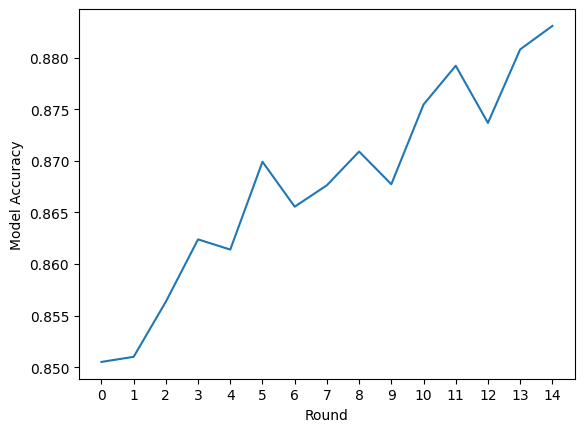

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(model_accuacy_arr)
plt.xticks(range(num_rounds))
plt.xlabel("Round")
plt.ylabel("Model Accuracy")
plt.show()

plt.savefig('model_acc_15_rounds.png')

From the plot above, we can see that the model accuracy increases steadily with each additional round of collecting more labels, getting improved consensus labels, and model training.